# Refactored code into classes (still to be moved)

In [ ]:
from dataclasses import dataclass
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import rv_continuous, rv_histogram
from scipy.interpolate import make_interp_spline
from scipy.special import softmax
from tabpfn import TabPFNRegressor
from scipy.integrate import quad
from scipy.optimize import curve_fit


import numpy as np
import pandas as pd
from analysis.splits import to_train_validation_test_data
from analysis.datasets import load_entsoe

class DataPreprocessor:
    def __init__(self, target_column="power"):
        self.target_column = target_column
        self.max_power_value_rounded = None

    def load_data(self):
        """Loads the dataset."""
        self.df = load_entsoe()
        return self

    def transform_power(self, epsilon=1e-3):
        """Scales the power data using log transformation."""
        max_power_value = self.df[self.target_column].max()
        self.max_power_value_rounded = np.ceil(max_power_value / 1000) * 1000
        self.df[self.target_column] = np.log(self.df[self.target_column] / self.max_power_value_rounded + epsilon)
        return self

    def add_interval_index(self):
        """Creates an interval index feature based on time."""
        self.df['interval_index'] = ((self.df.index.hour * 60 + self.df.index.minute) // 15) + 1
        return self

    def add_lagged_features(self, lag=96):
        """Adds lagged power feature."""
        self.df[f'{self.target_column}_t-{lag}'] = self.df[self.target_column].shift(lag)
        self.df.dropna(inplace=True)
        return self

    def prepare_features(self, selected_features):
        """Selects only the specified features from the DataFrame."""
        selected_features.append(self.target_column)
        self.df = self.df[[feature for feature in selected_features if feature in self.df.columns]]
        return self

    def split_data(self, train_start, train_end, val_start, val_end):
        """Splits dataset into train, validation, and test sets."""
        self.train_X, self.train_y, self.val_X, self.val_y, self.test_X, self.test_y = to_train_validation_test_data(
            self.df, train_start, train_end, val_start, val_end
        )
        return self

    def get_processed_data(self):
        """Returns processed train, validation, and test sets."""
        return self.train_X, self.train_y, self.val_X, self.val_y, self.test_X, self.test_y 

class CRPSMixin:
    def crps(self, y, smoothing=True, window_size=101):
        """
        Calculate the Continuous Ranked Probability Score (CRPS) for a given sample `y`.
        
        Parameters:
        - y: np.array of shape (n,): Values where CRPS is to be computed.
        
        Returns:
        - crps_score: The CRPS score.
        """

        if smoothing:
            pdfs = self.probits / self.bin_widths
            window = np.ones(window_size) / window_size
            smooth_pdf = np.convolve(pdfs, window, mode='same')
            probs = self.bin_widths * smooth_pdf
        else:
            probs = self.probits
        
        cdfs = np.cumsum(probs)

        indicator_f = lambda x: x >= y[:, np.newaxis]
        indicators = indicator_f(self.borders[1:])

        crps_scores = np.sum((cdfs - indicators)**2 * self.bin_widths, axis=1)

        return crps_scores
    
    def crps_normal(mu, sigma, y):
        """
        Compute the CRPS for a normal distribution with given mean (mu), std (sigma), and target y.
        Closed-form solution.
        """
        z = (y - mu) / sigma
        return sigma * (z * (2 * norm.cdf(z) - 1) + 2 * norm.pdf(z) - 1 / np.sqrt(np.pi))


class HistogramBase:
    def __init__(self, logits, borders, *args, **kwargs):
        """
        Args:
        - logits (np.ndarray): An array of shape (5000,) representing logits.
        - borders (np.ndarray): An array of shape (5001,) representing the bin edges for each sample.
        """
        self.logits = logits
        self.probits = softmax(logits) # == np.exp(x)/sum(np.exp(x))
        self.borders = borders
        self.bin_widths = self.get_bin_widths(borders)
        self.bin_midpoints = self.get_midpoints(borders)
        super().__init__(*args, **kwargs)

    @staticmethod
    def get_bin_widths(borders):
        return (borders[1:] - borders[:-1])

    @staticmethod
    def get_midpoints(borders):
        """
        input borders: np.array[5001]
        output midpoints: np.array[5000]
        """
        midpoints = (borders[1:] + borders[:-1]) / 2
        return midpoints
    
class LinearInterpolatedDist(rv_continuous):
    def __init__(self, x, pdf_values, *args, **kwargs):
        self.x = x
        self.pdf_values = pdf_values
        super().__init__(*args, **kwargs)

    def _pdf(self, x):
        pdf = make_interp_spline(x, self.pdf_values, k=1)
        return pdf(x)


class LinearInterpolatedHistWithCRPS(HistogramBase, rv_continuous, CRPSMixin):
    
    def _pdf(self, x):
        pdf = make_interp_spline(self.bin_midpoints, self.probits/self.bin_widths, k=1)
        return pdf(x)


class HistogramWithCRPS(HistogramBase, rv_histogram, CRPSMixin):
    def __init__(self, logits, borders, *args, **kwargs):
        probits = softmax(logits)
        super().__init__(logits=logits, borders=borders, histogram=(probits, borders), density=False, *args, **kwargs)

class HistogramWithCRPSSmoothed(HistogramBase, rv_histogram, CRPSMixin):
    def __init__(self, logits, borders, window_size=5, *args, **kwargs):
        probits = softmax(logits)
        bin_widths = borders[1:] - borders[:-1]
        pdfs = probits / bin_widths
        #window_size = 5
        window = np.ones(window_size) / window_size
        smooth_pdf = np.convolve(pdfs, window, mode='same')
        super().__init__(logits=logits, borders=borders, histogram=(smooth_pdf, borders), density=True, *args, **kwargs)

import scipy.interpolate as spi
from scipy.stats import norm

class CDFPDFInterpolator:
#    def __init__(self, quantiles, probabilities, y_min=-30, y_max=30,
#                 mu_left_asym=-1.72, sigma_left_asym=1.45, mu_right_asym=-1.65, sigma_right_asym=0.79):
        
    def __init__(self, quantiles, probabilities, y_min=-20, y_max=5,
                  mu_left_asym=-1.718314259036157, sigma_left_asym=1.4459376285208483, mu_right_asym=-1.646182571554056, sigma_right_asym=0.7849568217992877):

        self.quantiles = quantiles
        self.probabilities = probabilities
        self.y_min = y_min
        self.y_max = y_max
        self.mu_left_asym = mu_left_asym
        self.sigma_left_asym = sigma_left_asym
        self.mu_right_asym = mu_right_asym
        self.sigma_right_asym = sigma_right_asym
        self.mu_normal, self.sigma_normal = self._fit_full_normal_distribution(self.quantiles, self.probabilities)


        self.full_quantiles = np.concatenate(([self.y_min], self.quantiles, [self.y_max]))

        self.full_probabilities = np.concatenate(([0], self.probabilities, [1]))
        
        self._initialize_interpolators()
    
    def _initialize_interpolators(self):

        self.cdf_linear_interpolator = spi.interp1d(
            self.full_quantiles, self.full_probabilities, kind="linear", fill_value=(0, 1), bounds_error=False
        )
        
        self.cdf_pchip_interpolator = spi.PchipInterpolator(
            self.full_quantiles, self.full_probabilities, extrapolate=True
        )
        
        self.min_delta_quantile = np.min(np.diff(self.quantiles))
    
    def cdf_linear(self, x):
        return float(np.clip(self.cdf_linear_interpolator(x), 0, 1))
        #return np.clip(self.cdf_linear_interpolator(x), 0, 1)
    
    def cdf_pchip(self, x):
        return float(np.clip(self.cdf_pchip_interpolator(x), 0, 1))
        #return np.clip(self.cdf_pchip_interpolator(x), 0, 1)
    
    def pdf_linear(self, x, eps=0.01):
        return (self.cdf_linear(x + eps) - self.cdf_linear(x - eps)) / (2 * eps)
    
    def pdf_pchip(self, x):
        eps = max(self.min_delta_quantile / 2, 1e-8)
        return (self.cdf_pchip_interpolator(x + eps) - self.cdf_pchip_interpolator(x - eps)) / (2 * eps)
    
    def hybrid_cdf(self, x):
        lambda_val, lambda_val_R = 4e0, 4.0
        mu_left, sigma_left = self._fit_tail_distribution(self.quantiles[:2], self.probabilities[:2])
        mu_right, sigma_right = self._fit_tail_distribution(self.quantiles[-2:], self.probabilities[-2:])

        if x < self.quantiles[0]:
            adjusted_sigma = self.sigma_left_asym + (sigma_left - self.sigma_left_asym) * np.exp(-np.abs((x - self.quantiles[0])) / lambda_val)
            adjusted_mu = self.mu_left_asym + (mu_left - self.mu_left_asym) * np.exp(-np.abs((x - self.quantiles[0])) / lambda_val)
            return norm.cdf(x, loc=adjusted_mu, scale=adjusted_sigma)
        
        elif x > self.quantiles[-1]:
            adjusted_sigma = self.sigma_right_asym + (sigma_right - self.sigma_right_asym) * np.exp(-np.abs((x - self.quantiles[-1])) / lambda_val_R)
            adjusted_mu = self.mu_right_asym + (mu_right - self.mu_right_asym) * np.exp(-np.abs((x - self.quantiles[-1])) / lambda_val_R)
            return norm.cdf(x, loc=adjusted_mu, scale=adjusted_sigma)
        else:
            return float(np.clip(self.cdf_pchip_interpolator(x), 0, 1))
            #return np.clip(self.cdf_pchip_interpolator(x), 0, 1)
    

    def pdf_hybrid(self, x):
        """
        Hybrid PDF:
        - Left normal distribution for (x < first quantile) based on first two quantiles
        - PCHIP interpolation derivative for middle range
        - Right normal distribution for (x > last quantile) based on last two quantiles
        """
        lambda_val = 4e0
        lambda_val_R = 4.0

        # Ensure the tail parameters are computed dynamically
        mu_left, sigma_left = self._fit_tail_distribution(self.quantiles[:2], self.probabilities[:2])
        mu_right, sigma_right = self._fit_tail_distribution(self.quantiles[-2:], self.probabilities[-2:])

        sigma_left_min = self.sigma_left_asym
        sigma_right_min = self.sigma_right_asym
        mu_left_min = self.mu_left_asym
        mu_right_min = self.mu_right_asym

        if x < self.quantiles[0]:  # Left tail
            #print(f"x < self.quantiles[0]: {x} < {self.quantiles[0]}")
            adjusted_sigma_left = sigma_left_min + (sigma_left - sigma_left_min) * np.exp(-np.abs((x - self.quantiles[0])) / lambda_val)
            adjusted_mu_left = mu_left_min + (mu_left - mu_left_min) * np.exp(-np.abs((x - self.quantiles[0])) / lambda_val)
            
            #print(f"Left Tail -> adjusted_mu: {adjusted_mu_left}, adjusted_sigma: {adjusted_sigma_left}")
            pdf_value = norm.pdf(x, loc=adjusted_mu_left, scale=adjusted_sigma_left)
            #print(f"Left Tail PDF Value: {pdf_value}")
            return pdf_value

        elif x > self.quantiles[-1]:  # Right tail
            #print(f"x > self.quantiles[-1]: {x} > {self.quantiles[-1]}")
            adjusted_sigma_right = sigma_right_min + (sigma_right - sigma_right_min) * np.exp(-np.abs((x - self.quantiles[-1])) / lambda_val_R)
            adjusted_mu_right = mu_right_min + (mu_right - mu_right_min) * np.exp(-np.abs((x - self.quantiles[-1])) / lambda_val_R)
            #print(f"Right Tail -> adjusted_mu: {adjusted_mu_right}, adjusted_sigma: {adjusted_sigma_right}")
            pdf_value = norm.pdf(x, loc=adjusted_mu_right, scale=adjusted_sigma_right)
            #print(f"Right Tail PDF Value: {pdf_value}")
            return pdf_value
        
        elif x > (self.quantiles[-2] + self.quantiles[-1]) / 2:  # Transition to right tail
            #print(f"x > (self.quantiles[-2] + self.quantiles[-1]) / 2: {x} > {(self.quantiles[-2] + self.quantiles[-1]) / 2}")
            adjusted_sigma_right = sigma_right_min + (sigma_right - sigma_right_min) * np.exp(- np.abs((x - self.quantiles[-1])) / lambda_val_R)
            adjusted_mu_right = mu_right_min + (mu_right - mu_right_min) * np.exp(-np.abs((x - self.quantiles[-1])) / lambda_val_R)
            pdf_value_R = norm.pdf(x, loc=adjusted_mu_right, scale=adjusted_sigma_right)
            eps = max(self.min_delta_quantile / 2, 1e-5)
            pdf_value_M = (self.cdf_pchip_interpolator(x + eps) - self.cdf_pchip_interpolator(x - eps)) / (2 * eps)
            #print(f"Right Transition -> PDF Value Right: {pdf_value_R}, PDF Value Middle: {pdf_value_M}")
            return np.max([pdf_value_R, pdf_value_M])

        elif x < (self.quantiles[0] + self.quantiles[1]) / 2:  # Transition to left tail
            #print(f"x < (self.quantiles[0] + self.quantiles[1]) / 2: {x} < {(self.quantiles[0] + self.quantiles[1]) / 2}")
            adjusted_sigma_left = sigma_left_min + (sigma_left - sigma_left_min) * np.exp(- np.abs((x - self.quantiles[0])) / lambda_val)
            adjusted_mu_left = mu_left_min + (mu_left - mu_left_min) * np.exp(-np.abs((x - self.quantiles[0])) / lambda_val)
            pdf_value_L = norm.pdf(x, loc=adjusted_mu_left, scale=adjusted_sigma_left)
            eps = max(self.min_delta_quantile / 2, 1e-5)
            pdf_value_M = (self.cdf_pchip_interpolator(x + eps) - self.cdf_pchip_interpolator(x - eps)) / (2 * eps)
            #print(f"Left Transition -> PDF Value Left: {pdf_value_L}, PDF Value Middle: {pdf_value_M}")
            return np.max([pdf_value_L, pdf_value_M])

        else:  # Middle range (PCHIP interpolation)
            eps = max(self.min_delta_quantile / 2, 1e-5)
            pdf_value = (self.cdf_pchip_interpolator(x + eps) - self.cdf_pchip_interpolator(x - eps)) / (2 * eps)
            #print(f"Middle Region -> PDF Value: {pdf_value}")
            return pdf_value
    
    def fitted_normal_pdf(self, x):
        return norm.pdf(x, loc=self.mu_normal, scale=self.sigma_normal)

    def fitted_normal_cdf(self, x):
        return norm.cdf(x, loc=self.mu_normal, scale=self.sigma_normal)

    def _fit_tail_distribution(self, quantiles, probabilities):
        """Fits a normal distribution to the given quantiles and associated probabilities."""
        z_scores = norm.ppf(probabilities)
        sigma = (quantiles[1] - quantiles[0]) / (z_scores[1] - z_scores[0])
        mu = quantiles[0] - sigma * z_scores[0]
        return mu, sigma
    
    def _fit_full_normal_distribution(self, quantiles, probabilities):
        """Fits a single normal distribution to all quantiles."""
        z_scores = norm.ppf(probabilities)
        A = np.vstack([z_scores, np.ones_like(z_scores)]).T
        sigma, mu = np.linalg.lstsq(A, quantiles, rcond=None)[0]  # linear fit
        return mu, sigma


@dataclass
class Experiment:
    X_train: np.ndarray
    y_train: np.ndarray
    X_validation: np.ndarray
    y_validation: np.ndarray
    device: str = "auto"
    random_state: int = 42
    fit_mode: str = "low_memory"
    ignore_pretraining_limits: bool = False
    logits: None | np.ndarray = None
    borders: None | np.ndarray = None
    deciles: None | np.ndarray = None

    def __post_init__(self):
        self._cdf_pdf_interpolators = None  # Initialize the attribute

    def perform(self):
        """ Ensure perform() is explicitly called before interpolation. """
        model = TabPFNRegressor(device=self.device, fit_mode=self.fit_mode, random_state=self.random_state, ignore_pretraining_limits=self.ignore_pretraining_limits)
        model.fit(self.X_train, self.y_train)

        quantiles_custom = np.arange(0.1, 1, 0.1)
        probs_val_q = model.predict(self.X_validation, output_type="full", quantiles=quantiles_custom)

        self.logits = probs_val_q["logits"].numpy()
        self.borders = probs_val_q["criterion"].borders.numpy()
        self.deciles = np.array(probs_val_q["quantiles"]).T

        if self.deciles is None or self.deciles.shape[1] != 9:
            raise ValueError(f"Expected deciles to have shape (n, 9), but got {self.deciles.shape}")

        return self
    
    @property
    def hists(self) -> list[HistogramWithCRPS]:
        """
        Create a list of HistogramWithCRPS objects for each of the logits.

        Returns:
        - list: A list of HistogramWithCRPS objects of length n.
        """
        n = self.logits.shape[0]
        histograms = []
        
        # Iterate over the logits (axis 1: 5000 logits)
        for i in range(n):
            hist = HistogramWithCRPS(self.logits[i, :], self.borders)
            histograms.append(hist)
        
        return histograms

    def hists_smoothed(self, window_size=5) -> list[HistogramWithCRPSSmoothed]:
        """
        Create a list of HistogramWithCRPSSmoothed objects for each of the logits.

        Returns:
        - list: A list of HistogramWithCRPSSmoothed objects of length n.
        """
        n = self.logits.shape[0]
        histograms = []
        
        # Iterate over the logits (axis 1: 5000 logits)
        for i in range(n):
            hist = HistogramWithCRPSSmoothed(self.logits[i, :], self.borders, window_size=window_size)
            histograms.append(hist)
        
        return histograms
    
    @property
    def dists(self) -> list[HistogramWithCRPS]:
        """
        Create a list of HistogramWithCRPS objects for each of the logits.

        Returns:
        - list: A list of HistogramWithCRPS objects of length n.
        """
        n = self.logits.shape[0]
        histograms = []
        
        # Iterate over the logits (axis 1: 5000 logits)
        for i in range(n):
            hist = LinearInterpolatedHistWithCRPS(self.logits[i, :], self.borders)
            histograms.append(hist)
        
        return histograms

    @property
    def cdf_pdf_interpolators(self) -> list[CDFPDFInterpolator]:
        """Create a list of CDFPDFInterpolator objects, caching the result."""
        if self._cdf_pdf_interpolators is None:
            if self.deciles is None:
                raise ValueError("Deciles data not available. Run `experiment.perform()` first.")

            if self.deciles.shape[1] != 9:
                raise ValueError(f"Expected deciles to have shape (n, 9), but got {self.deciles.shape}")

            probabilities = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

            self._cdf_pdf_interpolators = []

            print("Initializing Interpolator objects...")
            for i in range(self.deciles.shape[0]):
                interpolator = CDFPDFInterpolator(self.deciles[i, :], probabilities)
                self._cdf_pdf_interpolators.append(interpolator)

            print(f"created {len(self._cdf_pdf_interpolators)} CDFPDFInterpolator objects")
        return self._cdf_pdf_interpolators

   
    def calculate_nll(self, data_type='validation', smoothing=False, window_size=11):
        """
        Calculate the Negative Log-Likelihood (NLL) for all histograms of a given experiment.

        Parameters:
        - data_type: 'validation' or 'test'
        - smoothing: If True, use smoothed histograms
        - interpolated: If True, use linearly interpolated histograms

        Returns:
        - total_nll: Total Negative Log-Likelihood value for all histograms
        """
        # Select the appropriate data
        if data_type == 'validation':
            y_data = self.y_validation
        elif data_type == 'test':
            y_data = self.y_test
        else:
            raise ValueError("Invalid data_type, expected 'validation' or 'test'.")

        # Select the right distribution objects
        if smoothing:
            dists = self.hists_smoothed(window_size=window_size)  # HistogramWithCRPSSmoothed
        else:
            dists = self.hists  # HistogramWithCRPS

        # Compute raw NLLs
        nlls = [-dist.logpdf(y) for dist, y in zip(dists, y_data)]

        # Replace infs with the max finite NLL
        finite_nlls = [nll for nll in nlls if np.isfinite(nll)]
        max_finite = max(finite_nlls) if finite_nlls else 0
        cleaned_nlls = [nll if np.isfinite(nll) else max_finite for nll in nlls]

        min_nll = np.min(cleaned_nlls)
        mean_nll = np.mean(cleaned_nlls)
        median_nll = np.median(cleaned_nlls)
        max_nll = np.max(cleaned_nlls)

        return mean_nll, median_nll, min_nll, max_nll
    
    def calculate_crps(self, data_type='validation', smoothing=False, window_size=5):
        # Select the appropriate data
        if data_type == 'validation':
            y_data = self.y_validation
        elif data_type == 'test':
            y_data = self.y_test
        else:
            raise ValueError("Invalid data_type, expected 'validation' or 'test'.")

        # Select the right distribution objects
        if smoothing:
            dists = self.hists_smoothed(window_size=window_size)  # List of HistogramWithCRPSSmoothed
        else:
            dists = self.hists  # List of HistogramWithCRPS

        # Check length match
        if len(dists) != len(y_data):
            raise ValueError(f"Length mismatch: {len(dists)} dists vs {len(y_data)} y_data")

        # Compute CRPS scores
        #crps_scores = [dist.crps(np.array([y])) for dist, y in zip(dists, y_data)] old
        crps_scores = [dist.crps(np.array([y]), smoothing=smoothing, window_size=window_size) for dist, y in zip(dists, y_data)]

        min_crps = np.min(crps_scores)
        mean_crps = np.mean(crps_scores)
        median_crps = np.median(crps_scores)
        max_crps = np.max(crps_scores)

        return mean_crps, median_crps, min_crps, max_crps
    
    def calculate_crps_with_interpolator(self, method="linear"):
        """
        Calculate the CRPS using the specified CDF method from the CDFPDFInterpolator objects.

        Parameters:
        - method (str): Which method to use ('linear', 'pchip', 'hybrid').

        Returns:
        - float: Mean CRPS score for the specified CDF method.
        """
        crps_values = []

        for i, (dist, y) in enumerate(zip(self.cdf_pdf_interpolators, self.y_validation)):
            if method == "normal":
                deciles = self.deciles[i,:]
                probabilities = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
                # Provide a reasonable initial guess
                mu_init = np.mean(deciles)
                sigma_init = (np.max(deciles) - np.min(deciles)) / 4  # Rough estimate
                #params, _ = curve_fit(lambda x, mu, sigma: norm.cdf(x, loc=mu, scale=sigma), 
                #                  deciles, probabilities, p0=[mu_init, sigma_init])
                params, _ = curve_fit(lambda x, mu, sigma: norm.ppf(x, loc=mu, scale=sigma), 
                    probabilities, deciles, p0=[mu_init, sigma_init])
                mu_fit, sigma_fit = params
                z = (y - mu_fit) / sigma_fit
                crps_value = sigma_fit * ( 
                        z * (2 * norm.cdf(z) - 1)
                        + 2 * norm.pdf(z) 
                        - 1/np.sqrt(np.pi)
                )      
            else:
                # Select the appropriate CDF method
                if method == "linear":
                    cdf = dist.cdf_linear
                elif method == "pchip":
                    cdf = dist.cdf_pchip
                elif method == "hybrid":
                    cdf = dist.hybrid_cdf
                else:
                    raise ValueError(f"Unknown method: {method}. Choose from 'linear', 'pchip', or 'hybrid'.")

                # Define the CRPS integrands and compute it
                integrand_1 = lambda x: (cdf(x))**2
                integrand_2 = lambda x: (1 - cdf(x))**2
                crps_1, _ = quad(integrand_1, dist.y_min, y, epsabs=1e-6, epsrel=1e-6)
                crps_2, _ = quad(integrand_2, y, dist.y_max, epsabs=1e-6, epsrel=1e-6)
                crps_value = crps_1 + crps_2

            crps_values.append(crps_value)

            if (i + 1) % 100 == 0:
                print(f"CRPS at sample {i+1}: {crps_value}")

        min_crps = np.min(crps_values)
        mean_crps = np.mean(crps_values)
        median_crps = np.median(crps_values)
        max_crps = np.max(crps_values)

        return mean_crps, median_crps, min_crps, max_crps

    def calculate_nll_with_interpolator(self, method="linear"):
        """
        Calculate the NLL using the specified PDF method from the CDFPDFInterpolator objects.

        Parameters:
        - method (str): Which method to use ('linear', 'pchip', 'hybrid').

        Returns:
        - float: Mean NLL score for the specified PDF method.
        """
        nll_values = []

        for i, (dist, y) in enumerate(zip(self.cdf_pdf_interpolators, self.y_validation)):

            if method == "normal":
                deciles = self.deciles[i,:]
                probabilities = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
                # Provide a reasonable initial guess
                mu_init = np.mean(deciles)
                sigma_init = (np.max(deciles) - np.min(deciles)) / 4  # Rough estimate
                #params, _ = curve_fit(lambda x, mu, sigma: norm.cdf(x, loc=mu, scale=sigma), 
                #                  deciles, probabilities, p0=[mu_init, sigma_init])
                params, _ = curve_fit(lambda x, mu, sigma: norm.ppf(x, loc=mu, scale=sigma), 
                    probabilities, deciles, p0=[mu_init, sigma_init])
                mu_fit, sigma_fit = params
                pdf_value = norm.pdf(y, loc=mu_fit, scale=sigma_fit)
                # Calculate the NLL for the normal distribution
                nll_value = -np.log(pdf_value)
   
            else:
                # Select the appropriate CDF method
                if method == "linear":
                    pdf = dist.pdf_linear
                elif method == "pchip":
                    pdf = dist.pdf_pchip
                elif method == "hybrid":
                    pdf = dist.pdf_hybrid
                else:
                    raise ValueError(f"Unknown method: {method}. Choose from 'linear', 'pchip', or 'hybrid'.")

                # Calculate the PDF at the observed value y
                pdf_value = pdf(y)
                # Calculate the NLL for the current distribution
                nll_value = -np.log(pdf_value)

            # Append NLL value for current sample
            nll_values.append(nll_value)

            # Print progress every 100 samples
            if (i + 1) % 100 == 0:
                print(f"NLL at sample {i+1}: {nll_value}")

        # Return the mean NLL value across all samples

        min_nll = np.min(nll_values)
        mean_nll = np.mean(nll_values)
        median_nll = np.median(nll_values)
        max_nll = np.max(nll_values)

        return mean_nll, median_nll, min_nll, max_nll

class ExperimentTracker:
    def __init__(self):
        self.experiments: list[Experiment] = []

    def track(self, X_train, y_train, X_validation, y_validation, 
            device: str = "auto", fit_mode: str = "low_memory", random_state: int = 42, ignore_pretraining_limits=False) -> Experiment:
        experiment = Experiment(X_train=X_train, y_train=y_train, X_validation=X_validation, y_validation=y_validation, device=device, fit_mode=fit_mode, random_state=random_state, ignore_pretraining_limits=ignore_pretraining_limits)
        experiment.perform()
        self.experiments.append(experiment)
        return experiment
    
    def __str__(self):
        return f"ExperimentTracker(len(experiments)=={len(self.experiments)})"
        

def get_histograms_from(experiment: Experiment) -> list[HistogramWithCRPS]:
    """
    Create a list of HistogramWithCRPS objects for each of the logits.

    Returns:
    - list: A list of HistogramWithCRPS objects of length n.
    """
    n = experiment.logits.shape[0]
    histograms = []
    
    # Iterate over the logits (axis 1: 5000 logits)
    for i in range(n):
        hist = HistogramWithCRPS(experiment.logits[i, :], experiment.borders)
        histograms.append(hist)
    
    return histograms

def get_linear_interpolated_dists_from(experiment: Experiment) -> list[HistogramWithCRPS]:
    """
    Create a list of HistogramWithCRPS objects for each of the logits.

    Returns:
    - list: A list of HistogramWithCRPS objects of length n.
    """
    n = experiment.logits.shape[0]
    histograms = []
    
    # Iterate over the logits (axis 1: 5000 logits)
    for i in range(n):
        hist = LinearInterpolatedHistWithCRPS(experiment.logits[i, :], experiment.borders)
        histograms.append(hist)
    
    return histograms


class ExperimentMapper:

    @staticmethod

    def map_id_to_config(experiment_id: int):

        config = []

        if experiment_id  == 1:
            config = [
                {
                "selected_features": ["ws_10m_loc_mean", "ws_100m_loc_mean", "power_t-96"],
                "train_start": "2022-01-01",
                "train_end": "2022-03-31",
                "val_start": "2023-01-01",
                "val_end": "2023-03-31",
                "random_state": 42
                }
            ]

        elif experiment_id  == 2:
            config = [
                {
                "selected_features": ["ws_10m_loc_mean", "ws_100m_loc_mean", "power_t-96"],
                "train_start": "2022-04-01",
                "train_end": "2022-06-30",
                "val_start": "2023-04-01",
                "val_end": "2023-06-30",
                "random_state": 42
                }
            ]

        elif experiment_id  == 3:
            config = [
                {
                "selected_features": ["ws_10m_loc_mean", "ws_100m_loc_mean", "power_t-96"],
                "train_start": "2022-07-01",
                "train_end": "2022-09-30",
                "val_start": "2023-07-01",
                "val_end": "2023-09-30",
                "random_state": 42
                }
            ]
        elif experiment_id  == 4:
            config = [
                {
                "selected_features": ["ws_10m_loc_mean", "ws_100m_loc_mean", "power_t-96"],
                "train_start": "2022-10-01",
                "train_end": "2022-12-31",
                "val_start": "2023-10-01",
                "val_end": "2023-12-31",
                "random_state": 42
                }
            ]
        elif experiment_id  == 5:
            config = [
                {
                "selected_features": ["ws_10m_loc_mean", "ws_100m_loc_mean", "power_t-96"],
                "train_start": "2022-10-01",
                "train_end": "2022-12-31",
                "val_start": "2023-01-01",
                "val_end": "2023-03-31",
                "random_state": 42
                }
            ]
        elif experiment_id  == 6:
            config = [
                {
                "selected_features": ["ws_10m_loc_mean", "ws_100m_loc_mean", "power_t-96"],
                "train_start": "2022-10-01",
                "train_end": "2022-12-31",
                "val_start": "2023-04-01",
                "val_end": "2023-06-30",
                "random_state": 42
                }
            ]
        elif experiment_id  == 7:
            config = [
                {
                "selected_features": ["ws_10m_loc_mean", "ws_100m_loc_mean", "power_t-96"],
                "train_start": "2022-10-01",
                "train_end": "2022-12-31",
                "val_start": "2023-07-01",
                "val_end": "2023-09-30",
                "random_state": 42
                }
            ]
        elif experiment_id  == 8:
            config = [
                {
                "selected_features": ["ws_10m_loc_1", "ws_10m_loc_2", "ws_10m_loc_3", "ws_10m_loc_4", "ws_10m_loc_5", "ws_10m_loc_6", "ws_10m_loc_7", "ws_10m_loc_8", "ws_10m_loc_9", "ws_10m_loc_10", 
                                        "ws_100m_loc_1", "ws_100m_loc_2", "ws_100m_loc_3", "ws_100m_loc_4", "ws_100m_loc_5", "ws_100m_loc_6", "ws_100m_loc_7", "ws_100m_loc_8", "ws_100m_loc_9", "ws_100m_loc_10", "power_t-96"],
                "train_start": "2022-10-01",
                "train_end": "2022-12-31",
                "val_start": "2023-01-01",
                "val_end": "2023-06-30",
                "random_state": 42
                }
            ]
        elif experiment_id  == 9:
            config = [
                {
                "selected_features": ["ws_10m_loc_1", "ws_10m_loc_2", "ws_10m_loc_3", "ws_10m_loc_4", "ws_10m_loc_5", "ws_10m_loc_6", "ws_10m_loc_7", "ws_10m_loc_8", "ws_10m_loc_9", "ws_10m_loc_10", 
                                        "ws_100m_loc_1", "ws_100m_loc_2", "ws_100m_loc_3", "ws_100m_loc_4", "ws_100m_loc_5", "ws_100m_loc_6", "ws_100m_loc_7", "ws_100m_loc_8", "ws_100m_loc_9", "ws_100m_loc_10", "power_t-96"],
                "train_start": "2022-10-01",
                "train_end": "2022-12-31",
                "val_start": "2023-07-01",
                "val_end": "2023-12-31",
                "random_state": 42
                }
            ]
        elif experiment_id  == 10:
            config = [
                {
                "selected_features": ["ws_10m_loc_mean", "ws_100m_loc_mean", "ws_10m_loc_1", "ws_10m_loc_2", "ws_10m_loc_3", "ws_10m_loc_4", "ws_10m_loc_5", "ws_10m_loc_6", "ws_10m_loc_7", "ws_10m_loc_8", "ws_10m_loc_9", "ws_10m_loc_10", 
                                        "ws_100m_loc_1", "ws_100m_loc_2", "ws_100m_loc_3", "ws_100m_loc_4", "ws_100m_loc_5", "ws_100m_loc_6", "ws_100m_loc_7", "ws_100m_loc_8", "ws_100m_loc_9", "ws_100m_loc_10", "power_t-96"],
                "train_start": "2022-10-01",
                "train_end": "2022-12-31",
                "val_start": "2023-01-01",
                "val_end": "2023-06-30",
                "random_state": 42
                }
            ]
        elif experiment_id  == 11:
            config = [
                {
                "selected_features": ["ws_10m_loc_mean", "ws_100m_loc_mean", "ws_10m_loc_1", "ws_10m_loc_2", "ws_10m_loc_3", "ws_10m_loc_4", "ws_10m_loc_5", "ws_10m_loc_6", "ws_10m_loc_7", "ws_10m_loc_8", "ws_10m_loc_9", "ws_10m_loc_10", 
                                        "ws_100m_loc_1", "ws_100m_loc_2", "ws_100m_loc_3", "ws_100m_loc_4", "ws_100m_loc_5", "ws_100m_loc_6", "ws_100m_loc_7", "ws_100m_loc_8", "ws_100m_loc_9", "ws_100m_loc_10", "power_t-96"],
                "train_start": "2022-10-01",
                "train_end": "2022-12-31",
                "val_start": "2023-07-01",
                "val_end": "2023-12-31",
                "random_state": 42
                }
            ]
        elif experiment_id  == 12:
            config = [
                {
                "selected_features": ["ws_10m_loc_mean", "ws_100m_loc_mean", "ws_10m_loc_1", "ws_10m_loc_2", "ws_10m_loc_3", "ws_10m_loc_4", "ws_10m_loc_5", "ws_10m_loc_6", "ws_10m_loc_7", "ws_10m_loc_8", "ws_10m_loc_9", "ws_10m_loc_10", 
                                        "ws_100m_loc_1", "ws_100m_loc_2", "ws_100m_loc_3", "ws_100m_loc_4", "ws_100m_loc_5", "ws_100m_loc_6", "ws_100m_loc_7", "ws_100m_loc_8", "ws_100m_loc_9", "ws_100m_loc_10", "power_t-96", "interval_index"],
                "train_start": "2022-10-01",
                "train_end": "2022-12-31",
                "val_start": "2023-01-01",
                "val_end": "2023-06-30",
                "random_state": 42
                }
            ]
        elif experiment_id == 13:
            config = [
                {
                "selected_features": ["ws_10m_loc_mean", "ws_100m_loc_mean", "ws_10m_loc_1", "ws_10m_loc_2", "ws_10m_loc_3", "ws_10m_loc_4", "ws_10m_loc_5", "ws_10m_loc_6", "ws_10m_loc_7", "ws_10m_loc_8", "ws_10m_loc_9", "ws_10m_loc_10", 
                                        "ws_100m_loc_1", "ws_100m_loc_2", "ws_100m_loc_3", "ws_100m_loc_4", "ws_100m_loc_5", "ws_100m_loc_6", "ws_100m_loc_7", "ws_100m_loc_8", "ws_100m_loc_9", "ws_100m_loc_10", "power_t-96", "interval_index"],
                "train_start": "2022-10-01",
                "train_end": "2022-12-31",
                "val_start": "2023-07-01",
                "val_end": "2023-12-31",
                "random_state": 42
                }
            ]
        elif experiment_id == 14:
            config = [
                {
                "selected_features": ["ws_10m_loc_mean", "ws_100m_loc_mean","power_t-96"],
                "train_start": "2022-01-01",
                "train_end": "2022-03-31",
                "val_start": "2023-04-01",
                "val_end": "2023-06-30",
                "random_state": 42
                }
            ]
        elif experiment_id == 15:
            config = [
                {
                "selected_features": ["ws_10m_loc_mean", "ws_100m_loc_mean","power_t-96"],
                "train_start": "2022-07-01",
                "train_end": "2022-09-30",
                "val_start": "2023-04-01",
                "val_end": "2023-06-30",
                "random_state": 42
                }
            ]
        elif experiment_id == 16:
            config = [
                {
                "selected_features": ["ws_10m_loc_mean", "ws_100m_loc_mean","power_t-96"],
                "train_start": "2022-01-01",
                "train_end": "2022-03-31",
                "val_start": "2023-10-01",
                "val_end": "2023-12-31",
                "random_state": 42
                }
            ]
        elif experiment_id == 17:
            config = [
                {
                "selected_features": ["ws_10m_loc_mean", "ws_100m_loc_mean","power_t-96"],
                "train_start": "2022-01-01",
                "train_end": "2022-03-31",
                "val_start": "2023-07-01",
                "val_end": "2023-09-30",
                "random_state": 42
                }
            ]
        elif experiment_id == 18:
            config = [
                {
                "selected_features": ["ws_10m_loc_mean", "ws_100m_loc_mean","power_t-96"],
                "train_start": "2022-04-01",
                "train_end": "2022-06-30",
                "val_start": "2023-01-01",
                "val_end": "2023-03-31",
                "random_state": 42
                }
            ]
        elif experiment_id == 19:
            config = [
                {
                "selected_features": ["ws_10m_loc_mean", "ws_100m_loc_mean","power_t-96"],
                "train_start": "2022-04-01",
                "train_end": "2022-06-30",
                "val_start": "2023-07-01",
                "val_end": "2023-09-30",
                "random_state": 42
                }
            ]
        elif experiment_id == 20:
            config = [
                {
                "selected_features": ["ws_10m_loc_mean", "ws_100m_loc_mean","power_t-96"],
                "train_start": "2022-04-01",
                "train_end": "2022-06-30",
                "val_start": "2023-10-01",
                "val_end": "2023-12-31",
                "random_state": 42
                }
            ]
        elif experiment_id == 21:
            config = [
                {
                "selected_features": ["ws_10m_loc_mean", "ws_100m_loc_mean","power_t-96"],
                "train_start": "2022-07-01",
                "train_end": "2022-09-30",
                "val_start": "2023-01-01",
                "val_end": "2023-03-31",
                "random_state": 42
                }
            ]
        elif experiment_id == 22:
            config = [
                {
                "selected_features": ["ws_10m_loc_mean", "ws_100m_loc_mean","power_t-96"],
                "train_start": "2022-07-01",
                "train_end": "2022-09-30",
                "val_start": "2023-10-01",
                "val_end": "2023-12-31",
                "random_state": 42
                }
            ]
    
            #elif experiment_id == 23:
            #config = [
            #    {
            #    "selected_features": ["power_t-96"],
            #    "train_start": "2022-01-01",
            #    "train_end": "2022-03-31",
            #    "val_start": "2023-01-01",
            #    "val_end": "2023-03-31",
            #    "random_state": 42
            #    }
            #]
        else:
            raise ValueError(f"Experiment ID {experiment_id} is not valid.")
        
        return config

import pickle
import os

class ExperimentStorage:
    def __init__(self, file_path):
        self.file_path = file_path

    def save(self, experiment: Experiment):
        """Save the ExperimentTracker object to a file."""

        directory = os.path.dirname(self.file_path)
        if not os.path.exists(directory):
            os.makedirs(directory)

        with open(self.file_path, "wb") as f:
            pickle.dump(experiment, f)

    def load(self):
        """Load the Experiment object from a file."""
        if os.path.exists(self.file_path):
            with open(self.file_path, "rb") as f:
                return pickle.load(f)

class Visualization:
    def __init__(self, experiment: Experiment):
        self.experiment = experiment

    def old_compare_all_pdf_methods(self, id: int, case: int, window_size: int = 101):
        interpolator = self.experiment.cdf_pdf_interpolators[id]
        dist = self.experiment.dists[id]
        quantiles = interpolator.quantiles

        # X-axis range for interpolated PDFs
        x_min_full = np.floor(quantiles[0] - 5) 
        x_max_full = np.min([0.5, np.floor(quantiles[-1] + 2)])
        #x_values = np.linspace(x_min_full, x_max_full, 18500)
        bin_x = dist.bin_midpoints
        x_values = bin_x

        # Interpolated PDFs
        pdf_linear = np.array([interpolator.pdf_linear(x) for x in x_values])
        pdf_pchip = np.array([interpolator.pdf_pchip(x) for x in x_values])
        pdf_hybrid = np.array([interpolator.pdf_hybrid(x) for x in x_values])
        pdf_normal = np.array([interpolator.fitted_normal_pdf(x) for x in x_values])

        # Raw + Smoothed PDF
        raw_pdf = dist.pdf(bin_x)
        smooth_pdf = np.convolve(raw_pdf, np.ones(window_size) / window_size, mode='same')

        # Case-specific zoom regions
        if case == 1:
            title = "Full Distribution"
            x_min, x_max = x_min_full, x_max_full
        elif case == 2:
            peak_index = np.argmax(pdf_hybrid)
            peak_x = x_values[peak_index]
            x_min, x_max = peak_x - 0.2, peak_x + 0.2
            x_min = np.floor(10 * quantiles[0]) / 10
            x_max = np.ceil(10 * quantiles[-1]) / 10
            title = "Peak Region"
        elif case == 3:
            x_min, x_max = quantiles[0] - 3.1, quantiles[0] - 2.9
            title = "Left Tail"
        else:
            raise ValueError("Invalid case. Choose 1 (full), 2 (peak), or 3 (left tail)")

        # Filter values for y-limits
        def in_range(x, y): return y[(x >= x_min) & (x <= x_max)]

        if (case == 1 or case == 2):
            y_all = in_range(bin_x, raw_pdf)
        
        else:

            y_all = np.concatenate([
                in_range(x_values, pdf_linear),
                in_range(x_values, pdf_pchip),
                in_range(x_values, pdf_hybrid),
                in_range(bin_x, raw_pdf),
                in_range(bin_x, smooth_pdf)
            ])
            
        y_all = y_all[y_all > 0]  # Remove zeros or negatives before log scale
        y_min = 10 ** np.ceil(np.log10(np.min(y_all))) * 0.9 if len(y_all) > 0 else 1e-7
        y_max = 10 ** np.floor(np.log10(np.max(y_all))) * 10 if len(y_all) > 0 else 1e1
        y_min = 10 ** np.floor(np.log10(np.min(y_all))) * 1.0 if len(y_all) > 0 else 1e-7
        y_max = 10 ** np.ceil(np.log10(np.max(y_all))) * 1.0 if len(y_all) > 0 else 1e1

        # Plot
        plt.figure(figsize=(10, 5))
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.yscale("log")

        # Plot all methods
        plt.plot(x_values, pdf_linear, label="Linear Interpolation", linewidth=1)
        plt.plot(x_values, pdf_pchip, label="PCHIP Interpolation", linewidth=1)
        plt.plot(x_values, pdf_hybrid, label="Hybrid Interpolation", linewidth=1)
        plt.plot(bin_x, raw_pdf, 'o', color='red', markersize=1, label="Raw PDF")
        plt.plot(bin_x, smooth_pdf, linestyle="dashdot", color='blue', linewidth=1, label=f"Smoothed PDF (window={window_size})")
        plt.plot(bin_x, pdf_normal, linewidth=1, label=f"Normal PDF")
        plt.scatter(quantiles, np.array([interpolator.pdf_hybrid(q) for q in quantiles]), color="black", s=30, marker="x")

        plt.xlabel("Value")
        plt.ylabel("PDF (log scale)")
        plt.title(f"PDF Comparison for Sample {id} - {title}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # For case 2, make a separate plot with linear y scale
        if case == 2:
            y_max_linear = np.max([np.max(pdf_linear), np.max(pdf_pchip), np.max(pdf_hybrid), np.max(raw_pdf), np.max(smooth_pdf)]) * 1.1

            plt.figure(figsize=(10, 5))
            plt.xlim(x_min, x_max)
            plt.ylim(0, y_max_linear)

            # Plot all methods with linear scale
            plt.plot(x_values, pdf_linear, label="Linear Interpolation", linewidth=1)
            plt.plot(x_values, pdf_pchip, label="PCHIP Interpolation", linewidth=1)
            plt.plot(x_values, pdf_hybrid, label="Hybrid Interpolation", linewidth=1)
            plt.plot(bin_x, raw_pdf, 'o', color='red', markersize=1, label="Raw PDF")
            plt.plot(bin_x, smooth_pdf, linestyle="dashdot", color='blue', linewidth=1, label=f"Smoothed PDF (window={window_size})")
            plt.plot(bin_x, pdf_normal, linewidth=1, label=f"Normal PDF")
            plt.scatter(quantiles, np.array([interpolator.pdf_hybrid(q) for q in quantiles]), color="black", s=30, marker="x")

            plt.xlabel("Value")
            plt.ylabel("PDF")
            plt.title(f"PDF Comparison for Sample {id} - {title} (Linear Scale)")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    def compare_all_cdf_methods(self, id: int, case: int, window_size: int = 101):
        interpolator = self.experiment.cdf_pdf_interpolators[id]
        dist = self.experiment.hists[id]
        quantiles = interpolator.quantiles

        # X-axis range for interpolated CDFs
        x_min_full = np.floor(quantiles[0] - 5) 
        x_max_full = np.min([0.5, np.floor(quantiles[-1] + 2)])
        bin_x = dist.bin_midpoints
        x_values = bin_x

        # Interpolated CDFs
        cdf_linear = np.array([interpolator.cdf_linear(x) for x in x_values])
        cdf_pchip = np.array([interpolator.cdf_pchip(x) for x in x_values])
        cdf_hybrid = np.array([interpolator.hybrid_cdf(x) for x in x_values])
        cdf_normal = np.array([interpolator.fitted_normal_cdf(x) for x in x_values])

        # Raw + Smoothed CDF
        raw_cdf = dist.cdf(bin_x)
        #smooth_cdf = np.convolve(raw_cdf, np.ones(window_size) / window_size, mode='same') is not correct moving average

        # Case-specific zoom regions
        if case == 1:
            title = "Wide Region"
            x_min, x_max = x_min_full, x_max_full
        elif case == 2:
            peak_index = np.argmax(cdf_hybrid)
            peak_x = x_values[peak_index]
            x_min, x_max = peak_x - 0.2, peak_x + 0.2
            x_min = np.floor(10 * quantiles[0]) / 10
            x_max = np.ceil(10 * quantiles[-1]) / 10
            title = "Decile Region"
        elif case == 3:
            x_min, x_max = quantiles[0] - 3.1, quantiles[0] - 2.9
            title = "Left Tail"
        else:
            raise ValueError("Invalid case. Choose 1 (full), 2 (peak), or 3 (left tail)")

        # Filter values for y-limits
        def in_range(x, y): return y[(x >= x_min) & (x <= x_max)]

        if (case == 1 or case == 2):
            y_all = in_range(bin_x, raw_cdf)
            y_min = np.min(y_all) * 0.95 if len(y_all) > 0 else 0
            y_max = np.max(y_all) * 1.05 if len(y_all) > 0 else 1
        else:
            y_all = np.concatenate([
                #in_range(x_values, cdf_linear),
                #in_range(x_values, cdf_pchip),
                #in_range(x_values, cdf_hybrid),
                in_range(bin_x, raw_cdf),
                #in_range(bin_x, smooth_cdf)
            ])
            y_min = np.min(y_all) * 0.95 if len(y_all) > 0 else 0
            y_max = np.max(y_all) * 1.05 if len(y_all) > 0 else 1
        
        # Plot for log scale (for case 1 or case 2)
        plt.figure(figsize=(10, 5))
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)

        if case == 3:
           plt.yscale("linear")
           plt.title(f"CDF Comparison for Sample {id} - {title} (Linear Scale)")

        # Plot all methods

        if case != 3:
            plt.plot(x_values, cdf_linear, label="Linear Interpolation", linewidth=1)
            plt.plot(x_values, cdf_pchip, label="PCHIP Interpolation", linewidth=1)
            plt.plot(x_values, cdf_hybrid, label="Hybrid Interpolation", linewidth=1)
            plt.plot(bin_x, cdf_normal, linewidth=1, label=f"Normal CDF")
            plt.scatter(quantiles, np.array([interpolator.hybrid_cdf(q) for q in quantiles]), color="black", s=30, marker="x")
            plt.title(f"CDF Comparison for Sample {id} - {title} (Log Scale)")
            plt.yscale("log")

        plt.plot(bin_x, raw_cdf, 'o', color='red', markersize=1, label="Raw CDF")

        plt.xlabel("Value")
        plt.ylabel("CDF")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # For case 2, make a separate plot with linear y scale
        if case == 2:
            y_max_linear = np.max([np.max(cdf_linear), np.max(cdf_pchip), np.max(cdf_hybrid), np.max(raw_cdf)]) * 1.1

            plt.figure(figsize=(10, 5))
            plt.xlim(x_min, x_max)
            plt.ylim(0, y_max_linear)
            plt.yscale("linear")

            # Plot all methods with linear scale
            plt.plot(x_values, cdf_linear, label="Linear Interpolation", linewidth=1)
            plt.plot(x_values, cdf_pchip, label="PCHIP Interpolation", linewidth=1)
            plt.plot(x_values, cdf_hybrid, label="Hybrid Interpolation", linewidth=1)
            plt.plot(bin_x, raw_cdf, 'o', color='red', markersize=1, label="Raw CDF")
            #plt.plot(bin_x, smooth_cdf, linestyle="dashdot", color='blue', linewidth=1, label=f"Smoothed CDF (window={window_size})")
            plt.plot(bin_x, cdf_normal, linewidth=1, label=f"Normal CDF")
            plt.scatter(quantiles, np.array([interpolator.hybrid_cdf(q) for q in quantiles]), color="black", s=30, marker="x")

            plt.xlabel("Value")
            plt.ylabel("CDF")
            plt.title(f"CDF Comparison for Sample {id} - {title} (Linear Scale)")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
    
    def compare_all_pdf_methods(self, id: int, case: int, window_size: int = 101):

        def make_step_plot_data(raw_pdf, bin_x_edges):
            """
            Generate step-wise x and y arrays for plotting a histogram-like PDF.

            Parameters:
            - raw_pdf (np.ndarray): The probability density values per bin (length = len(bin_x_edges) - 1).
            - bin_x_edges (np.ndarray): The edges of the bins (length = len(raw_pdf) + 1).

            Returns:
            - x_step (np.ndarray): The x-values repeated to form step edges.
            - pdf_step (np.ndarray): The y-values repeated to match the step x-values.
            """
            # Repeat each PDF value twice for horizontal steps
            pdf_step = np.repeat(raw_pdf, 2)
            
            # Repeat bin edges (excluding the last) twice for vertical transitions
            x_step = np.repeat(bin_x_edges[:-1], 2)
            
            # Append the final bin edge and last pdf value to close the step
            x_step = np.append(x_step, bin_x_edges[-1])
            pdf_step = np.append(pdf_step, pdf_step[-1])
            
            return x_step, pdf_step


        interpolator = self.experiment.cdf_pdf_interpolators[id]
        dist = self.experiment.hists[id]
        quantiles = interpolator.quantiles

        # X-axis range for interpolated PDFs
        x_min_full = np.floor(quantiles[0] - 5) 
        x_max_full = np.min([0.5, np.floor(quantiles[-1] + 2)])
        bin_x = dist.bin_midpoints
        x_values = bin_x
        bin_x_edges = dist.borders

        # Interpolated CDFs
        pdf_linear = np.array([interpolator.pdf_linear(x) for x in x_values])
        pdf_pchip = np.array([interpolator.pdf_pchip(x) for x in x_values])
        pdf_hybrid = np.array([interpolator.pdf_hybrid(x) for x in x_values])
        pdf_normal = np.array([interpolator.fitted_normal_pdf(x) for x in x_values])
        
        # Raw + Smoothed CDF
        raw_pdf = dist.pdf(bin_x)
        smooth_pdf = np.convolve(raw_pdf, np.ones(window_size) / window_size, mode='same')

        # Case-specific zoom regions
        if case == 1:
            title = "Wide Region"
            x_min, x_max = x_min_full, x_max_full
        elif case == 2:
            peak_index = np.argmax(pdf_hybrid)
            peak_x = x_values[peak_index]
            x_min, x_max = peak_x - 0.2, peak_x + 0.2
            x_min = np.floor(10 * quantiles[0]) / 10
            x_max = np.ceil(10 * quantiles[-1]) / 10
            title = "Decile Region"
        elif case == 3:
            x_min, x_max = quantiles[0] - 3.1, quantiles[0] - 2.9
            print("x_min", x_min)
            print("x_max", x_max)
            title = "Left Tail"
        else:
            raise ValueError("Invalid case. Choose 1 (full), 2 (peak), or 3 (left tail)")

        # Filter values for y-limits
        def in_range(x, y): return y[(x >= x_min) & (x <= x_max)]

        if (case == 1 or case == 2):
            y_all = in_range(bin_x, raw_pdf)
            y_min = np.min(y_all) * 0.95 if len(y_all) > 0 else 0
            y_max = np.max(y_all) * 1.05 if len(y_all) > 0 else 1
        else:
            y_all = np.concatenate([
                #in_range(x_values, cdf_linear),
                #in_range(x_values, cdf_pchip),
                #in_range(x_values, cdf_hybrid),
                in_range(bin_x, raw_pdf),
                #in_range(bin_x, smooth_pdf)
            ])
            print("y_all", y_all)
            
            y_min = np.min(y_all)
            print("y_min", y_min)
            y_min_exponent = int(np.floor(np.log10(abs(y_min)))) # extract the exponent
            y_min_scaled = y_min / (10**y_min_exponent) # scale y_min to scientific notation, e.g. 1.2345E-6
            y_min = np.round(y_min_scaled, 1) * (10**y_min_exponent) # round to 2 s.f. and scaöe back to original exponent

            y_max = np.max(y_all)
            print("y_max", y_max)
            y_max_exponent = int(np.floor(np.log10(abs(y_max)))) # extract the exponent
            print("y_max_exponent", y_max_exponent)
            y_max_scaled = y_max / (10**y_max_exponent) # scale y_min to scientific notation, e.g. 1.2345E-6
            print("y_max_scaled",y_max_scaled)
            y_max = np.ceil(y_max_scaled * 10)/10
            print("y_max", y_max)
            y_max = y_max * (10**y_max_exponent) # round to 2 s.f. and scaöe back to original exponent
            print("y_max", y_max)
        
        # Plot for log scale (for case 1 or case 2)
        plt.figure(figsize=(10, 5))
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)

        # case 3 show only pdfs based on 5000 bins
        if case == 3:
           plt.yscale("linear")
           plt.title(f"PDF Comparison for Sample {id} - {title} (Linear Scale)")
           #plt.plot(bin_x, raw_pdf, color='red', linestyle="-", label="Raw PDF")
           #pdf_step = np.repeat(smooth_pdf, 2)
           #pdf_step = np.repeat(raw_pdf, 2)
           #x_step = np.repeat(bin_x_edges[:-1], 2)  # Avoid duplicating first/last edge
           
           # Add first and last edges
           #x_step = np.insert(x_step, 0, bin_x_edges[0])
           #x_step = np.append(x_step, bin_x_edges[-1])
           #pdf_step = np.insert(pdf_step, 0, pdf_step[0])
           #pdf_step = np.append(pdf_step, pdf_step[-1])

           x_step, pdf_step = make_step_plot_data(raw_pdf, bin_x_edges)
           
           plt.plot(x_step, pdf_step, drawstyle="steps-post", linestyle="solid", color="black", label="Histogram Step PDF")
           plt.plot(bin_x, smooth_pdf, linestyle="-", color='red', linewidth=1, label=f"Smoothed PDF (window={window_size})")

        # For all other cases, plot in addition the PDFs created via the deciles
        else:
            plt.plot(x_values, pdf_linear, label="Linear Interpolation", linewidth=1)
            plt.plot(x_values, pdf_pchip, label="PCHIP Interpolation", linewidth=1)
            plt.plot(x_values, pdf_hybrid, label="Hybrid Interpolation", linewidth=1)
            plt.plot(bin_x, pdf_normal, linewidth=1, label=f"Normal PDF")
            #plt.plot(bin_x, smooth_pdf, linestyle="dashdot", color='blue', linewidth=1, label=f"Smoothed PDF (window={window_size})")
            plt.scatter(quantiles, np.array([interpolator.pdf_hybrid(q) for q in quantiles]), color="black", s=30, marker="x", label="Deciles")
            plt.title(f"PDF Comparison for Sample {id} - {title} (Log Scale)")
            plt.yscale("log")
            plt.plot(bin_x, raw_pdf, 'o', color='red', markersize=1, label="Raw PDF (at bin midpoints)")
            plt.plot(bin_x, smooth_pdf, linestyle="-", color='blue', linewidth=1, label=f"Smoothed PDF (window={window_size})")


        plt.xlabel("Value")
        plt.ylabel("PDF")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # For case 2, make a separate plot with linear y scale
        if case == 2:
            y_max_linear = np.max([np.max(pdf_linear), np.max(pdf_pchip), np.max(pdf_hybrid), np.max(raw_pdf)]) * 1.1

            plt.figure(figsize=(10, 5))
            plt.xlim(x_min, x_max)
            plt.ylim(0, y_max_linear)
            plt.yscale("linear")

            # Plot all methods with linear scale
            plt.plot(x_values, pdf_linear, label="Linear Interpolation", linewidth=1)
            plt.plot(x_values, pdf_pchip, label="PCHIP Interpolation", linewidth=1)
            plt.plot(x_values, pdf_hybrid, label="Hybrid Interpolation", linewidth=1)
            plt.plot(bin_x, raw_pdf, 'o', color='red', markersize=1, label="Raw PDF")
            plt.plot(bin_x, smooth_pdf, linestyle="dashdot", color='blue', linewidth=1, label=f"Smoothed PDF (window={window_size})")
            #plt.plot(bin_x, smooth_cdf, linestyle="dashdot", color='blue', linewidth=1, label=f"Smoothed CDF (window={window_size})")
            plt.plot(bin_x, pdf_normal, linewidth=1, label=f"Normal PDF")
            plt.scatter(quantiles, np.array([interpolator.pdf_hybrid(q) for q in quantiles]), color="black", s=30, marker="x", label="Deciles")

            plt.xlabel("Value")
            plt.ylabel("PDF")
            plt.title(f"PDF Comparison for Sample {id} - {title} (Linear Scale)")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()


    def plot_raw_pdf(self, id: int):
        """Plots the raw PDF for a given sample ID from the experiment."""
        # Access the distribution data from the experiment's `dists` property
        dist = self.experiment.dists[id]
        
        # Retrieve bin midpoints and raw PDF values
        x = dist.bin_midpoints
        pdf = dist.pdf(x)
        
        # Create the plot
        plt.figure(figsize=(8, 5))
        plt.xlim(-5, 0)
        plt.ylim(1e-11, 1e1)
        plt.yscale("log")
        plt.scatter(x, pdf, color="red", s=5, label="Raw PDF Points")
        plt.xlabel("x (Midpoints of bins)")
        plt.ylabel("PDF Value (log scale)")
        plt.title(f"Raw Conditional PDF for ID {id}")
        plt.legend()
        plt.grid()
        plt.show()

    def plot_smoothed_pdf(self, id: int, window_size=101):
        """Plots the smoothed PDF for a given sample ID from the experiment."""
        dist = self.experiment.dists[id]
        
        x = dist.bin_midpoints
        pdf = dist.pdf(x)
        
        # Case 1: Full Distribution
        x_min = -5
        x_max = 0

        mask = (x >= x_min) & (x <= x_max) # Filter PDF values within the specified x-range
        x_in_range = x[mask]
        pdf_in_range = pdf[mask]

        y_min = np.min(pdf_in_range)
        y_max = np.max(pdf_in_range)
        y_min = 10**np.floor(np.log10(y_min)) if y_min > 0 else 1e-11
        y_max = 10**np.ceil(np.log10(y_max))

        window = np.ones(window_size) / window_size
        smooth_pdf = np.convolve(pdf, window, mode='same')

        plt.figure(figsize=(8, 5))
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.yscale("log")
        #plt.scatter(x, pdf, color="red", s=5, label="Original PDF Points")
        plt.plot(x, smooth_pdf, color="blue", label=f"Smoothed PDF (window={window_size})")
        plt.xlabel("x (Midpoints of bins)")
        plt.ylabel("PDF Value (log scale)")
        plt.title(f"Smoothed Conditional PDF for ID {id} (Case 1 - Full Distribution)")
        plt.legend()
        plt.grid()
        plt.show()   
    
    def plot_deciles_pdf(self, id: int):
        """Plots the raw PDF for a given sample ID from the experiment."""
        # Access the distribution data from the experiment's `dists` property
        interpolator = self.experiment.cdf_pdf_interpolators[id]
        quantiles = interpolator.quantiles
        x_min = quantiles[0] - 5
        x_max = quantiles[-1] + 5
        x_values = np.linspace(x_min, x_max, 18500)

        pdf_linear = np.array([interpolator.pdf_linear(x) for x in x_values])
        pdf_pchip = np.array([interpolator.pdf_pchip(x) for x in x_values])
        pdf_hybrid = np.array([interpolator.pdf_hybrid(x) for x in x_values])


        # Plot
        plt.figure(figsize=(10, 5))
        plt.plot(x_values, pdf_linear, label="Linear", linewidth=2)
        plt.plot(x_values, pdf_pchip, label="PCHIP", linewidth=2)
        plt.plot(x_values, pdf_hybrid, label="Hybrid", linewidth=2)

        # Add raw PDF point estimates (optional)
        #raw_pchip = interpolator.pdf_pchip(quantiles)
        plt.scatter(quantiles, [interpolator.pdf_pchip(q) for q in quantiles], color="red", s=20, label="Quantile Points")
        plt.yscale("log")
        plt.xlim(x_min, x_max)
        plt.xlabel("Value")
        plt.ylabel("PDF (log scale)")
        plt.title(f"Interpolated PDF Methods for Sample {id}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
    def plot_deciles_cdf(self, id: int):
        """Plots the raw PDF for a given sample ID from the experiment."""
        # Access the distribution data from the experiment's `dists` property
        interpolator = self.experiment.cdf_pdf_interpolators[id]
        quantiles = interpolator.quantiles
        x_min = quantiles[0] - 5
        x_max = quantiles[-1] + 5
        x_values = np.linspace(x_min, x_max, 18500)
        
        cdf_linear = np.array([interpolator.cdf_linear(x) for x in x_values])
        cdf_pchip = np.array([interpolator.cdf_pchip(x) for x in x_values])
        cdf_hybrid = np.array([interpolator.hybrid_cdf(x) for x in x_values])

        # Create the plot
        plt.figure(figsize=(8, 5))
        plt.xlim(x_min, x_max)
        
        #plt.ylim(1e-7, 1e3)
        #plt.yscale("log")
        
        plt.scatter(quantiles, [interpolator.hybrid_cdf(q) for q in quantiles], marker='o', label="CDF at Quantiles", color="red")
        plt.plot(x_values, cdf_linear, label="Linear Interpolation")
        plt.plot(x_values, cdf_pchip, label="PCHIP Interpolation")
        plt.plot(x_values, cdf_hybrid, label="Hybrid Interpolation")

        plt.xlabel("Value")
        plt.ylabel("Probability Density")
        plt.title("CDF Estimation of one set of quantiles of TabPFN with different interpolation methods")
        plt.legend()
        plt.grid()
        plt.show()


# Functions to be called from outside
- run_tabpfn()
- calculate_scores_tabPFN()
- analysis_1()
- analysis_2()
- analysis_3()

## run_tabpfn()

In [ ]:
from datetime import datetime
import time
import warnings

def run_tabpfn(experiment_ids, storage_path="experiments/"):
    """
    Run multiple experiments with different configurations and save the results.

    This function takes a list (or a single integer) of experiment IDs, retrieves the corresponding 
    configurations, preprocesses the data, trains a model, and saves the results to the specified storage path.
    
    Parameters:
    - experiment_ids (int or list of int): One or more experiment IDs. If a single integer is provided, it will be converted to a list containing that ID.
    - storage_path (str, optional): The directory where the experiment results will be saved. Default is "experiments/".
    Returns:
    - None: This function does not return any value; it performs the experiment runs and saves results to files.

    Example:
    >>> run_tabpfn([1, 2, 3], storage_path="my_results/")
    
    This will run experiments with IDs 1, 2, and 3, processing the data, training the model, 
    and saving the results in the "my_results/" directory.
    """

    if isinstance(experiment_ids, int):
        experiment_ids = [experiment_ids]

    experiment_mapper = ExperimentMapper()

    for experiment_id in experiment_ids:

        config_list = experiment_mapper.map_id_to_config(experiment_id)

        for config in config_list:

            print(f"Running experiment {experiment_id}...")
            start_time = time.time()

            # Extract experiment-specific parameters
            selected_features = config["selected_features"]
            train_start = config["train_start"]
            train_end = config["train_end"]
            val_start = config["val_start"]
            val_end = config["val_end"]
            random_state = config.get("random_state", 42)  # Default random state if not provided

            # Preprocess the data
            print("- Preprocessing data...")
            preprocessor = DataPreprocessor()
            preprocessor.load_data()
            preprocessor.transform_power()
            preprocessor.add_interval_index()
            preprocessor.add_lagged_features()
            preprocessor.prepare_features(selected_features)
            print("- Splitting data into train, validation, test...")
            preprocessor.split_data(train_start, train_end, val_start, val_end)
            train_X, train_y, validation_X, validation_y, test_X, test_y = preprocessor.get_processed_data()
            display(train_X.head(3))


            print("- Running model training")
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=FutureWarning)

                experiment = Experiment(train_X, train_y, validation_X, validation_y)
                experiment = experiment.perform()

            end_time = time.time()
            elapsed = end_time - start_time
            print(f"⏱️ Experiment {experiment_id} completed in {elapsed:.2f} seconds")

            print("- Saving experiment results...")
            experiment_filename = f"{storage_path}/experiment_{experiment_id}.pkl"
            storage = ExperimentStorage(experiment_filename)
            storage.save(experiment)
            print(f"Experiment saved to: {experiment_filename}")

    print("All experiments completed and saved.")

In [88]:
run_tabpfn([1,5], "C:/Users/Minu/Documents/TabPFN/experiments")

Running experiment 1...
Data loaded and transformed successfully. Shape of DataFrame: (78912, 22)
# of training observations: 8640 | 2.74%
# of validation observations: 8640 | 2.74%
# of test observations: 61533 | 19.50%


c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This func

Running experiment 5...
Data loaded and transformed successfully. Shape of DataFrame: (78912, 22)
# of training observations: 8832 | 2.80%
# of validation observations: 8640 | 2.74%
# of test observations: 61533 | 19.50%


c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This func

Experiments completed and saved.


In [97]:
run_tabpfn([2,3,4], "C:/Users/Minu/Documents/TabPFN/experiments")

Running experiment 2...
Data loaded and transformed successfully. Shape of DataFrame: (78912, 22)
# of training observations: 8736 | 2.77%
# of validation observations: 8736 | 2.77%
# of test observations: 52797 | 16.73%


c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This func

Running experiment 3...
Data loaded and transformed successfully. Shape of DataFrame: (78912, 22)
# of training observations: 8832 | 2.80%
# of validation observations: 8832 | 2.80%
# of test observations: 43965 | 13.93%


c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This func

Running experiment 4...
Data loaded and transformed successfully. Shape of DataFrame: (78912, 22)
# of training observations: 8832 | 2.80%
# of validation observations: 8832 | 2.80%
# of test observations: 35133 | 11.13%


c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This func

Experiments completed and saved.


In [98]:
run_tabpfn([6,7], "C:/Users/Minu/Documents/TabPFN/experiments")

Running experiment 6...
Data loaded and transformed successfully. Shape of DataFrame: (78912, 22)
# of training observations: 8832 | 2.80%
# of validation observations: 8736 | 2.77%
# of test observations: 52797 | 16.73%


c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This func

Running experiment 7...
Data loaded and transformed successfully. Shape of DataFrame: (78912, 22)
# of training observations: 8832 | 2.80%
# of validation observations: 8832 | 2.80%
# of test observations: 43965 | 13.93%


c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This func

Experiments completed and saved.


In [105]:
run_tabpfn([8, 9, 10], "C:/Users/Minu/Documents/TabPFN/experiments")

Running experiment 8...
Data loaded and transformed successfully. Shape of DataFrame: (78912, 22)
# of training observations: 8832 | 2.80%
# of validation observations: 17376 | 5.51%
# of test observations: 52797 | 16.73%


c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This func

Running experiment 9...
Data loaded and transformed successfully. Shape of DataFrame: (78912, 22)
# of training observations: 8832 | 2.80%
# of validation observations: 17664 | 5.60%
# of test observations: 35133 | 11.13%


c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This func

Running experiment 10...
Data loaded and transformed successfully. Shape of DataFrame: (78912, 22)
# of training observations: 8832 | 2.80%
# of validation observations: 17376 | 5.51%
# of test observations: 52797 | 16.73%


c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This func

Experiments completed and saved.


In [109]:
run_tabpfn([11], "C:/Users/Minu/Documents/TabPFN/experiments")

Running experiment 11...
Data loaded and transformed successfully. Shape of DataFrame: (78912, 22)
# of training observations: 8832 | 2.80%
# of validation observations: 17664 | 5.60%
# of test observations: 35133 | 11.13%


c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This func

Experiments completed and saved.


In [5]:
run_tabpfn([12], "C:/Users/Minu/Documents/TabPFN/experiments")

Running experiment 12...
Data loaded and transformed successfully. Shape of DataFrame: (78912, 22)
# of training observations: 8832 | 2.80%
# of validation observations: 17376 | 5.51%
# of test observations: 52797 | 16.73%


c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This func

Experiments completed and saved.


In [7]:
run_tabpfn([13], "C:/Users/Minu/Documents/TabPFN/experiments")

Running experiment 13...
Data loaded and transformed successfully. Shape of DataFrame: (78912, 22)
# of training observations: 8832 | 2.80%
# of validation observations: 17664 | 5.60%
# of test observations: 35133 | 11.13%


c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This func

Experiments completed and saved.


In [84]:
run_tabpfn([14], "C:/Users/Minu/Documents/TabPFN/experiments")

Running experiment 14...
- Preprocessing data...
- Splitting data into train, validation, test...
# of training observations: 8640 | 2.74%
# of validation observations: 8736 | 2.77%
# of test observations: 52797 | 16.73%


ws_10m_loc_mean  ws_100m_loc_mean  power_t-96
time                                                              
2022-01-01 00:00:00           5.6100            10.200   -0.486707
2022-01-01 00:15:00           5.5125             9.975   -0.495068
2022-01-01 00:30:00           5.4150             9.750   -0.526337

- Running model training
⏱️ Experiment 14 completed in 70.84 seconds
- Saving experiment results...
Experiment saved to: C:/Users/Minu/Documents/TabPFN/experiments/experiment_14.pkl
All experiments completed and saved.


In [98]:
run_tabpfn([15], "C:/Users/Minu/Documents/TabPFN/experiments")

Running experiment 15...
- Preprocessing data...
- Splitting data into train, validation, test...
# of training observations: 8832 | 2.80%
# of validation observations: 8736 | 2.77%
# of test observations: 52797 | 16.73%


ws_10m_loc_mean  ws_100m_loc_mean  power_t-96
time                                                              
2022-07-01 00:00:00           3.4200            6.8600   -2.473443
2022-07-01 00:15:00           3.5075            7.0825   -2.536819
2022-07-01 00:30:00           3.5950            7.3050   -2.597351

- Running model training
⏱️ Experiment 15 completed in 71.47 seconds
- Saving experiment results...
Experiment saved to: C:/Users/Minu/Documents/TabPFN/experiments/experiment_15.pkl
All experiments completed and saved.


In [99]:
run_tabpfn([16], "C:/Users/Minu/Documents/TabPFN/experiments")

Running experiment 16...
- Preprocessing data...
- Splitting data into train, validation, test...
# of training observations: 8640 | 2.74%
# of validation observations: 8832 | 2.80%
# of test observations: 35133 | 11.13%


ws_10m_loc_mean  ws_100m_loc_mean  power_t-96
time                                                              
2022-01-01 00:00:00           5.6100            10.200   -0.486707
2022-01-01 00:15:00           5.5125             9.975   -0.495068
2022-01-01 00:30:00           5.4150             9.750   -0.526337

- Running model training
⏱️ Experiment 16 completed in 70.25 seconds
- Saving experiment results...
Experiment saved to: C:/Users/Minu/Documents/TabPFN/experiments/experiment_16.pkl
All experiments completed and saved.


In [162]:
run_tabpfn([17], "C:/Users/Minu/Documents/TabPFN/experiments")

Running experiment 17...
- Preprocessing data...
- Splitting data into train, validation, test...
# of training observations: 8640 | 2.74%
# of validation observations: 8832 | 2.80%
# of test observations: 43965 | 13.93%


ws_10m_loc_mean  ws_100m_loc_mean  power_t-96
time                                                              
2022-01-01 00:00:00           5.6100            10.200   -0.486707
2022-01-01 00:15:00           5.5125             9.975   -0.495068
2022-01-01 00:30:00           5.4150             9.750   -0.526337

- Running model training
⏱️ Experiment 17 completed in 24.59 seconds
- Saving experiment results...
Experiment saved to: C:/Users/Minu/Documents/TabPFN/experiments/experiment_17.pkl
All experiments completed and saved.


In [189]:
run_tabpfn([18], "C:/Users/Minu/Documents/TabPFN/experiments")

Running experiment 18...
- Preprocessing data...
- Splitting data into train, validation, test...
# of training observations: 8736 | 2.77%
# of validation observations: 8640 | 2.74%
# of test observations: 61533 | 19.50%


ws_10m_loc_mean  ws_100m_loc_mean  power_t-96
time                                                              
2022-04-01 00:00:00            5.050            8.1100   -1.482546
2022-04-01 00:15:00            5.045            8.0925   -1.455960
2022-04-01 00:30:00            5.040            8.0750   -1.423691

- Running model training
⏱️ Experiment 18 completed in 204.24 seconds
- Saving experiment results...
Experiment saved to: C:/Users/Minu/Documents/TabPFN/experiments/experiment_18.pkl
All experiments completed and saved.


In [190]:
run_tabpfn([19], "C:/Users/Minu/Documents/TabPFN/experiments")

Running experiment 19...
- Preprocessing data...
- Splitting data into train, validation, test...
# of training observations: 8736 | 2.77%
# of validation observations: 8832 | 2.80%
# of test observations: 43965 | 13.93%


ws_10m_loc_mean  ws_100m_loc_mean  power_t-96
time                                                              
2022-04-01 00:00:00            5.050            8.1100   -1.482546
2022-04-01 00:15:00            5.045            8.0925   -1.455960
2022-04-01 00:30:00            5.040            8.0750   -1.423691

- Running model training
⏱️ Experiment 19 completed in 316.58 seconds
- Saving experiment results...
Experiment saved to: C:/Users/Minu/Documents/TabPFN/experiments/experiment_19.pkl
All experiments completed and saved.


In [191]:
run_tabpfn([20], "C:/Users/Minu/Documents/TabPFN/experiments")

Running experiment 20...
- Preprocessing data...
- Splitting data into train, validation, test...
# of training observations: 8736 | 2.77%
# of validation observations: 8832 | 2.80%
# of test observations: 35133 | 11.13%


ws_10m_loc_mean  ws_100m_loc_mean  power_t-96
time                                                              
2022-04-01 00:00:00            5.050            8.1100   -1.482546
2022-04-01 00:15:00            5.045            8.0925   -1.455960
2022-04-01 00:30:00            5.040            8.0750   -1.423691

- Running model training
⏱️ Experiment 20 completed in 317.83 seconds
- Saving experiment results...
Experiment saved to: C:/Users/Minu/Documents/TabPFN/experiments/experiment_20.pkl
All experiments completed and saved.


In [192]:
run_tabpfn([21], "C:/Users/Minu/Documents/TabPFN/experiments")

Running experiment 21...
- Preprocessing data...
- Splitting data into train, validation, test...
# of training observations: 8832 | 2.80%
# of validation observations: 8640 | 2.74%
# of test observations: 61533 | 19.50%


ws_10m_loc_mean  ws_100m_loc_mean  power_t-96
time                                                              
2022-07-01 00:00:00           3.4200            6.8600   -2.473443
2022-07-01 00:15:00           3.5075            7.0825   -2.536819
2022-07-01 00:30:00           3.5950            7.3050   -2.597351

- Running model training
⏱️ Experiment 21 completed in 315.50 seconds
- Saving experiment results...
Experiment saved to: C:/Users/Minu/Documents/TabPFN/experiments/experiment_21.pkl
All experiments completed and saved.


In [193]:
run_tabpfn([22], "C:/Users/Minu/Documents/TabPFN/experiments")

Running experiment 22...
- Preprocessing data...
- Splitting data into train, validation, test...
# of training observations: 8832 | 2.80%
# of validation observations: 8832 | 2.80%
# of test observations: 35133 | 11.13%


ws_10m_loc_mean  ws_100m_loc_mean  power_t-96
time                                                              
2022-07-01 00:00:00           3.4200            6.8600   -2.473443
2022-07-01 00:15:00           3.5075            7.0825   -2.536819
2022-07-01 00:30:00           3.5950            7.3050   -2.597351

- Running model training
⏱️ Experiment 22 completed in 323.04 seconds
- Saving experiment results...
Experiment saved to: C:/Users/Minu/Documents/TabPFN/experiments/experiment_22.pkl
All experiments completed and saved.


Runtimes of run_tabpfn(), calculate_scores()
- run_tabpfn([11]): 85 min, 57 sec
- run_tabpfn([8, 9, 10]) 83 min, 3 sec
- run_tabpfn([6,7]) 1 min 18 sec
- run_tabpfn([2,3,4]) 1 min 32 sec
- run_tabpfn([1,5]) 1 min 5 sec
- run_tabpfn([12]) 18 min 55
- run_tabpfn([13]) 62 min 34 sec
- calculate_scores_tabPFN(1, all_scores=True) 30 min 35 sec
- calculate_scores_tabPFN(2, all_scores=False) 58 min 05 sec
- calculate_scores_tabPFN(3, all_scores=False) 1 min 09 sec
- calculate_scores_tabPFN(4, all_scores=False) 1 min 06 sec
- calculate_scores_tabPFN(5, all_scores=False) 1 min 04 sec
- calculate_scores_tabPFN(6, all_scores=False) 1 min 03 sec
- calculate_scores_tabPFN(7, all_scores=False) 59,2 sec
- calculate_scores_tabPFN(8, all_scores=False) 4 min 02 sec
- calculate_scores_tabPFN(9, all_scores=False) 4 min 36 sec
- calculate_scores_tabPFN(10, all_scores=False) 4 min 44 sec
- calculate_scores_tabPFN(11, all_scores=False) 3 min 38 sec
- calculate_scores_tabPFN(12, all_scores=False) 3 min 39 sec
- calculate_scores_tabPFN(13, all_scores=False) 4 min 58 sec

## calculate_scores_tabpfn with window size = 11 for moving average

In [ ]:
def calculate_scores_tabpfn(experiment_id, storage_path="experiments/", all_scores=False):
    """
    Calculate and save NLL, CRPS scores for a specific experiment.

    This function loads a previously saved experiment, calculates key performance metrics (NLL and CRPS),
    and optionally includes additional scores based on different interpolators. The results are saved to a 
    pickle file for later use.

    Parameters:
    - experiment_id (int): The ID of the experiment whose results are to be calculated.
    - storage_path (str, optional): The directory where the experiment results and scores will be saved. 
      Default is "experiments/".
    - all_scores (bool, optional): If True, the function will calculate and include additional scores 
      using different interpolators (linear, pchip, hybrid). Default is False.
    """
    experiment_filename = f"{storage_path}/experiment_{experiment_id}.pkl"
    storage = ExperimentStorage(experiment_filename)
    experiment = storage.load()

    # nll 5000 logits with moving average
    mean_nll_5000, median_nll_5000, min_nll_5000, max_nll_5000 = experiment.calculate_nll(smoothing=True, window_size=11)
    print("mean_nll_5000:", mean_nll_5000)
    # crps 5000 logits
    mean_crps_5000, median_crps_5000, min_crps_5000, max_crps_5000 = experiment.calculate_crps()
    print("mean_crps_5000:", mean_crps_5000)
    scores = {
        'Metric': ['nll_5000', 'crps_5000'],
        'Mean': [mean_nll_5000, mean_crps_5000],
        'Median': [median_nll_5000, median_crps_5000],
        'Min': [min_nll_5000, min_crps_5000],
        'Max': [max_nll_5000, max_crps_5000]
    }

    df = pd.DataFrame(scores)

    if all_scores:

        mean_nll_5000_raw, median_nll_5000_raw, min_nll_5000_raw, max_nll_5000_raw = experiment.calculate_nll(smoothing=False, window_size=11)
        print("mean_nll_5000_raw:", mean_nll_5000_raw)

        # nll for the different interpolators
        mean_nll_linear, median_nll_linear, min_nll_linear, max_nll_linear = experiment.calculate_nll_with_interpolator(method="linear")
        print("mean_nll_linear:", mean_nll_linear)
        mean_nll_pchip, median_nll_pchip, min_nll_pchip, max_nll_pchip = experiment.calculate_nll_with_interpolator(method="pchip")
        print("mean_nll_pchip:", mean_nll_pchip)
        mean_nll_hybrid, median_nll_hybrid, min_nll_hybrid, max_nll_hybrid = experiment.calculate_nll_with_interpolator(method="hybrid")
        print("mean_nll_hybrid:", mean_nll_hybrid)
        # crps for the different interpolators
        mean_crps_linear, median_crps_linear, min_crps_linear, max_crps_linear = experiment.calculate_crps_with_interpolator(method="linear")
        print("mean_crps_linear:", mean_crps_linear)
        mean_crps_pchip, median_crps_pchip, min_crps_pchip, max_crps_pchip = experiment.calculate_crps_with_interpolator(method="pchip")
        print("mean_crps_pchip", mean_crps_pchip)
        mean_crps_hybrid, median_crps_hybrid, min_crps_hybrid, max_crps_hybrid = experiment.calculate_crps_with_interpolator(method="hybrid")
        print("mean_crps_hybrid", mean_crps_hybrid)

        # Adding interpolator scores to the dataframe
        interpolator_scores = {
            'Metric': [
                'nll_5000_raw', 'nll_linear', 'nll_pchip', 'nll_hybrid',
                'crps_linear', 'crps_pchip', 'crps_hybrid'
            ],
            'Mean': [
                mean_nll_5000_raw, mean_nll_linear, mean_nll_pchip, mean_nll_hybrid,
                mean_crps_linear, mean_crps_pchip, mean_crps_hybrid
            ],
            'Median': [
                median_nll_5000_raw, median_nll_linear, median_nll_pchip, median_nll_hybrid,
                median_crps_linear, median_crps_pchip, median_crps_hybrid
            ],
            'Min': [
                min_nll_5000_raw, min_nll_linear, min_nll_pchip, min_nll_hybrid,
                min_crps_linear, min_crps_pchip, min_crps_hybrid
            ],
            'Max': [
                max_nll_5000_raw, max_nll_linear, max_nll_pchip, max_nll_hybrid,
                max_crps_linear, max_crps_pchip, max_crps_hybrid
            ]
        }

        # Concatenating the interpolator scores
        interpolator_df = pd.DataFrame(interpolator_scores)
        df = pd.concat([df, interpolator_df], ignore_index=True)

    file_name = f"{storage_path}/experiment_results_{experiment_id}.pkl"
    storage = ExperimentStorage(file_name)
    storage.save(df)


    return df

In [ ]:
calculate_scores_tabpfn(1, "C:/Users/Minu/Documents/TabPFN/experiments", all_scores=True)

mean_nll_5000: 1.3294542942809686
mean_crps_5000: 0.31729913
mean_nll_5000_raw: 1.4188425740759927
Initializing Interpolator objects...
created 8640 CDFPDFInterpolator objects
NLL at sample 100: 4.228634362288568
NLL at sample 200: -1.1778576845342816
NLL at sample 300: -1.1937896781409016
NLL at sample 400: -0.18266231499497534
NLL at sample 500: -2.0191932928796734
NLL at sample 600: 0.21501774595015646
NLL at sample 700: 4.105022877186937
NLL at sample 800: 4.115454170811702
NLL at sample 900: 0.8550178484812595
NLL at sample 1000: 5.265120271372094
NLL at sample 1100: 3.928540632129193
NLL at sample 1200: -1.2079154264860403
NLL at sample 1300: 4.005595278854595
NLL at sample 1400: -2.0570053733935216
NLL at sample 1500: -1.1379004765556457
NLL at sample 1600: 4.231835094234006
NLL at sample 1700: 4.3687437386684245
NLL at sample 1800: 1.0497594780547657
NLL at sample 1900: 5.109076854044359
NLL at sample 2000: 0.03134780094423788
NLL at sample 2100: 5.19712511265551
NLL at sample 

C:\Users\Minu\AppData\Local\Temp\ipykernel_12412\1204983293.py:543: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  crps_1, _ = quad(integrand_1, dist.y_min, y, epsabs=1e-6, epsrel=1e-6)


CRPS at sample 100: 0.7613426217058233
CRPS at sample 200: 0.15029739102355436


C:\Users\Minu\AppData\Local\Temp\ipykernel_12412\1204983293.py:543: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  crps_1, _ = quad(integrand_1, dist.y_min, y, epsabs=1e-6, epsrel=1e-6)


CRPS at sample 300: 0.10514557544551917
CRPS at sample 400: 0.1407698860373762
CRPS at sample 500: 0.10925973899746685
CRPS at sample 600: 0.2839793650055509
CRPS at sample 700: 0.1741373123718943
CRPS at sample 800: 0.22273494065915816


C:\Users\Minu\AppData\Local\Temp\ipykernel_12412\1204983293.py:544: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  crps_2, _ = quad(integrand_2, y, dist.y_max, epsabs=1e-6, epsrel=1e-6)


CRPS at sample 900: 0.17822798224431524
CRPS at sample 1000: 0.15315277612780231
CRPS at sample 1100: 0.12305599242945674
CRPS at sample 1200: 0.11783527147731254
CRPS at sample 1300: 0.19089031257971645
CRPS at sample 1400: 0.09833367667118818
CRPS at sample 1500: 0.14984471797724747
CRPS at sample 1600: 0.35558893363783645
CRPS at sample 1700: 0.46928900804422113
CRPS at sample 1800: 0.22102010728446767
CRPS at sample 1900: 1.2394628627888025
CRPS at sample 2000: 0.17531017036501473
CRPS at sample 2100: 0.8141268230921022
CRPS at sample 2200: 0.5324394210075433


C:\Users\Minu\AppData\Local\Temp\ipykernel_12412\1204983293.py:544: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  crps_2, _ = quad(integrand_2, y, dist.y_max, epsabs=1e-6, epsrel=1e-6)


CRPS at sample 2300: 0.5799269945862144
CRPS at sample 2400: 0.8701998427355274
CRPS at sample 2500: 0.8461012394733289
CRPS at sample 2600: 0.46632467269232714
CRPS at sample 2700: 0.13118313209948468
CRPS at sample 2800: 0.1651803616037712
CRPS at sample 2900: 0.1055696171861632
CRPS at sample 3000: 0.1471416328917146
CRPS at sample 3100: 0.11662877291882731
CRPS at sample 3200: 0.09322458697323925
CRPS at sample 3300: 0.27960113773876005
CRPS at sample 3400: 0.46933353340013956
CRPS at sample 3500: 1.1496624871334151
CRPS at sample 3600: 0.9209627593496964
CRPS at sample 3700: 0.26677367737231816
CRPS at sample 3800: 0.9602530885414473
CRPS at sample 3900: 0.13206915373673528
CRPS at sample 4000: 0.1364477211099609
CRPS at sample 4100: 0.13592053997893086
CRPS at sample 4200: 0.4880639454192798
CRPS at sample 4300: 0.32695671113367475
CRPS at sample 4400: 0.343510197321551
CRPS at sample 4500: 0.12632410453542997
CRPS at sample 4600: 0.24208964797549642
CRPS at sample 4700: 0.707892

C:\Users\Minu\AppData\Local\Temp\ipykernel_12412\1204983293.py:544: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  crps_2, _ = quad(integrand_2, y, dist.y_max, epsabs=1e-6, epsrel=1e-6)


CRPS at sample 3300: 0.2030964736991755
CRPS at sample 3400: 0.396773142726039
CRPS at sample 3500: 1.2720106157832411
CRPS at sample 3600: 0.8586923583655277
CRPS at sample 3700: 0.18978887971717093
CRPS at sample 3800: 0.9128297852921894
CRPS at sample 3900: 0.052454712892251794
CRPS at sample 4000: 0.05632135958934348
CRPS at sample 4100: 0.05577358730679251
CRPS at sample 4200: 0.41392688882069584
CRPS at sample 4300: 0.2610993533718077
CRPS at sample 4400: 0.26989387530073294
CRPS at sample 4500: 0.045290366622976086
CRPS at sample 4600: 0.16431746268559386
CRPS at sample 4700: 0.7484932000044752
CRPS at sample 4800: 0.040196436475447135
CRPS at sample 4900: 0.017459450831923153
CRPS at sample 5000: 2.4197052647417014
CRPS at sample 5100: 0.04339441823474771
CRPS at sample 5200: 0.0751616135962049
CRPS at sample 5300: 0.026101124383619393
CRPS at sample 5400: 0.14584925741046137
CRPS at sample 5500: 0.2006174703007664
CRPS at sample 5600: 0.05859467223165745
CRPS at sample 5700: 0

Metric      Mean    Median       Min        Max
0      nll_5000  1.329454  0.883114 -2.831414  11.122161
1     crps_5000  0.317299  0.154788  0.004730   3.220061
2  nll_5000_raw  1.418843  0.978735 -3.222030  13.211126
3    nll_linear  2.122292  2.053456 -3.036598   5.292331
4     nll_pchip  1.721826  2.631296 -3.098955   4.475509
5    nll_hybrid  0.734154  0.499214 -3.098955  13.499642
6   crps_linear  0.372872  0.228954  0.083689   2.798330
7    crps_pchip  0.330980  0.183811  0.036255   2.842618
8   crps_hybrid  0.315162  0.154126  0.006592   3.226485

In [ ]:
calculate_scores_tabpfn(2, "C:/Users/Minu/Documents/TabPFN/experiments", all_scores=False)

mean_nll_5000: 1.3435369496195346
mean_crps_5000: 0.3176979


Metric      Mean   Median       Min        Max
0   nll_5000  1.343537  1.00446 -2.592247  10.382451
1  crps_5000  0.317698  0.21649  0.006488   2.505797

In [ ]:
calculate_scores_tabpfn(3, "C:/Users/Minu/Documents/TabPFN/experiments", all_scores=False)

mean_nll_5000: 1.547410295761369
mean_crps_5000: 0.37026292


Metric      Mean    Median       Min        Max
0   nll_5000  1.547410  1.246109 -2.572635  10.623583
1  crps_5000  0.370263  0.259810  0.006888   2.610606

In [ ]:
calculate_scores_tabpfn(4, "C:/Users/Minu/Documents/TabPFN/experiments", all_scores=False)

mean_nll_5000: 1.7081526493118318
mean_crps_5000: 0.30276236


Metric      Mean    Median       Min        Max
0   nll_5000  1.708153  1.279845 -2.931487  13.197022
1  crps_5000  0.302762  0.201728  0.004545   2.448176

In [ ]:
calculate_scores_tabpfn(5, "C:/Users/Minu/Documents/TabPFN/experiments", all_scores=False)

mean_nll_5000: 1.8018252578406981
mean_crps_5000: 0.328313


Metric      Mean    Median       Min        Max
0   nll_5000  1.801825  1.417299 -2.941890  11.993521
1  crps_5000  0.328313  0.214522  0.005095   2.961080

In [ ]:
calculate_scores_tabpfn(6, "C:/Users/Minu/Documents/TabPFN/experiments", all_scores=False)

mean_nll_5000: 1.742673357226588
mean_crps_5000: 0.3529737


Metric      Mean    Median       Min        Max
0   nll_5000  1.742673  1.465735 -2.766232  12.358568
1  crps_5000  0.352974  0.232179  0.006354   3.086820

In [ ]:
calculate_scores_tabpfn(7, "C:/Users/Minu/Documents/TabPFN/experiments", all_scores=False)

mean_nll_5000: 1.8451172701589729
mean_crps_5000: 0.3892641


Metric      Mean    Median       Min        Max
0   nll_5000  1.845117  1.546754 -2.866384  11.884338
1  crps_5000  0.389264  0.261307  0.005155   2.775641

In [ ]:
calculate_scores_tabpfn(8, "C:/Users/Minu/Documents/TabPFN/experiments", all_scores=False)

mean_nll_5000: 0.776125152397601
mean_crps_5000: 0.20172319


Metric      Mean    Median       Min        Max
0   nll_5000  0.776125  0.346324 -2.587694  11.837027
1  crps_5000  0.201723  0.141530  0.006643   2.111238

In [ ]:
calculate_scores_tabpfn(9, "C:/Users/Minu/Documents/TabPFN/experiments", all_scores=False)

mean_nll_5000: 0.6702901029213905
mean_crps_5000: 0.20351654


Metric      Mean    Median       Min        Max
0   nll_5000  0.670290  0.282302 -2.516518  11.103617
1  crps_5000  0.203517  0.135244  0.007754   1.835391

In [ ]:
calculate_scores_tabpfn(10, "C:/Users/Minu/Documents/TabPFN/experiments", all_scores=False)

mean_nll_5000: 0.7796102375076538
mean_crps_5000: 0.20228156


Metric      Mean    Median       Min        Max
0   nll_5000  0.779610  0.375352 -2.714404  11.553695
1  crps_5000  0.202282  0.141845  0.005714   2.042562

In [ ]:
calculate_scores_tabpfn(11, "C:/Users/Minu/Documents/TabPFN/experiments", all_scores=False)

mean_nll_5000: 0.6595925631086623
mean_crps_5000: 0.2047292


Metric      Mean    Median       Min        Max
0   nll_5000  0.659593  0.292052 -2.507818  10.647652
1  crps_5000  0.204729  0.135966  0.007465   1.838135

In [ ]:
calculate_scores_tabpfn(12, "C:/Users/Minu/Documents/TabPFN/experiments", all_scores=False)

mean_nll_5000: 0.7668910979489784
mean_crps_5000: 0.19908142


Metric      Mean    Median       Min        Max
0   nll_5000  0.766891  0.356594 -2.593183  11.544707
1  crps_5000  0.199081  0.141018  0.007088   2.140231

In [ ]:
calculate_scores_tabpfn(13, "C:/Users/Minu/Documents/TabPFN/experiments", all_scores=False)

mean_nll_5000: 0.6310447986339904
mean_crps_5000: 0.20114331


Metric      Mean    Median       Min        Max
0   nll_5000  0.631045  0.267593 -2.523187  10.886519
1  crps_5000  0.201143  0.133162  0.007117   2.277679

In [ ]:
calculate_scores_tabpfn(14, "C:/Users/Minu/Documents/TabPFN/experiments", all_scores=False)

mean_nll_5000: 1.8936528383089932
mean_crps_5000: 0.38087466


Metric      Mean    Median       Min        Max
0   nll_5000  1.893653  1.701530 -2.712735  10.563194
1  crps_5000  0.380875  0.261573  0.005850   3.363259

In [ ]:
calculate_scores_tabpfn(15, "C:/Users/Minu/Documents/TabPFN/experiments", all_scores=False)

mean_nll_5000: 1.3594903157716933
mean_crps_5000: 0.31484142


Metric      Mean    Median       Min       Max
0   nll_5000  1.359490  1.049797 -2.619664  9.654548
1  crps_5000  0.314841  0.218455  0.007413  2.863820

In [ ]:
calculate_scores_tabpfn(16, "C:/Users/Minu/Documents/TabPFN/experiments", all_scores=False)

mean_nll_5000: 1.3693616381070803
mean_crps_5000: 0.2888001


Metric      Mean    Median       Min        Max
0   nll_5000  1.369362  0.895316 -2.903401  10.407723
1  crps_5000  0.288800  0.152030  0.003798   3.291524

In [ ]:
calculate_scores_tabpfn(17, "C:/Users/Minu/Documents/TabPFN/experiments", all_scores=False)

mean_nll_5000: 2.0301106261443347
mean_crps_5000: 0.40516362


Metric      Mean    Median       Min        Max
0   nll_5000  2.030111  1.757019 -2.704038  13.107771
1  crps_5000  0.405164  0.282293  0.005157   2.587963

In [ ]:
calculate_scores_tabpfn(18, "C:/Users/Minu/Documents/TabPFN/experiments", all_scores=False)

mean_nll_5000: 1.2984085707555835
mean_crps_5000: 0.3117348


Metric      Mean    Median       Min        Max
0   nll_5000  1.298409  0.961596 -2.782583  13.141552
1  crps_5000  0.311735  0.202237  0.005575   3.087927

In [ ]:
calculate_scores_tabpfn(19, "C:/Users/Minu/Documents/TabPFN/experiments", all_scores=False)

mean_nll_5000: 1.5206255445814456
mean_crps_5000: 0.36074203


Metric      Mean    Median       Min       Max
0   nll_5000  1.520626  1.204232 -2.486134  9.784077
1  crps_5000  0.360742  0.252721  0.007739  2.482211

In [ ]:
calculate_scores_tabpfn(20, "C:/Users/Minu/Documents/TabPFN/experiments", all_scores=False)

mean_nll_5000: 1.215584390912167
mean_crps_5000: 0.2733118


Metric      Mean    Median       Min       Max
0   nll_5000  1.215584  0.904008 -2.611747  9.573222
1  crps_5000  0.273312  0.178745  0.006932  2.449319

In [ ]:
calculate_scores_tabpfn(21, "C:/Users/Minu/Documents/TabPFN/experiments", all_scores=False)

mean_nll_5000: 1.9347885309827006
mean_crps_5000: 0.37539354


Metric      Mean    Median       Min        Max
0   nll_5000  1.934789  1.463932 -2.415922  13.197725
1  crps_5000  0.375394  0.296642  0.008323   3.162193

In [ ]:
calculate_scores_tabpfn(22, "C:/Users/Minu/Documents/TabPFN/experiments", all_scores=False)

mean_nll_5000: 1.801922852908044
mean_crps_5000: 0.34918153


Metric      Mean    Median       Min       Max
0   nll_5000  1.801923  1.359072 -2.661675  9.474399
1  crps_5000  0.349182  0.269025  0.006894  3.427202

# analysis_1
1. Visualization of pdf, cdf for the various ways to calculate the cdf/pdf (0, 500, 6325)
2. Calculation of average CRPS, NLL for the various calc methods to discuss the uncertainty
3. output 1 latex file with 2 tables


def analysis_1():

    ------------------------------------------------------------------------
    def plot_pdf_cdf():

        file = 'C:/Users/Minu/Documents/TabPFN/experiments/experiment_1.pkl'
        with open(file, 'rb') as f:
            experiment_1 = pickle.load(f)
            visualization = Visualization(experiment_1)
            visualization.compare_all_pdf_methods(id=500, case=1, window_size=11)
            visualization.compare_all_pdf_methods(id=500, case=2, window_size=11)
            visualization.compare_all_pdf_methods(id=500, case=3, window_size=11)

            visualization.compare_all_cdf_methods(id=500, case=1, window_size=11)
    -------------------------------------------------------------------------

    def load_scores_id_1():
        
        Calculation of average CRPS, NLL for the various calc methods to discuss the uncertainty
    -------------------------------------------------------------------------

    def export_scores_id_1_to_latex():

        output 1 latex file with 2 tables

    -------------------------------------------------------------------------
    

Initializing Interpolator objects...
created 8640 CDFPDFInterpolator objects


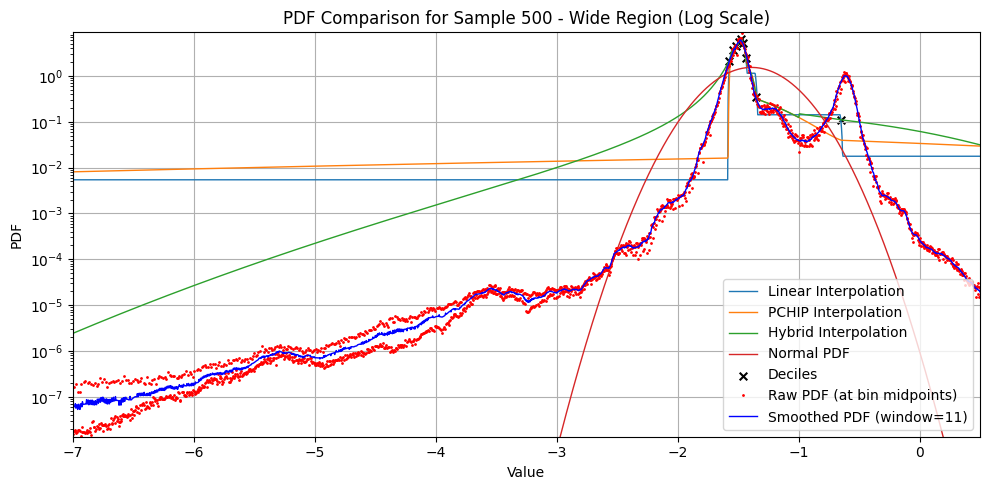

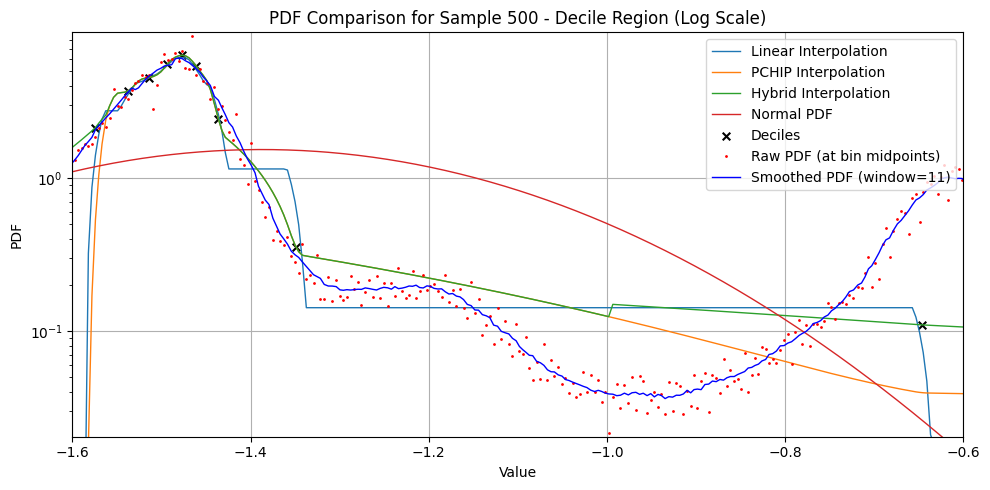

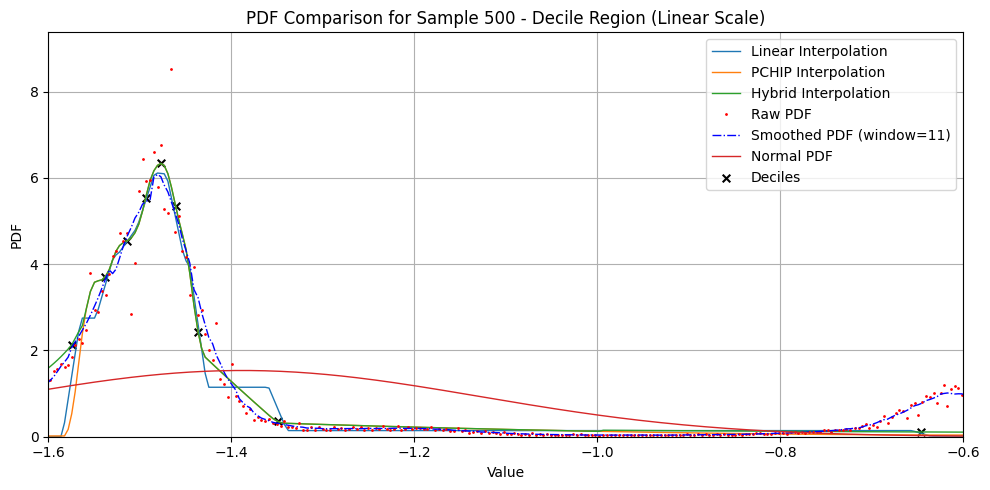

x_min -4.67444417476654
x_max -4.474444174766541
y_all [7.21787444e-07 1.90340256e-06 8.84037718e-07 7.59781699e-07
 2.00242539e-06 8.66984294e-07 9.01303224e-07 2.29555917e-06
 8.04458807e-07 9.34574814e-07 2.15283922e-06 8.94345817e-07
 2.42892338e-06 1.02026502e-06 8.08699497e-07 2.31924378e-06
 9.35707988e-07 7.77531625e-07 2.28813337e-06 9.13843337e-07
 2.26671750e-06 8.96719939e-07 2.68770668e-06 8.47438400e-07
 9.10619690e-07 2.56087833e-06 1.08064160e-06 2.42756505e-06
 9.60075454e-07 1.08913684e-06 2.82227256e-06 9.27138558e-07
 1.07108451e-06 2.84254679e-06 1.01920762e-06 2.89650802e-06
 1.22425934e-06 1.21575090e-06 3.35272762e-06 1.12556643e-06
 1.04060302e-06 3.06917696e-06 1.31530931e-06 3.05995854e-06
 1.30112699e-06 1.26275449e-06 3.51927793e-06 1.26513589e-06
 3.60158879e-06]
y_min 7.217874440357264e-07
y_max 3.601588787205401e-06
y_max_exponent -6
y_max_scaled 3.601588787205401
y_max 3.7
y_max 3.7e-06


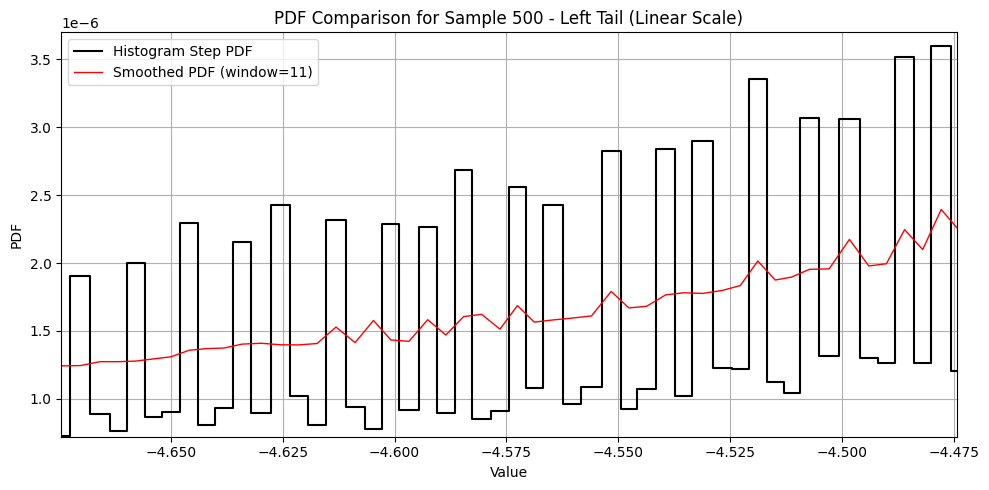

In [ ]:
def plot_pdf_cdf():
    file = 'C:/Users/Minu/Documents/TabPFN/experiments/experiment_1.pkl'
    with open(file, 'rb') as f:
        experiment_1 = pickle.load(f)
        visualization = Visualization(experiment_1)
        visualization.compare_all_pdf_methods(id=500, case=1, window_size=11)
        visualization.compare_all_pdf_methods(id=500, case=2, window_size=11)
        visualization.compare_all_pdf_methods(id=500, case=3, window_size=11)

        #visualization.compare_all_cdf_methods(id=500, case=3, window_size=11)

In [11]:
import pickle
import numpy as np

def load_scores_id_1():
    file = 'C:/Users/Minu/Documents/results/tabpfn/experiment_results_1.pkl'

    with open(file, 'rb') as f:
        experiment_1_results = pickle.load(f)

    nll_df = experiment_1_results[experiment_1_results["Metric"].str.contains("nll")].reset_index(drop=True)
    crps_df = experiment_1_results[experiment_1_results["Metric"].str.contains("crps")].reset_index(drop=True)

    nll_df['Metric'] = nll_df['Metric'].replace('nll_5000', 'nll_5000_smoothed')

    # Optionally, you can do the same for "crps_5000" (if you want to add "smoothed" there too):
    crps_df['Metric'] = crps_df['Metric'].replace('crps_5000', 'crps_5000_smoothed')

    # Inline rounding to 3 significant figures for all numeric columns
    for col in nll_df.select_dtypes(include=[np.number]).columns:
        nll_df[col] = nll_df[col].apply(lambda x: round(x, 3 - int(np.floor(np.log10(abs(x)))) - 1) if x != 0 else 0)

    for col in crps_df.select_dtypes(include=[np.number]).columns:
        crps_df[col] = crps_df[col].apply(lambda x: round(x, 3 - int(np.floor(np.log10(abs(x)))) - 1) if x != 0 else 0)
    
    return nll_df, crps_df

In [12]:
nll_df, crps_df = load_scores_id_1()
#export_scores_id_1_to_latex(nll_df, crps_df)

In [13]:
crps_df

Metric   Mean  Median      Min   Max
0  crps_5000_smoothed  0.317   0.155  0.00473  3.22
1         crps_linear  0.373   0.229  0.08370  2.80
2          crps_pchip  0.331   0.184  0.03630  2.84
3         crps_hybrid  0.315   0.154  0.00659  3.23

In [14]:
nll_df

Metric   Mean  Median   Min    Max
0  nll_5000_smoothed  1.330   0.883 -2.83  11.10
1       nll_5000_raw  1.420   0.979 -3.22  13.20
2         nll_linear  2.120   2.050 -3.04   5.29
3          nll_pchip  1.720   2.630 -3.10   4.48
4         nll_hybrid  0.734   0.499 -3.10  13.50

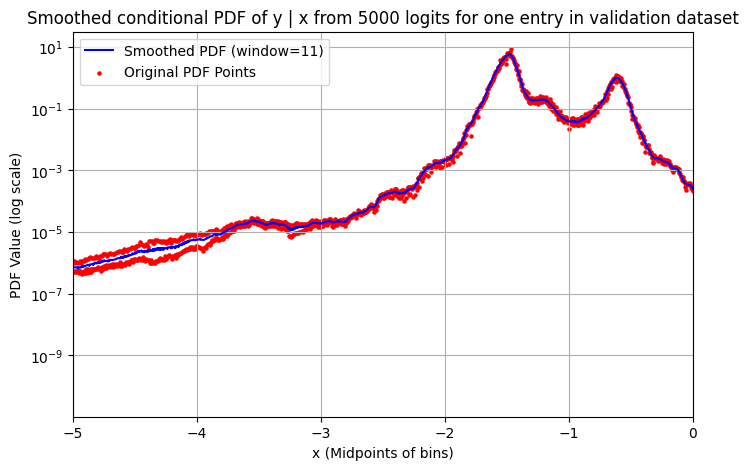

In [ ]:
from analysis.TabPFN_copy import plot_pdf_smoothed_with_moving_average

file = 'C:/Users/Minu/Documents/TabPFN/experiments/experiment_1.pkl'
with open(file, 'rb') as f:
    experiment_1 = pickle.load(f)

logits_old = experiment_1.logits
borders_old = experiment_1.borders

plot_pdf_smoothed_with_moving_average(logits=logits_old, borders=borders_old, window_size=11, id=500, case=1, y_scale="log")

# analysis_2

In [4]:
from analysis.analyses import analysis_2

In [5]:
analysis_2()

CRPS Matrix


23Q1   23Q2   23Q3   23Q4   mean
22Q1  0.317  0.381  0.405  0.289  0.348
22Q2  0.312  0.318  0.361  0.273  0.316
22Q3  0.375  0.315  0.370  0.349  0.352
22Q4  0.328  0.353  0.389  0.303  0.343

NLL Matrix:


23Q1   23Q2   23Q3   23Q4   mean
22Q1  1.329  1.894  2.030  1.369  1.656
22Q2  1.298  1.344  1.521  1.216  1.345
22Q3  1.935  1.359  1.547  1.802  1.661
22Q4  1.802  1.743  1.845  1.708  1.774

(          23Q1      23Q2      23Q3      23Q4      mean
 22Q1  0.317299  0.380875  0.405164  0.288800  0.348034
 22Q2  0.311735  0.317698  0.360742  0.273312  0.315872
 22Q3  0.375394  0.314841  0.370263  0.349182  0.352420
 22Q4  0.328313  0.352974  0.389264  0.302762  0.343328,
           23Q1      23Q2      23Q3      23Q4      mean
 22Q1  1.329454  1.893653  2.030111  1.369362  1.655645
 22Q2  1.298409  1.343537  1.520626  1.215584  1.344539
 22Q3  1.934789  1.359490  1.547410  1.801923  1.660903
 22Q4  1.801825  1.742673  1.845117  1.708153  1.774442)

In [ ]:
crps_matrix, nll_matrix = analysis_2()
export_analysis_2_result_tables_to_latex(
    crps_matrix,
    nll_matrix,
    chapter_tex_path="C:/Users/Minu/OneDrive/Arbeit/HTWG/Master/Masterarbeit/thesis_teamprojekt_templates-master/chapters/analysis_2_result_tables.tex"
)

CRPS Matrix


23Q1   23Q2   23Q3   23Q4   mean
22Q1  0.317  0.381  0.405  0.289  0.348
22Q2  0.312  0.318  0.361  0.273  0.316
22Q3  0.375  0.315  0.370  0.349  0.352
22Q4  0.328  0.353  0.389  0.303  0.343

NLL Matrix:


23Q1   23Q2   23Q3   23Q4   mean
22Q1  1.329  1.894  2.030  1.369  1.656
22Q2  1.298  1.344  1.521  1.216  1.345
22Q3  1.935  1.359  1.547  1.802  1.661
22Q4  1.802  1.743  1.845  1.708  1.774

In [260]:
with open(f"C:/Users/Minu/Documents/TabPFN/experiments/experiment_1.pkl", 'rb') as file:
    exp = pickle.load(file)

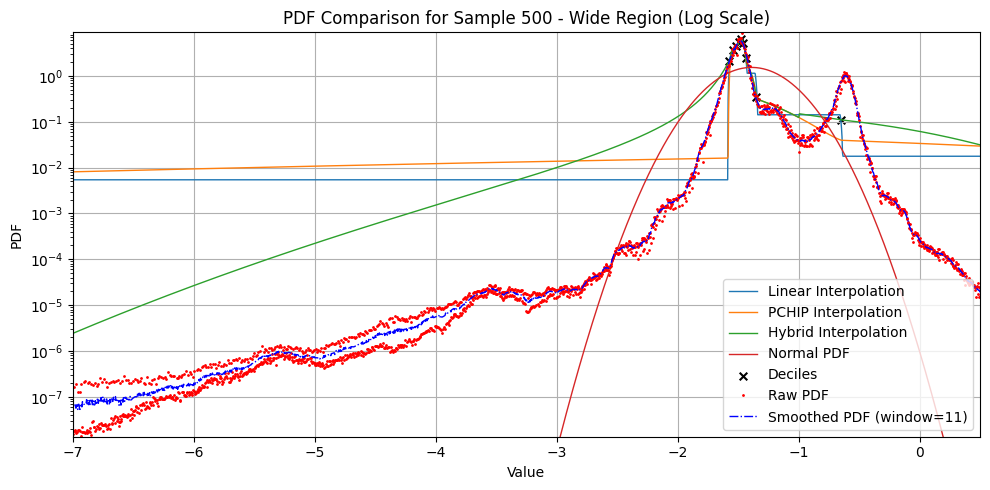

In [263]:
visualization = Visualization(exp)
visualization.compare_all_pdf_methods(id=500, case=1, window_size=11)

In [175]:
def load_all_results():
    nll_mean = []
    crps_mean = []
    # Define the splits and features corresponding to each id (1 to 17)
    splits = [
        "Q1 2022 / Q1 2023", "Q2 2022 / Q2 2023", "Q3 2022 / Q3 2023", "Q4 2022 / Q4 2023",
        "Q4 2022 / Q1 2023", "Q4 2022 / Q2 2023", "Q4 2022 / Q3 2023", "Q4 2022 / H1 2023",
        "Q4 2022 / H2 2023", "Q4 2022 / H1 2023", "Q4 2022 / H2 2023", "Q4 2022 / H1 2023",
        "Q4 2022 / H2 2023", "Q1 2022 / Q2 2023", "Q3 2022 / Q2 2023", "Q1 2022 / Q4 2023", "Q1 2022 / Q3 2023"
    ]

    features = [
        "Base (P(t-96), 2 mean ws)", "Base (P(t-96), 2 mean ws)", "Base (P(t-96), 2 mean ws)", "Base (P(t-96), 2 mean ws)",
        "Base (P(t-96), 2 mean ws)", "Base (P(t-96), 2 mean ws)", "Base (P(t-96), 2 mean ws)", "Base (P(t-96), 10 ws)",
        "Base (P(t-96), 10 ws)", "Base (P(t-96), 2 mean+10 ws)", "Base (P(t-96), 2 mean+10 ws)", "Base (all)",
        "Base (all)", "Base (P(t-96), 2 mean ws)", "Base (P(t-96), 2 mean ws)", "Base (P(t-96), 2 mean ws)", "Base (P(t-96), 2 mean ws)"
    ]

    for i in range(1, 18):
        with open(f"C:/Users/Minu/Documents/TabPFN/experiments/experiment_results_{i}.pkl", 'rb') as file:
            df = pickle.load(file)
            nll_mean.append((df['Metric'].iloc[0], df['Mean'].iloc[0], splits[i - 1], features[i - 1]))
            crps_mean.append((df['Metric'].iloc[1], df['Mean'].iloc[1], splits[i - 1], features[i - 1]))

    # Create dataframes with extra columns
    nll_means_df = pd.DataFrame(nll_mean, columns=['Metric', 'Mean', 'Split', 'Feature Set'])
    crps_means_df = pd.DataFrame(crps_mean, columns=['Metric', 'Mean', 'Split', 'Feature Set'])

    # Set index to start at 1
    nll_means_df.index = range(1, len(nll_means_df) + 1)
    crps_means_df.index = range(1, len(crps_means_df) + 1)

    return nll_means_df, crps_means_df

In [176]:
nll_means_df, crps_means_df = load_all_results()

In [177]:
nll_means_df.sort_values("Split").sort_values("Feature Set")

Metric      Mean              Split                   Feature Set
9   nll_5000  0.670290  Q4 2022 / H2 2023         Base (P(t-96), 10 ws)
8   nll_5000  0.776125  Q4 2022 / H1 2023         Base (P(t-96), 10 ws)
1   nll_5000  1.329454  Q1 2022 / Q1 2023     Base (P(t-96), 2 mean ws)
6   nll_5000  1.742673  Q4 2022 / Q2 2023     Base (P(t-96), 2 mean ws)
5   nll_5000  1.801825  Q4 2022 / Q1 2023     Base (P(t-96), 2 mean ws)
7   nll_5000  1.845117  Q4 2022 / Q3 2023     Base (P(t-96), 2 mean ws)
4   nll_5000  1.708153  Q4 2022 / Q4 2023     Base (P(t-96), 2 mean ws)
15  nll_5000  1.359490  Q3 2022 / Q2 2023     Base (P(t-96), 2 mean ws)
2   nll_5000  1.343537  Q2 2022 / Q2 2023     Base (P(t-96), 2 mean ws)
16  nll_5000  1.369362  Q1 2022 / Q4 2023     Base (P(t-96), 2 mean ws)
17  nll_5000  2.030111  Q1 2022 / Q3 2023     Base (P(t-96), 2 mean ws)
14  nll_5000  1.893653  Q1 2022 / Q2 2023     Base (P(t-96), 2 mean ws)
3   nll_5000  1.547410  Q3 2022 / Q3 2023     Base (P(t-96), 2 mean ws)
11  nll_5000  0.659593  Q4 2022 / H2 2023  Base (P(t-96), 2 mean+10 ws)
10  nll_5000  0.779610  Q4 2022 / H1 2023  Base (P(t-96), 2 mean+10 ws)
12  nll_5000  0.766891  Q4 2022 / H1 2023                    Base (all)
13  nll_5000  0.631045  Q4 2022 / H2 2023                    Base (all)

In [178]:
crps_means_df.sort_values("Split").sort_values("Feature Set")

Metric      Mean              Split                   Feature Set
9   crps_5000  0.203517  Q4 2022 / H2 2023         Base (P(t-96), 10 ws)
8   crps_5000  0.201723  Q4 2022 / H1 2023         Base (P(t-96), 10 ws)
1   crps_5000  0.317299  Q1 2022 / Q1 2023     Base (P(t-96), 2 mean ws)
6   crps_5000  0.352974  Q4 2022 / Q2 2023     Base (P(t-96), 2 mean ws)
5   crps_5000  0.328313  Q4 2022 / Q1 2023     Base (P(t-96), 2 mean ws)
7   crps_5000  0.389264  Q4 2022 / Q3 2023     Base (P(t-96), 2 mean ws)
4   crps_5000  0.302762  Q4 2022 / Q4 2023     Base (P(t-96), 2 mean ws)
15  crps_5000  0.314841  Q3 2022 / Q2 2023     Base (P(t-96), 2 mean ws)
2   crps_5000  0.317698  Q2 2022 / Q2 2023     Base (P(t-96), 2 mean ws)
16  crps_5000  0.288800  Q1 2022 / Q4 2023     Base (P(t-96), 2 mean ws)
17  crps_5000  0.405164  Q1 2022 / Q3 2023     Base (P(t-96), 2 mean ws)
14  crps_5000  0.380875  Q1 2022 / Q2 2023     Base (P(t-96), 2 mean ws)
3   crps_5000  0.370263  Q3 2022 / Q3 2023     Base (P(t-96), 2 mean ws)
11  crps_5000  0.204729  Q4 2022 / H2 2023  Base (P(t-96), 2 mean+10 ws)
10  crps_5000  0.202282  Q4 2022 / H1 2023  Base (P(t-96), 2 mean+10 ws)
12  crps_5000  0.199081  Q4 2022 / H1 2023                    Base (all)
13  crps_5000  0.201143  Q4 2022 / H2 2023                    Base (all)

In [143]:
crps_means_df.sort_values(by="Mean")

Metric      Mean              Split                   Feature Set
12  crps_5000  0.199081  Q4 2022 / H1 2023                    Base (all)
13  crps_5000  0.201143  Q4 2022 / H2 2023                    Base (all)
8   crps_5000  0.201723  Q4 2022 / H1 2023         Base (P(t-96), 10 ws)
10  crps_5000  0.202282  Q4 2022 / H1 2023  Base (P(t-96), 2 mean+10 ws)
9   crps_5000  0.203517  Q4 2022 / H2 2023         Base (P(t-96), 10 ws)
11  crps_5000  0.204729  Q4 2022 / H2 2023  Base (P(t-96), 2 mean+10 ws)
16  crps_5000  0.288800  Q1 2022 / Q4 2023     Base (P(t-96), 2 mean ws)
4   crps_5000  0.302762  Q4 2022 / Q4 2023     Base (P(t-96), 2 mean ws)
15  crps_5000  0.314841  Q3 2022 / Q2 2023     Base (P(t-96), 2 mean ws)
1   crps_5000  0.317299  Q1 2022 / Q1 2023     Base (P(t-96), 2 mean ws)
2   crps_5000  0.317698  Q2 2022 / Q2 2023     Base (P(t-96), 2 mean ws)
5   crps_5000  0.328313  Q4 2022 / Q1 2023     Base (P(t-96), 2 mean ws)
6   crps_5000  0.352974  Q4 2022 / Q2 2023     Base (P(t-96), 2 mean ws)
3   crps_5000  0.370263  Q3 2022 / Q3 2023     Base (P(t-96), 2 mean ws)
14  crps_5000  0.380875  Q1 2022 / Q2 2023     Base (P(t-96), 2 mean ws)
7   crps_5000  0.389264  Q4 2022 / Q3 2023     Base (P(t-96), 2 mean ws)

In [119]:
first_experiment = experiment_tracker.experiments[0]
first_experiment.calculate_crps_with_interpolator(method="normal")

Initializing Interpolator objects...
created 8640 CDFPDFInterpolator objects
CRPS at sample 100: 0.804644644114663
CRPS at sample 200: 0.08503669897538035
CRPS at sample 300: 0.023643129075883697
CRPS at sample 400: 0.05127848308828706
CRPS at sample 500: 0.04091979590529284
CRPS at sample 600: 0.22285168047448467
CRPS at sample 700: 0.09603367851644197
CRPS at sample 800: 0.1434004313921329
CRPS at sample 900: 0.06913200683843701
CRPS at sample 1000: 0.07279953034103465
CRPS at sample 1100: 0.04448158948776619
CRPS at sample 1200: 0.03995996490268367
CRPS at sample 1300: 0.11332002187742377
CRPS at sample 1400: 0.015267729034829348
CRPS at sample 1500: 0.07811118901488304
CRPS at sample 1600: 0.30354690638194515
CRPS at sample 1700: 0.44022604829275513
CRPS at sample 1800: 0.09228720609909274
CRPS at sample 1900: 1.416197168735721
CRPS at sample 2000: 0.08765801110890468
CRPS at sample 2100: 0.8620406177066752
CRPS at sample 2200: 0.44112913019395006
CRPS at sample 2300: 0.46156112719

0.31547589023432593

In [97]:
first_experiment = experiment_tracker.experiments[0]
first_experiment.calculate_crps_with_interpolator(method="hybrid")

Initializing Interpolator objects...
created 8640 CDFPDFInterpolator objects
CRPS at sample 100: 0.805238580449249
CRPS at sample 200: 0.09684442156938795
CRPS at sample 300: 0.11779839552610197
CRPS at sample 400: 0.19885754925183124
CRPS at sample 500: 0.048006209030290035
CRPS at sample 600: 0.209298437703506
CRPS at sample 700: 0.1289846961597626
CRPS at sample 800: 0.17131400292848106
CRPS at sample 900: 0.11398983835666311
CRPS at sample 1000: 0.1840902356943987
CRPS at sample 1100: 0.19908237648321722
CRPS at sample 1200: 0.1495408731169541
CRPS at sample 1300: 0.21592681859272123
CRPS at sample 1400: 0.23803008566760323
CRPS at sample 1500: 0.1280927167547471
CRPS at sample 1600: 0.30666822900600166
CRPS at sample 1700: 0.4169639690911382
CRPS at sample 1800: 0.15791264026319568
CRPS at sample 1900: 1.3906697270440018
CRPS at sample 2000: 0.19061497798942373
CRPS at sample 2100: 0.7527935732448625
CRPS at sample 2200: 0.47857841947399227
CRPS at sample 2300: 0.510970183241318
C

C:\Users\Minu\AppData\Local\Temp\ipykernel_21236\2826350178.py:516: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  crps_2, _ = quad(integrand_2, y, dist.y_max, epsabs=1e-6, epsrel=1e-6)


CRPS at sample 3300: 0.20441708758447785
CRPS at sample 3400: 0.3968628607680905
CRPS at sample 3500: 0.9557592389034393
CRPS at sample 3600: 0.8593951307128724
CRPS at sample 3700: 0.18998590554486175
CRPS at sample 3800: 0.9131539309682051
CRPS at sample 3900: 0.06772299266139385
CRPS at sample 4000: 0.16608865629728967
CRPS at sample 4100: 0.057040481596946344
CRPS at sample 4200: 0.41404692780646685
CRPS at sample 4300: 0.2633804058939454
CRPS at sample 4400: 0.27643415873119
CRPS at sample 4500: 0.09179225601214722
CRPS at sample 4600: 0.2371085276354461
CRPS at sample 4700: 0.7545135319732784
CRPS at sample 4800: 0.08671532299857615
CRPS at sample 4900: 0.22119848446840285
CRPS at sample 5000: 2.3243517249233276
CRPS at sample 5100: 0.05167778917597229
CRPS at sample 5200: 0.08772897058624325
CRPS at sample 5300: 0.20702988513057974
CRPS at sample 5400: 0.15961443934285313
CRPS at sample 5500: 0.2005172485375083
CRPS at sample 5600: 0.059134590741552924
CRPS at sample 5700: 0.912

0.3588375156597421

1 quarter:
hybrid cdf crps mean: 0.3588375919441313, time: 00:39:32,9
hybrid cdf crps mean (with quad(integrand, a, b, epsabs=1e-6, epsrel=1e-6)): 0.3588375156597421, time: 00:26:08,2

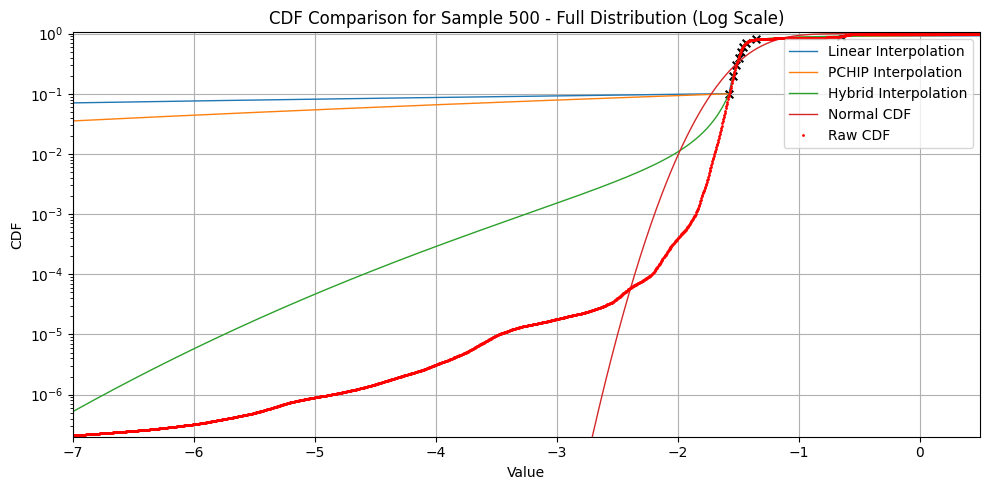

In [416]:
first_experiment = experiment_tracker.experiments[0]
visualization = Visualization(first_experiment)
visualization.compare_all_cdf_methods(id=500, case=1, window_size=1)

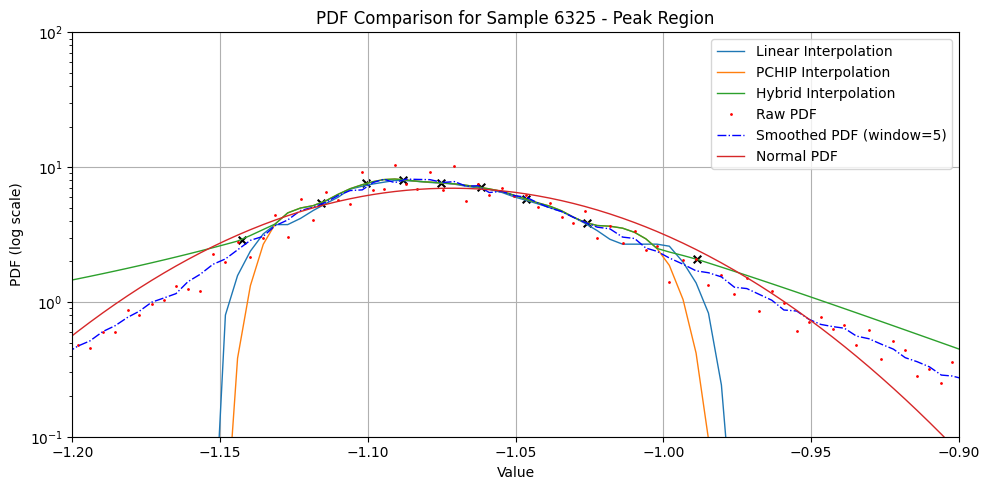

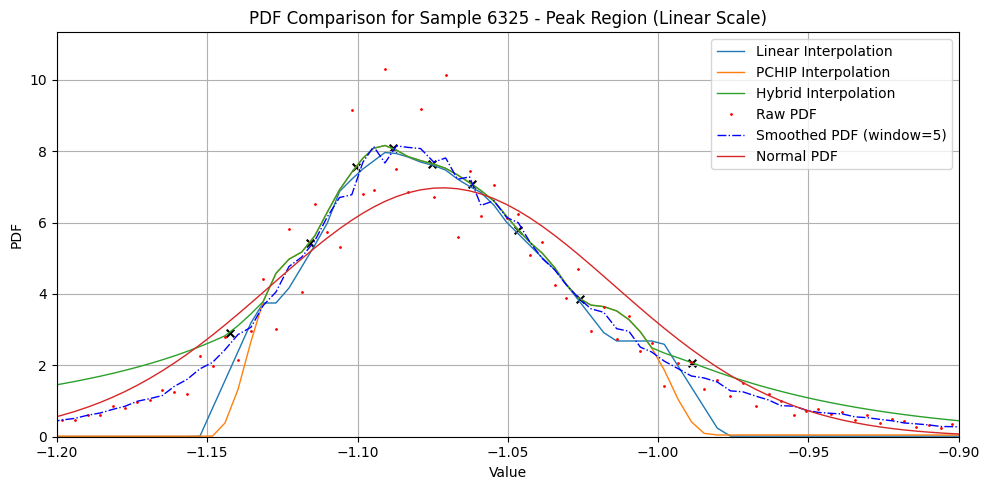

In [326]:
first_experiment = experiment_tracker.experiments[0]
visualization = Visualization(first_experiment)

visualization.compare_all_pdf_methods(id=6325, case=2, window_size=5)


In [286]:
first_experiment.quantiles[6325]

AttributeError: 'Experiment' object has no attribute 'quantiles'

In [255]:
first_experiment.borders[3150:3180]

array([1.1417646, 1.1457207, 1.149745 , 1.1537738, 1.1579709, 1.1623371,
       1.1660221, 1.1701517, 1.1739461, 1.1779532, 1.1822121, 1.18648  ,
       1.1901586, 1.1939898, 1.1980398, 1.2014778, 1.2052591, 1.209198 ,
       1.21294  , 1.2168484, 1.220422 , 1.224482 , 1.2279894, 1.2318614,
       1.2362576, 1.2401149, 1.2441015, 1.2487376, 1.2529588, 1.2566833],
      dtype=float32)

In [197]:
first_experiment.deciles[0,:]

array([-0.5826782 , -0.5207051 , -0.34270877, -0.14433199, -0.13002725,
       -0.1217458 , -0.11556388, -0.10760765, -0.097819  ], dtype=float32)

## CRPS

In [21]:
first_experiment = experiment_tracker.experiments[0]
crps_smooth = first_experiment.calculate_crps(smoothing=True, window_size=101)

In [22]:
crps_smooth

array([[0.19343302],
       [0.23937029],
       [0.17951393],
       ...,
       [0.29911354],
       [0.38602894],
       [0.52318811]])

In [23]:
first_experiment = experiment_tracker.experiments[0]
crps_raw = first_experiment.calculate_crps(smoothing=False, window_size=9)

In [24]:
crps_raw

array([[0.20791832],
       [0.27250862],
       [0.18532322],
       ...,
       [0.31509954],
       [0.40639508],
       [0.5398042 ]], dtype=float32)

In [26]:
pd.DataFrame((crps_smooth-crps_raw)/crps_raw).describe()

0
count  8640.000000
mean      0.253983
std       1.159557
min      -0.389375
25%      -0.066061
50%      -0.020652
75%       0.085281
max      44.610900

In [27]:
diff_indices = np.where(crps_raw != crps_smooth)
print("Differing indices:", diff_indices)
print("a values:", crps_raw[diff_indices])
print("b values:", crps_smooth[diff_indices])


Differing indices: (array([   0,    1,    2, ..., 8637, 8638, 8639], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64))
a values: [0.20791832 0.27250862 0.18532322 ... 0.31509954 0.40639508 0.5398042 ]
b values: [0.19343302 0.23937029 0.17951393 ... 0.29911354 0.38602894 0.52318811]


In [24]:
experiment_tracker.experiments.hists[0]._pdf(0.5)

AttributeError: 'list' object has no attribute 'hists'

In [33]:
cdf_pdf_int = CDFPDFInterpolator(first_experiment.deciles[0,:], np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))
-np.log(cdf_pdf_int.pdf_hybrid(-0.539165))

Middle Region -> PDF Value: 2.0815805188459455


-0.7331274699918923

## NLL

In [58]:
first_experiment = experiment_tracker.experiments[0]
first_experiment.calculate_nll(smoothing=True, window_size=9)

1.3397589684645619

Total_nll = 1.0813564938862656: ws: 51, time: 00:01:28.7
Total_nll = 1.3397589684645619: ws: 9, time: 00:01:10.9

In [ ]:
y_value_0 = -0.539165
y_value_1  = -0.518601
y_value_2  = -0.555433
y_value_3 = -0.509552
y_value_4 = -0.552363
y_value_8635 = -1.343460
y_value_8636 = -1.336049
y_value_8637 = -1.332029
y_value_8638 = -1.319186
y_value_8639 = -1.300872

first_experiment = experiment_tracker.experiments[0]
hist_no = 1

first_experiment_hist = first_experiment.hists[hist_no]
nll = - first_experiment_hist._logpdf(y_value_0)
nll

0.13027282529814713

In [20]:
nlls = []
first_experiment = experiment_tracker.experiments[0]
y_values = first_experiment.y_validation.values

for i in range(50):
    nll = - first_experiment.hists[i]._logpdf(y_values[i])
    print(nll)
    nlls.append(nll)

np.mean(nlls)


-0.5907407803693503
0.6743962702651448
-1.0875192810092291
-0.6495249195244523
-0.8671361977411826
-0.6224068609495985
-1.4315809761190796
0.6795231172821641
-0.4793050675434087
1.4477815248294603
2.266061952395148
4.559026716874197
4.603079898952111
5.077595636071363
4.92346276378966
2.784780182471966
0.746544107387711
0.721926059836194
0.7781959156999156
0.017311242036649906
0.0290754646021366
0.1858840989603783
0.99740709551462
0.9825833260007815
1.134476890220424
1.0555011034486763
0.994469841075949
1.8848244058181212
1.417324923722216
1.6876316844539205
2.1480806753404273
2.7263694464182566
3.780712509895339
2.1314669988776314
2.1564410309351496
2.1654786732260973
2.2756197753965197
1.7056677079848004
2.9238431983656032
2.5765960060037547
1.2870036746675593
1.1432033840931752
1.6206191234035323
2.374647249117083
1.5504038671870815
2.9695426788588666
4.008003844981532
4.91604363915696
4.723680696849942
3.9644835189393106


1.7413711567630241

In [39]:
first_experiment.calculate_crps_with_interpolator

AttributeError: 'Experiment' object has no attribute 'calculate_crps_with_interpolator'

In [16]:
len(first_experiment.hists)

8640

In [15]:
first_experiment.y_validation.values

array([-0.53916458, -0.51860087, -0.55543337, ..., -1.33202902,
       -1.31918562, -1.30087248])

## CRPS

In [69]:
y_value_0 = -0.539165
y_value_1  = -0.518601
y_value_2  = -0.555433
y_value_3 = -0.509552
y_value_4 = -0.552363
y_value_8635 = -1.343460
y_value_8636 = -1.336049
y_value_8637 = -1.332029
y_value_8638 = -1.319186
y_value_8639 = -1.300872

first_experiment.hists_smoothed()[0].crps(np.array([y_value_0]))  #hists_smoothed() because it is a function

array([0.20791832], dtype=float32)

In [ ]:
first_experiment.hists[0].crps(np.array([y_value_0]))

array([0.20791832], dtype=float32)

In [39]:
hist_no = 2
first_experiment = experiment_tracker.experiments[0]
first_experiment_hist = first_experiment.hists[hist_no]
first_experiment_hist.crps(np.array([y_value_2]))

array([0.18532322], dtype=float32)

 ...]

In [60]:
hist_no = 2
first_experiment = experiment_tracker.experiments[0]
first_experiment_hist = first_experiment.hists_smoothed[hist_no]
#first_experiment_hist.crps(np.array([y_value_2]))

TypeError: 'method' object is not subscriptable

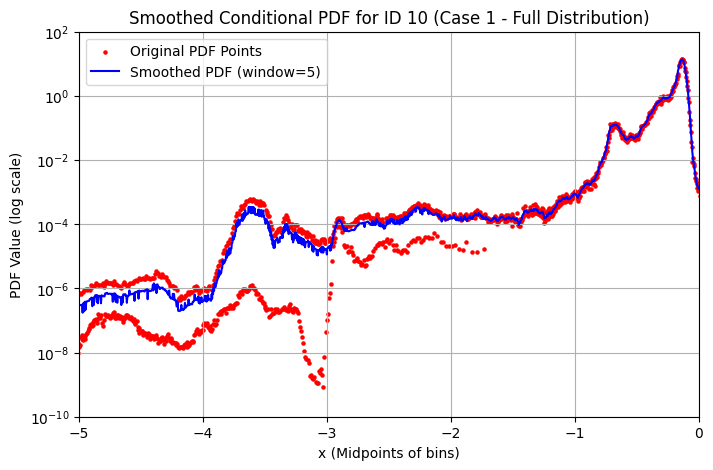

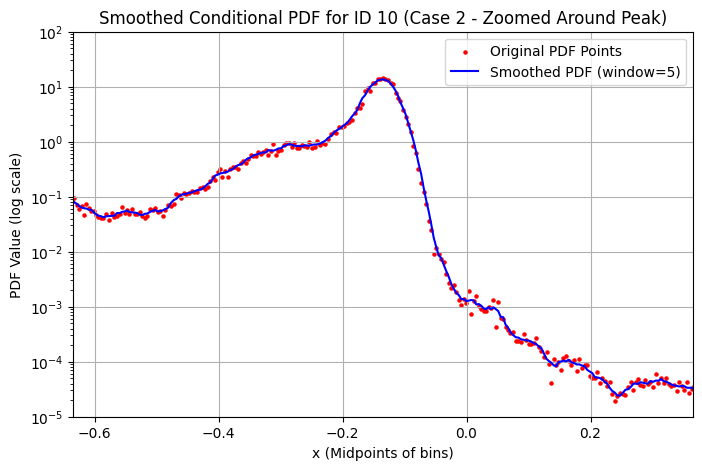

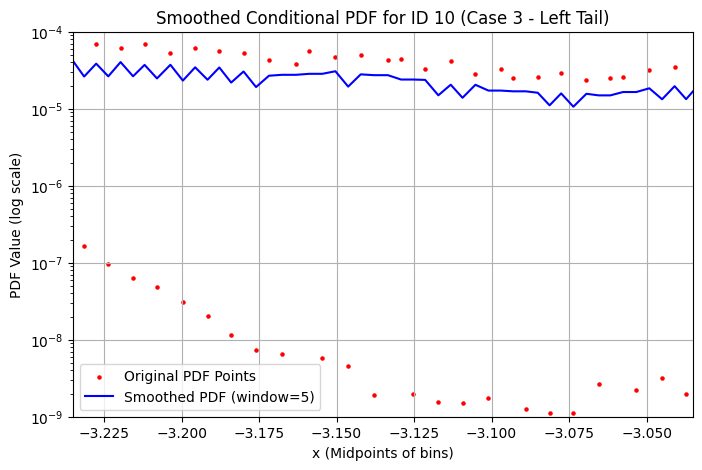

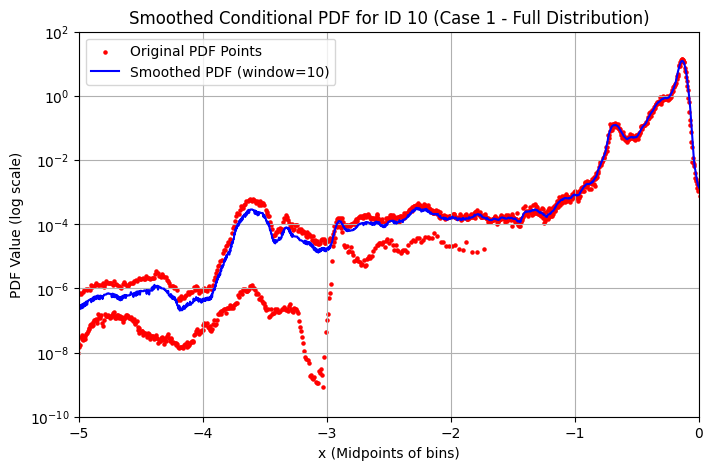

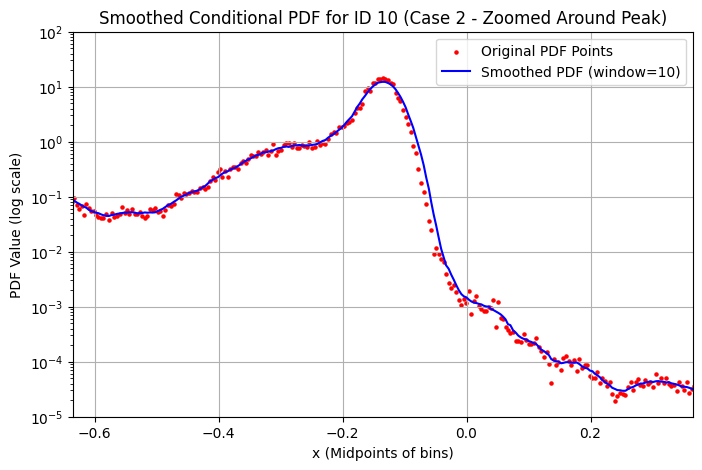

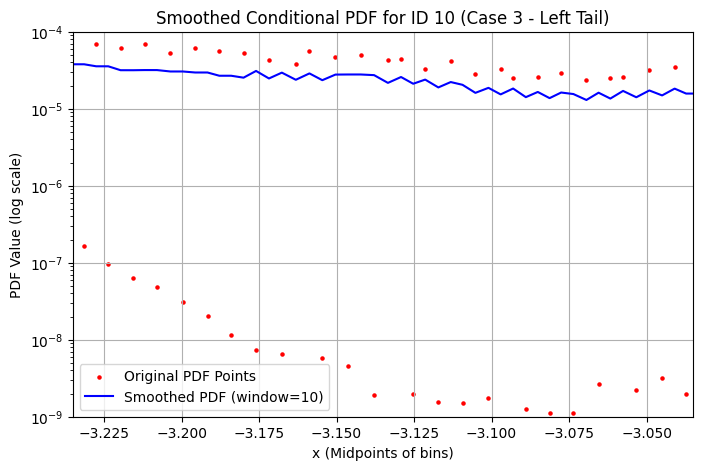

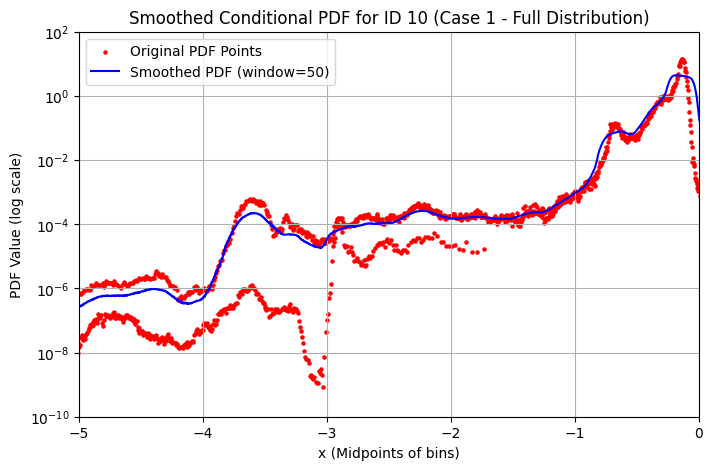

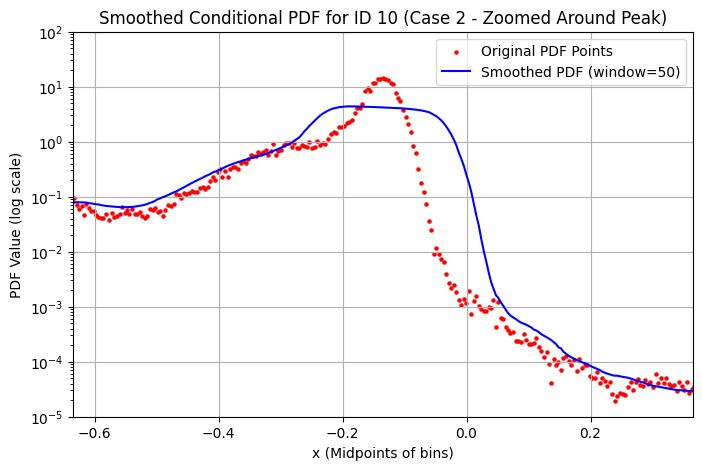

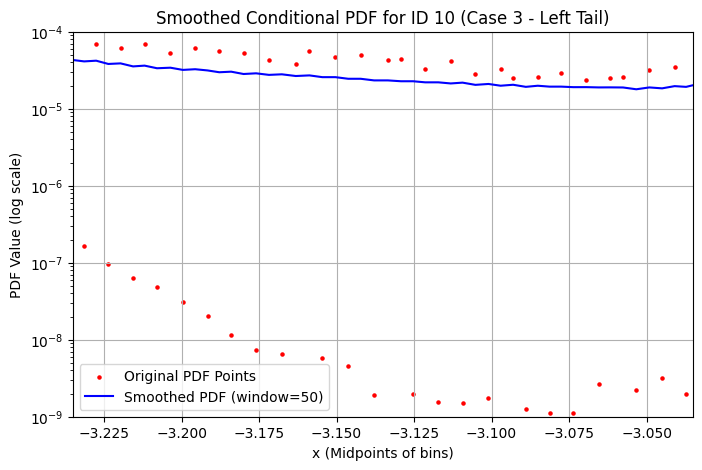

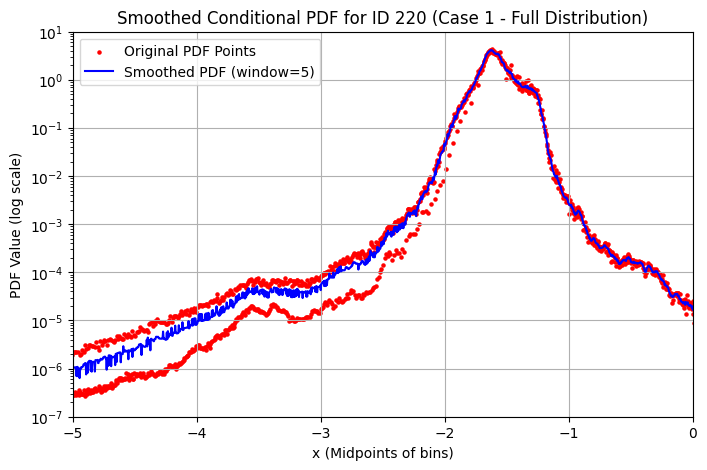

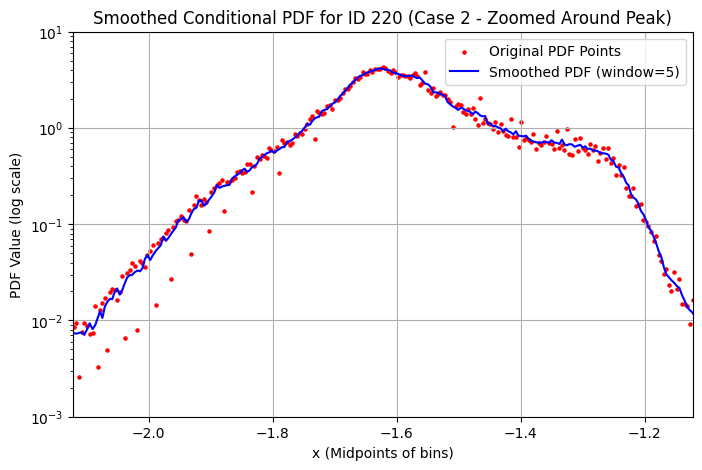

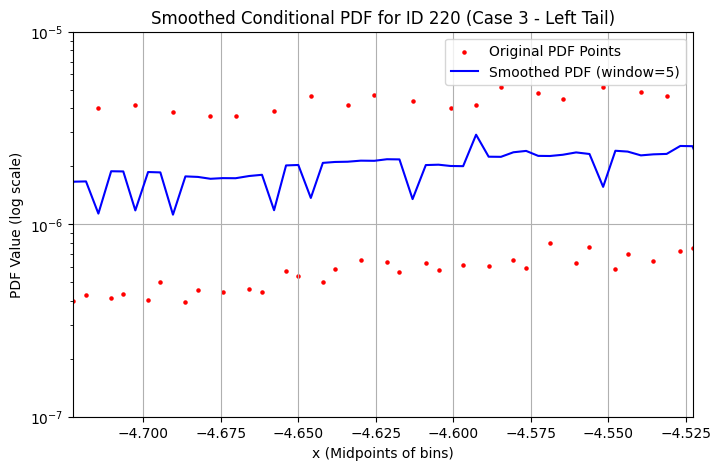

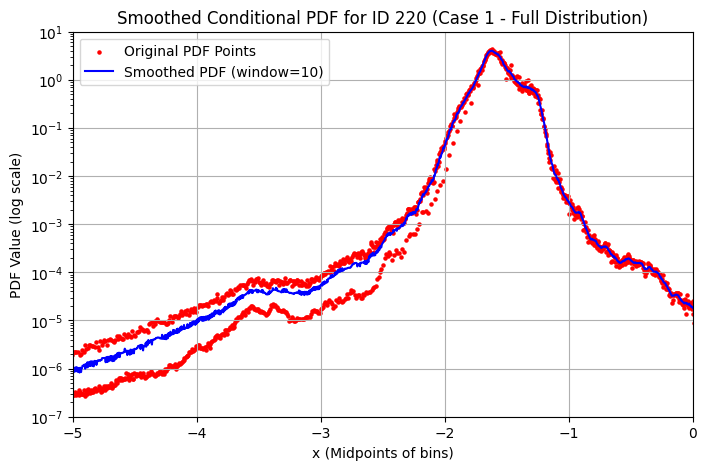

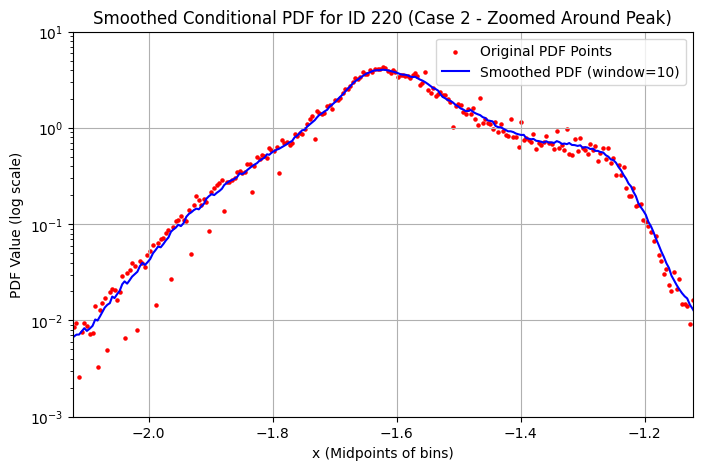

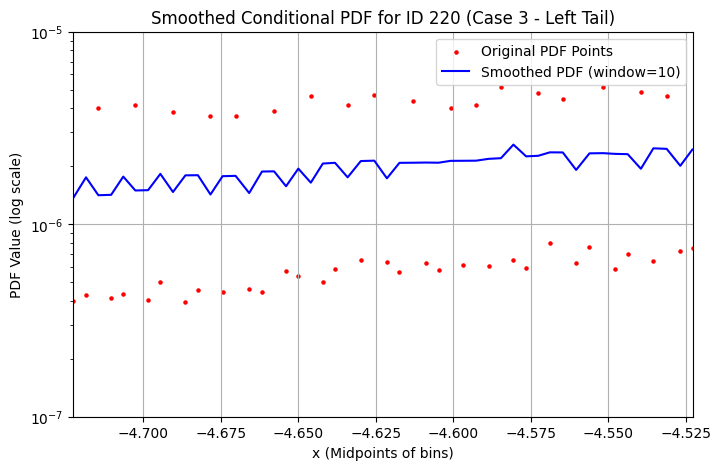

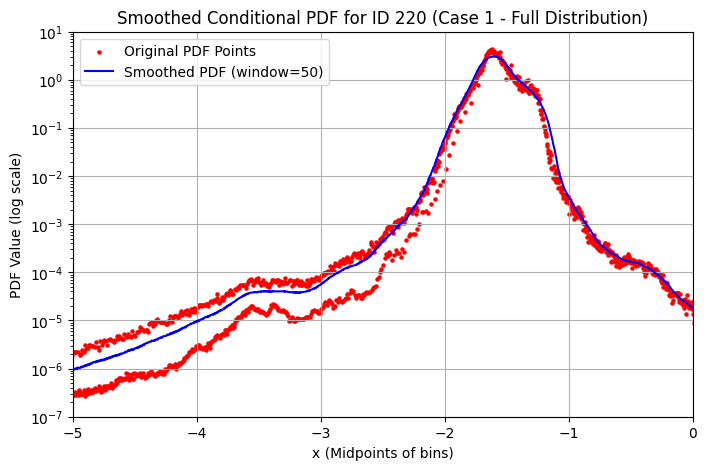

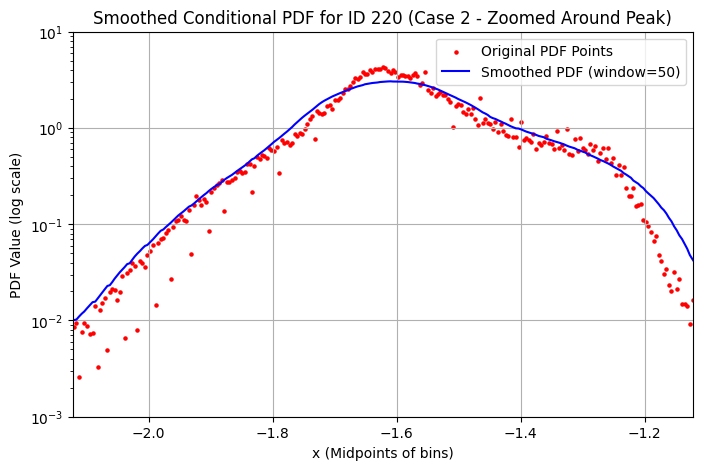

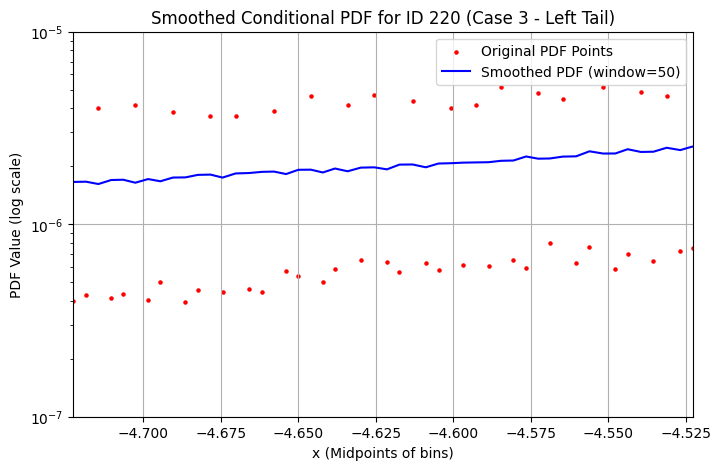

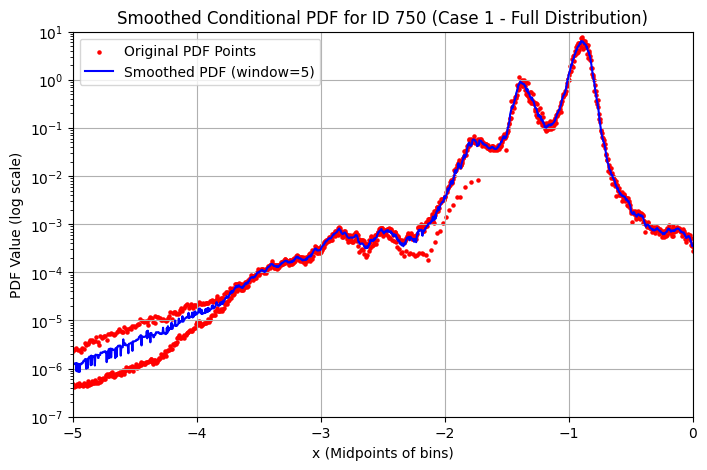

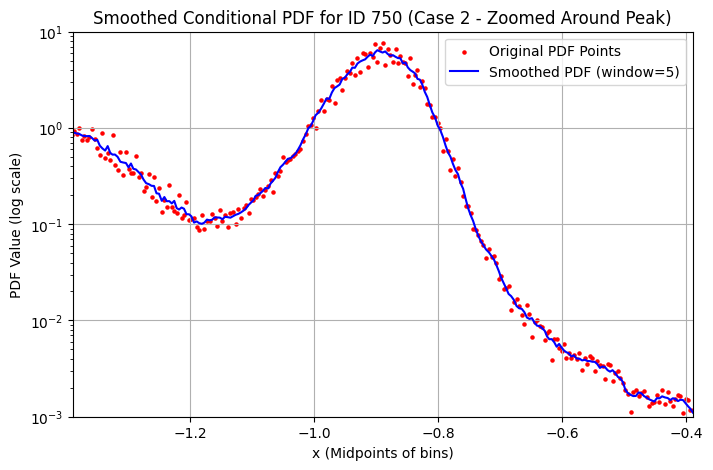

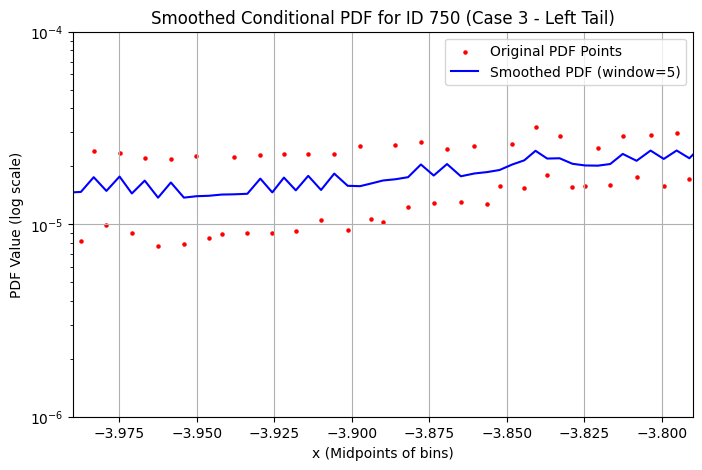

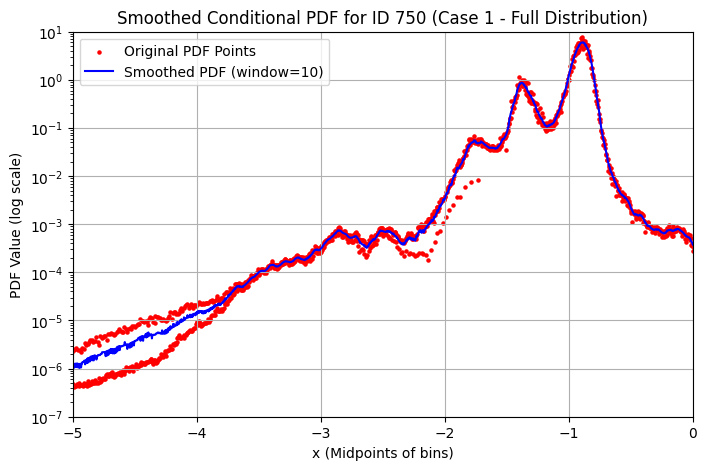

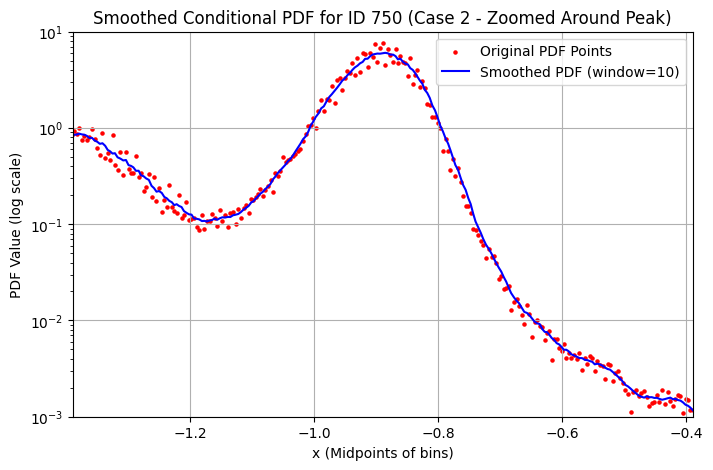

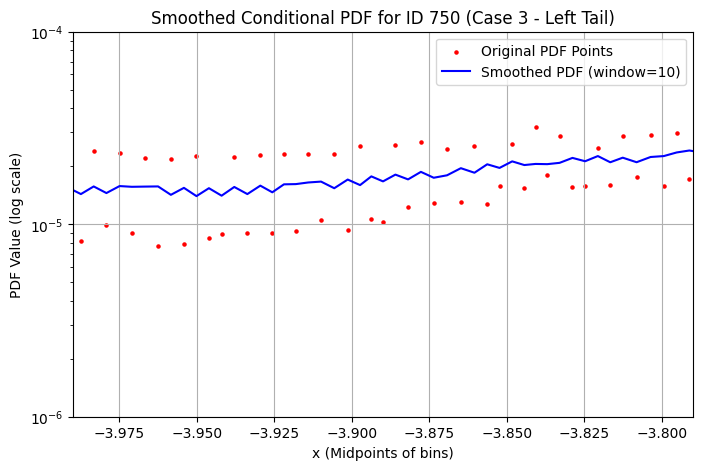

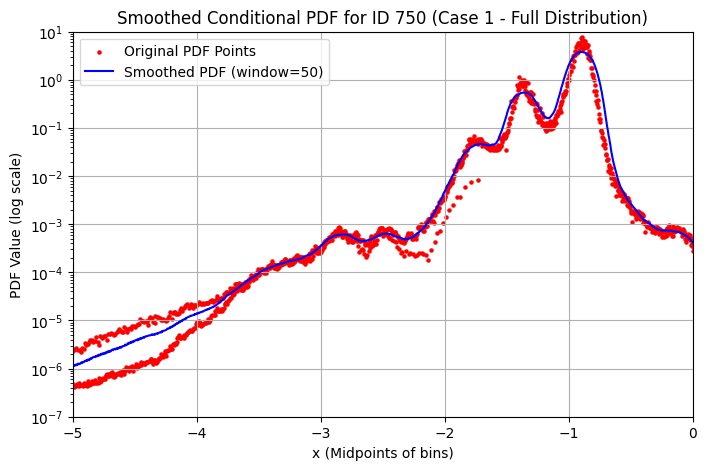

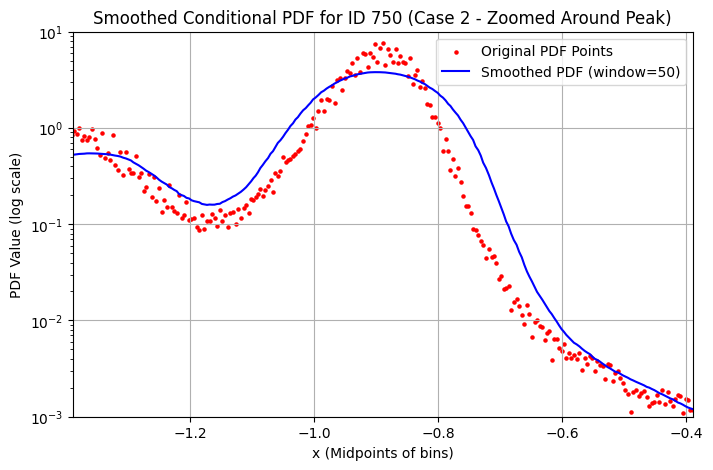

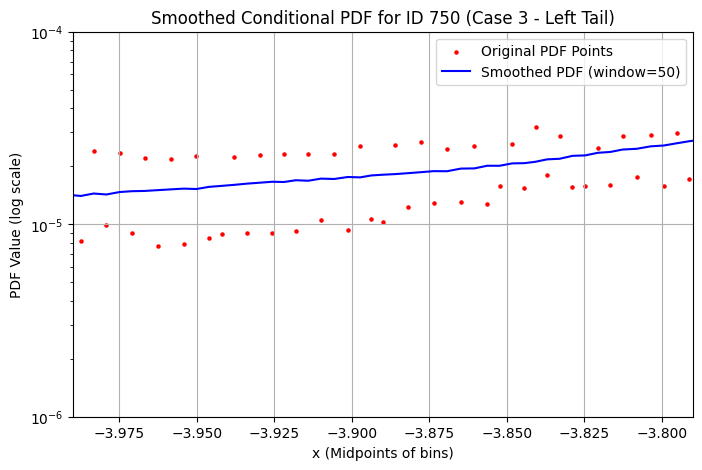

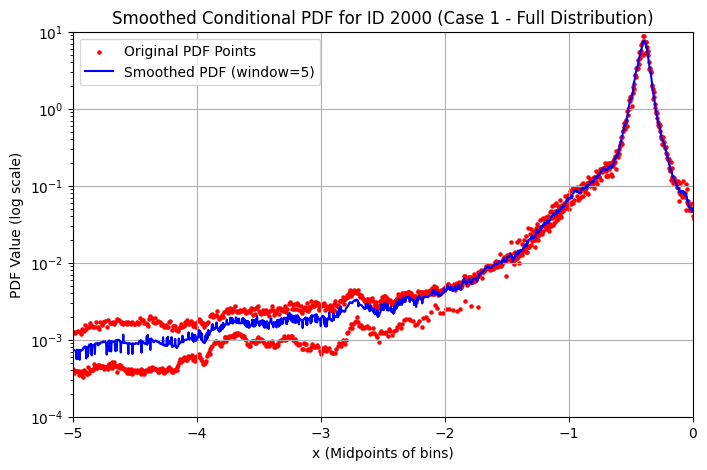

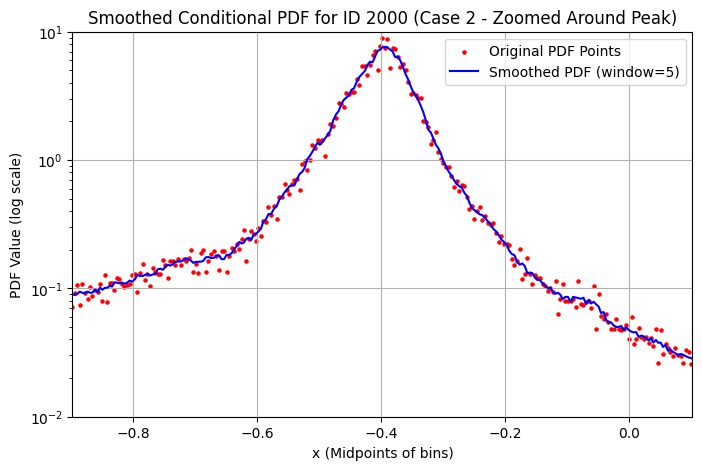

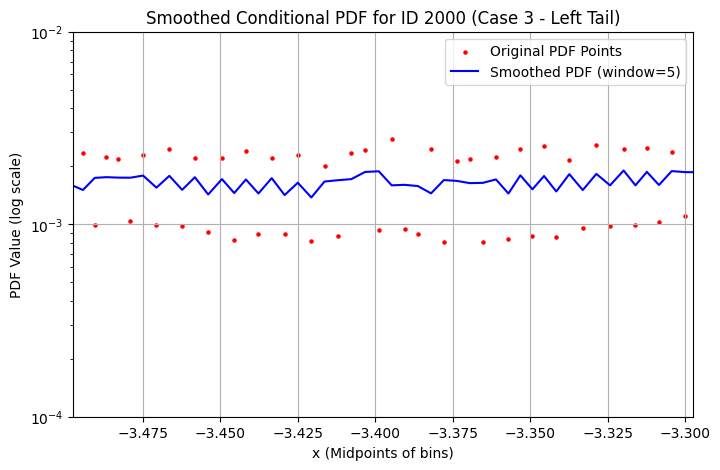

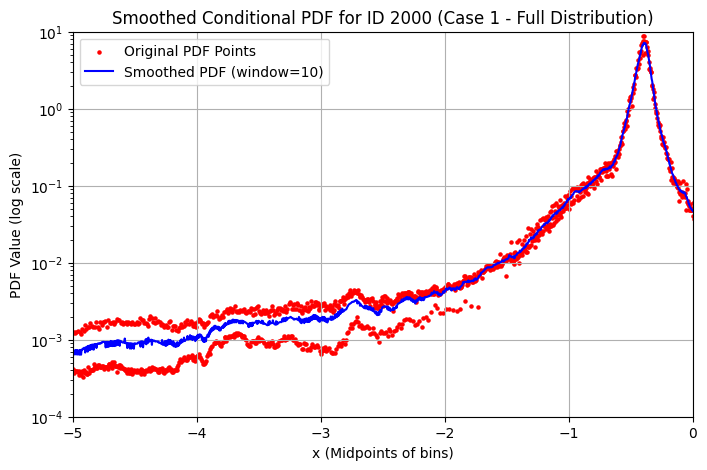

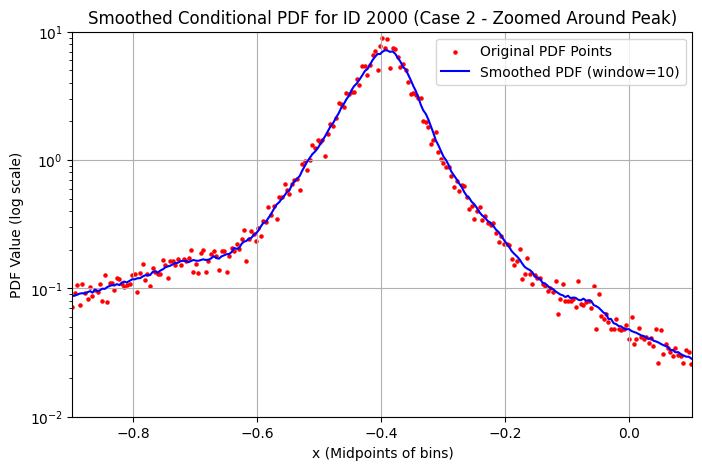

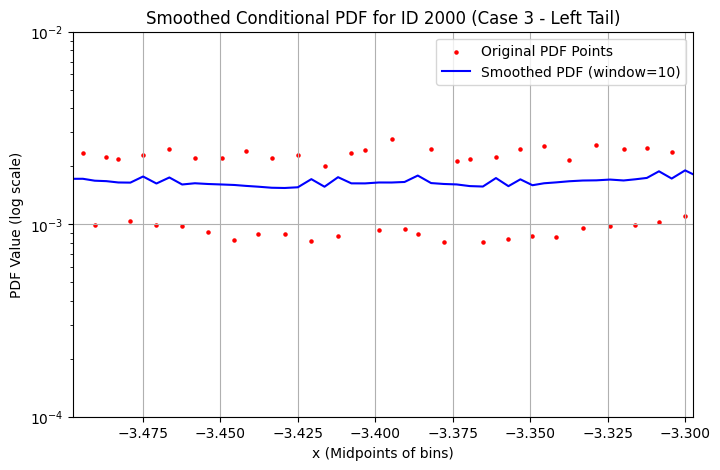

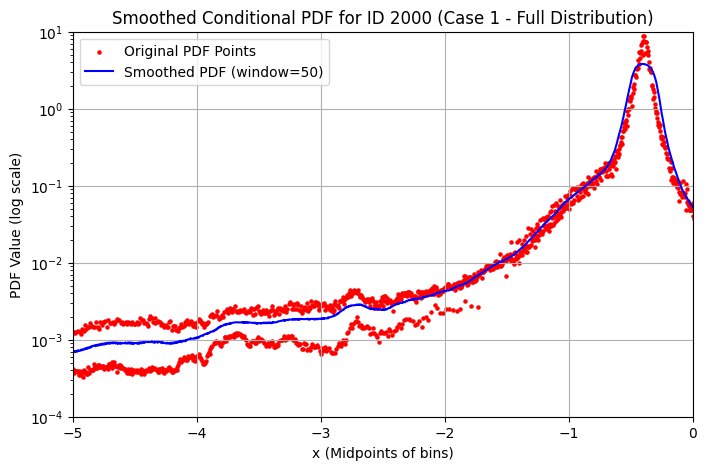

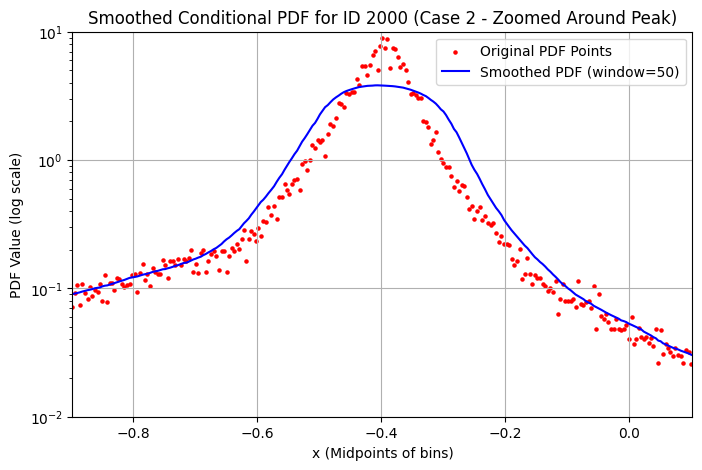

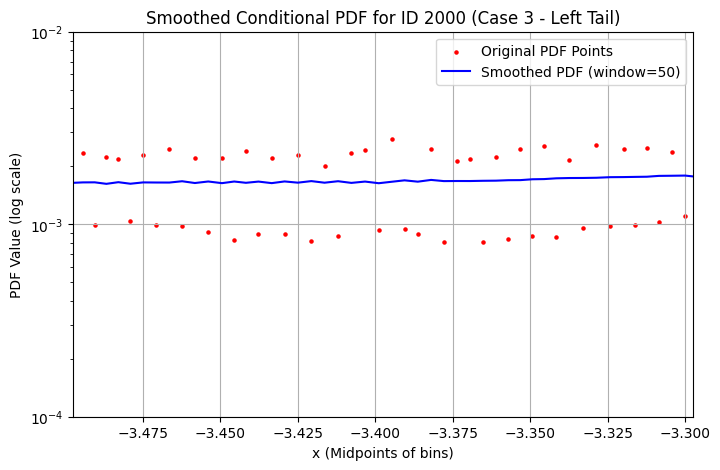

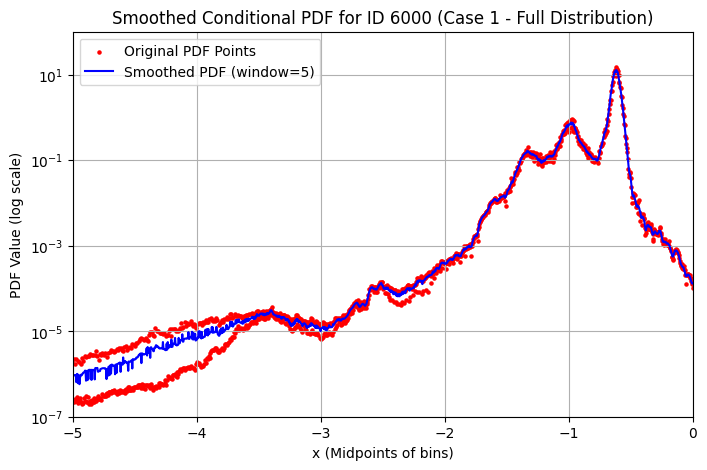

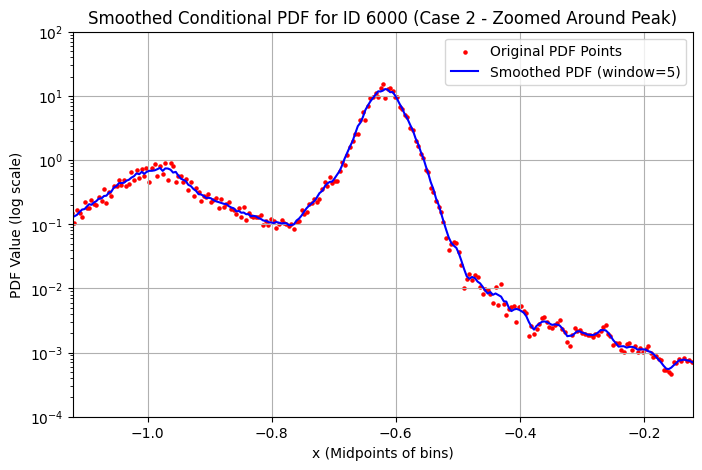

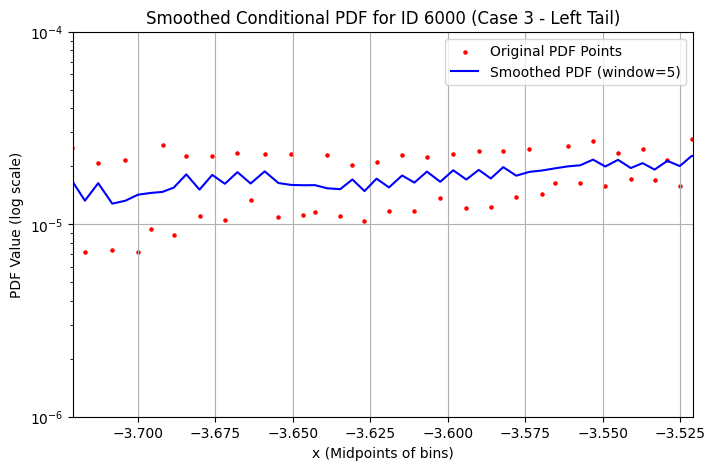

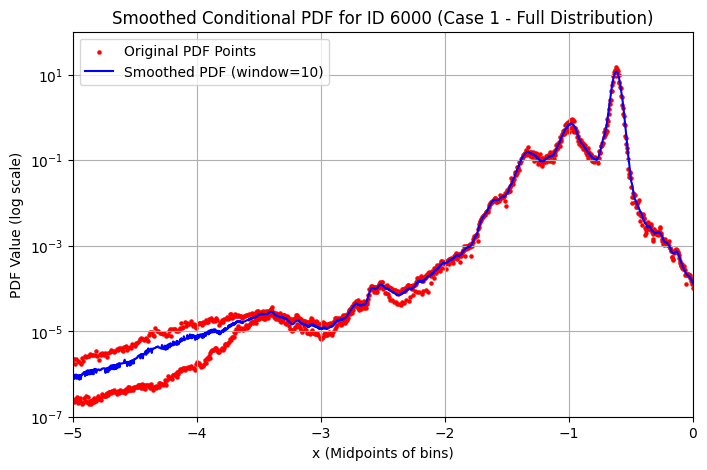

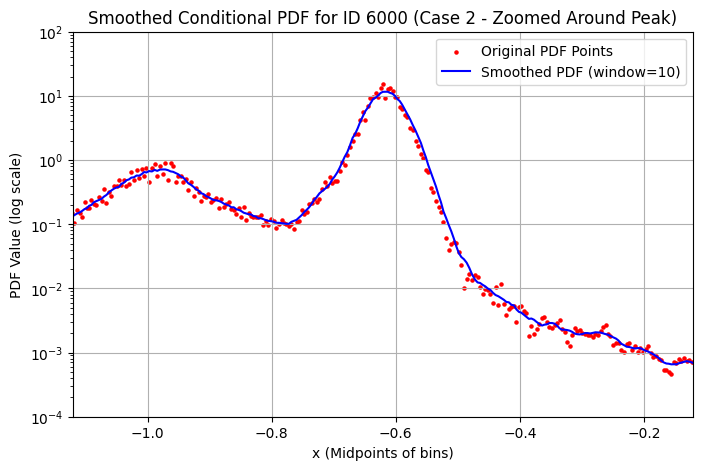

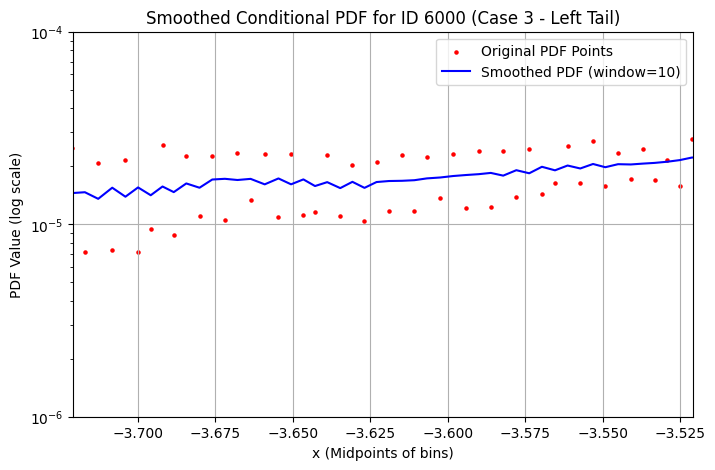

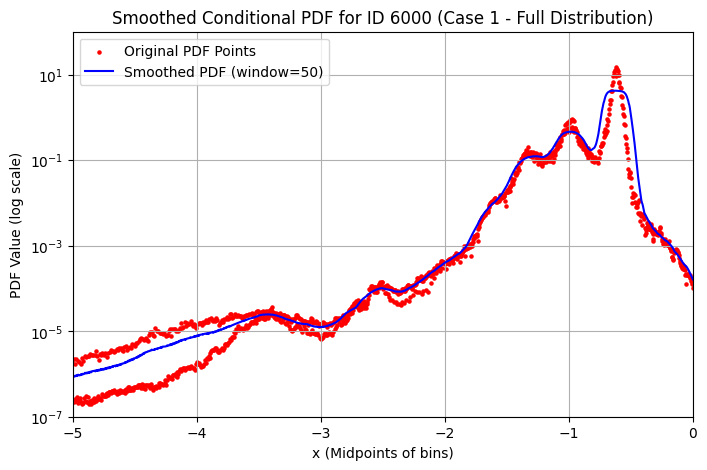

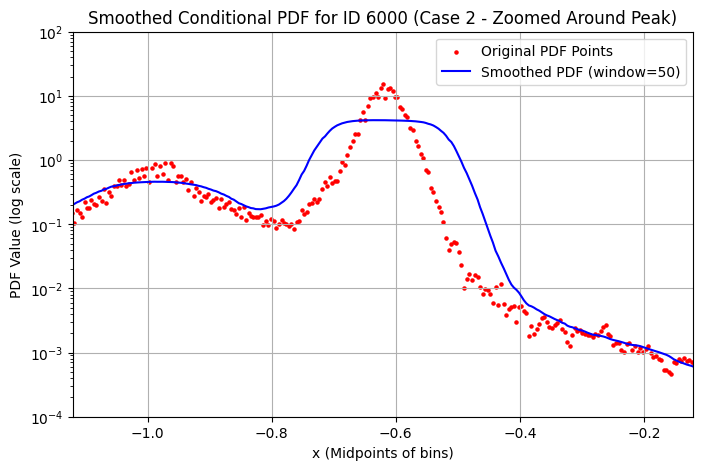

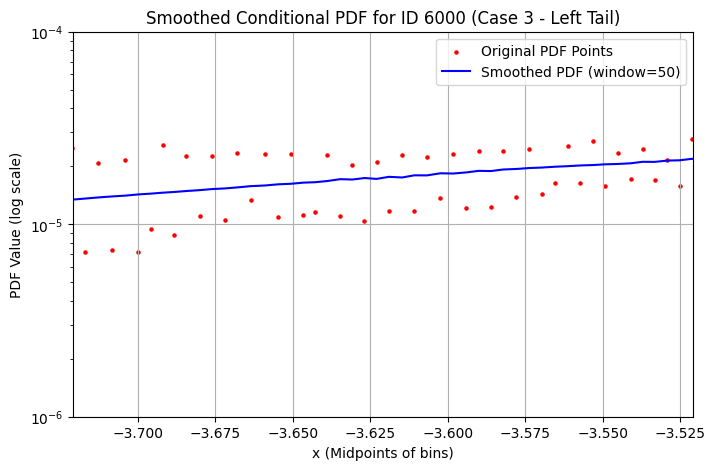

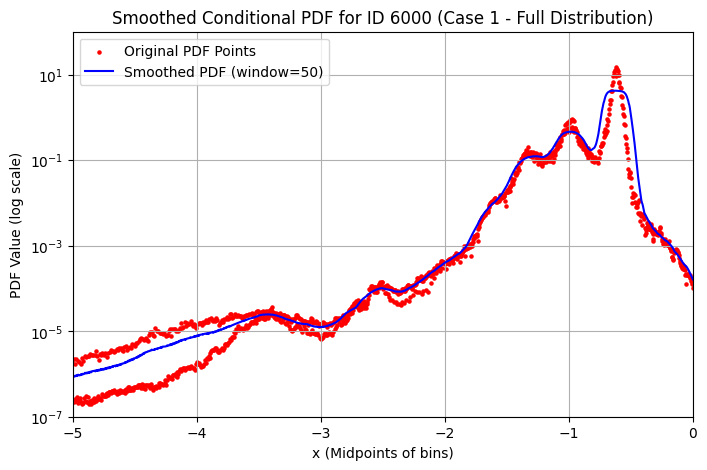

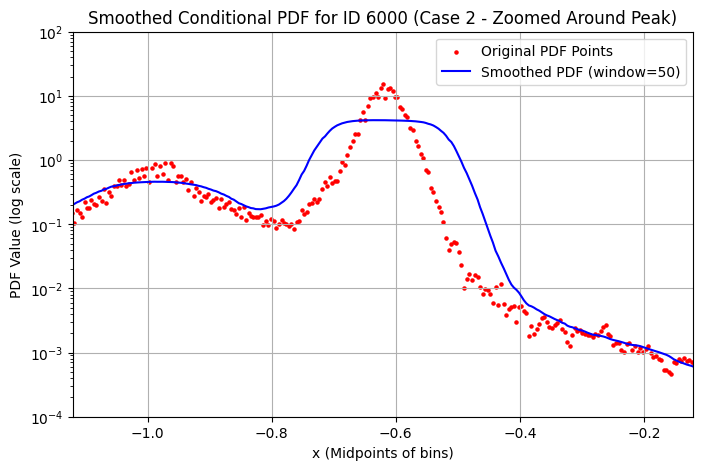

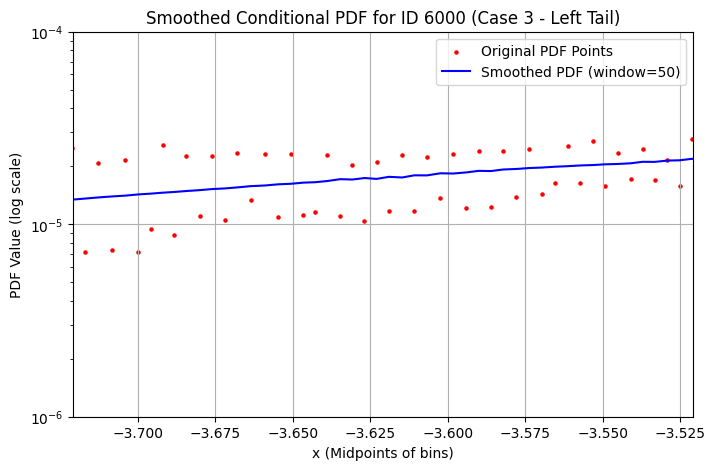

In [ ]:
ids = [10, 220, 750, 2000, 6000]
window_sizes = [5, 10, 50]

visualization = Visualization(experiment)


for id in ids:
    for window_size in window_sizes:
        visualization.plot_smoothed_pdf(id=id, window_size=window_size)


visualization.plot_smoothed_pdf(id=id, window_size=window_size)

# Alt

tabPFN_pipeline(
    feature_list=["ws_10m_loc_mean", "ws_100m_loc_mean", "power_t-96"], 
    transform=True, 
    train_start_date="2016-01-01", 
    train_end_date="2016-03-31",
    validation_start_date="2023-01-01"
    validation_end_date="2023-03-31"
    window_size=9,
    device="auto",
    "fit_mode"="low_memory",
    random_state=42,
    ignore_pretraining_limits=False
    ):
        1. prepare_data(feature_list, transform=True/False)
            - load_entsoe() --> entsoe
            - transform_power_data(entsoe)
            - add_interval_index(entsoe)
            - add_lagged_feature(entsoe)
            - prepare_features(feature_list)

        2. to_train_validation_test_data(entsoe, train_start_date, train_end_date, validation_start_date, validation_end_date) --> X_train, y_train, X_validation, y_validation

        3. train_tabpfn(X_train, y_train, X_validation, y_validation, device=device, fit_mode=fit_mode, random_state= random_state, ignore_pretraining_limits=ignore_pretraining_limits)
        --> raw_results, meta_info

        4. enrich_tabpfn_output(raw_results, meta_info) --> raw_results, meta_info, function for raw pdf, raw cdf, pdf_smoothed written to file

evaluate_tabpfn(
    

)


# def prepare_data(feature_list: str, scale=True):

### 1. load_entsoe()
--> returns DataFrame

In [1]:
from analysis.splits import to_train_validation_test_data
from analysis.datasets import load_entsoe

entsoe = load_entsoe()
entsoe.head(3)

Data loaded and transformed successfully. Shape of DataFrame: (78912, 22)


power  ws_10m_loc_1  ws_10m_loc_10  ws_10m_loc_2  \
time                                                                     
2016-01-01 00:00:00  1428.0          1.90         2.4800         2.410   
2016-01-01 00:15:00  1379.0          1.93         2.5525         2.445   
2016-01-01 00:30:00  1399.0          1.96         2.6250         2.480   

                     ws_10m_loc_3  ws_10m_loc_4  ws_10m_loc_5  ws_10m_loc_6  \
time                                                                          
2016-01-01 00:00:00        1.9700         2.480          1.80         1.800   
2016-01-01 00:15:00        1.9625         2.515          1.78         1.795   
2016-01-01 00:30:00        1.9550         2.550          1.76         1.790   

                     ws_10m_loc_7  ws_10m_loc_8  ...  ws_100m_loc_10  \
time                                             ...                   
2016-01-01 00:00:00         1.860          2.20  ...          5.0500   
2016-01-01 00:15:00         1.895          2.21  ...          5.1675   
2016-01-01 00:30:00         1.930          2.22  ...          5.2850   

                     ws_100m_loc_2  ws_100m_loc_3  ws_100m_loc_4  \
time                                                               
2016-01-01 00:00:00          5.160          4.860          5.710   
2016-01-01 00:15:00          5.245          4.825          5.775   
2016-01-01 00:30:00          5.330          4.790          5.840   

                     ws_100m_loc_5  ws_100m_loc_6  ws_100m_loc_7  \
time                                                               
2016-01-01 00:00:00         5.0000         4.4700          4.330   
2016-01-01 00:15:00         4.9575         4.4725          4.365   
2016-01-01 00:30:00         4.9150         4.4750          4.400   

                     ws_100m_loc_8  ws_100m_loc_9  ws_100m_loc_mean  
time                                                                 
2016-01-01 00:00:00         4.2700          5.020            4.5200  
2016-01-01 00:15:00         4.2975          5.075            4.5625  
2016-01-01 00:30:00         4.3250          5.130            4.6050  

[3 rows x 23 columns]

### 2. transform_power_data(entsoe: DataFrame, target_column='power')
--> returns DataFrame with log-transformed power column

In [2]:
import numpy as np

def transform_power(df, target_column='power'):
    """Scales the power data using log transformation."""
    max_power_value = df[target_column].max()
    max_power_value_rounded = np.ceil(max_power_value / 1000) * 1000
    #epsilon = 1e-9
    epsilon = 1e-3
    df[target_column] = np.log(df[target_column] / max_power_value_rounded + epsilon)
    return df

entsoe_transformed = transform_power(entsoe)
entsoe_transformed.head(3)

power  ws_10m_loc_1  ws_10m_loc_10  ws_10m_loc_2  \
time                                                                       
2016-01-01 00:00:00 -2.465104          1.90         2.4800         2.410   
2016-01-01 00:15:00 -2.499602          1.93         2.5525         2.445   
2016-01-01 00:30:00 -2.485377          1.96         2.6250         2.480   

                     ws_10m_loc_3  ws_10m_loc_4  ws_10m_loc_5  ws_10m_loc_6  \
time                                                                          
2016-01-01 00:00:00        1.9700         2.480          1.80         1.800   
2016-01-01 00:15:00        1.9625         2.515          1.78         1.795   
2016-01-01 00:30:00        1.9550         2.550          1.76         1.790   

                     ws_10m_loc_7  ws_10m_loc_8  ...  ws_100m_loc_10  \
time                                             ...                   
2016-01-01 00:00:00         1.860          2.20  ...          5.0500   
2016-01-01 00:15:00         1.895          2.21  ...          5.1675   
2016-01-01 00:30:00         1.930          2.22  ...          5.2850   

                     ws_100m_loc_2  ws_100m_loc_3  ws_100m_loc_4  \
time                                                               
2016-01-01 00:00:00          5.160          4.860          5.710   
2016-01-01 00:15:00          5.245          4.825          5.775   
2016-01-01 00:30:00          5.330          4.790          5.840   

                     ws_100m_loc_5  ws_100m_loc_6  ws_100m_loc_7  \
time                                                               
2016-01-01 00:00:00         5.0000         4.4700          4.330   
2016-01-01 00:15:00         4.9575         4.4725          4.365   
2016-01-01 00:30:00         4.9150         4.4750          4.400   

                     ws_100m_loc_8  ws_100m_loc_9  ws_100m_loc_mean  
time                                                                 
2016-01-01 00:00:00         4.2700          5.020            4.5200  
2016-01-01 00:15:00         4.2975          5.075            4.5625  
2016-01-01 00:30:00         4.3250          5.130            4.6050  

[3 rows x 23 columns]

### 3. add_interval_index(df: DataFrame)
--> returns DataFrame with new column "interval_index which is an integer representing 15-minute intervals

In [3]:
def add_interval_index(df):
    """Creates an interval index feature based on time."""
    df['interval_index'] = ((df.index.hour * 60 + df.index.minute) // 15) + 1
    return df

entsoe_int = add_interval_index(entsoe_transformed)
entsoe_int.head(3)

power  ws_10m_loc_1  ws_10m_loc_10  ws_10m_loc_2  \
time                                                                       
2016-01-01 00:00:00 -2.465104          1.90         2.4800         2.410   
2016-01-01 00:15:00 -2.499602          1.93         2.5525         2.445   
2016-01-01 00:30:00 -2.485377          1.96         2.6250         2.480   

                     ws_10m_loc_3  ws_10m_loc_4  ws_10m_loc_5  ws_10m_loc_6  \
time                                                                          
2016-01-01 00:00:00        1.9700         2.480          1.80         1.800   
2016-01-01 00:15:00        1.9625         2.515          1.78         1.795   
2016-01-01 00:30:00        1.9550         2.550          1.76         1.790   

                     ws_10m_loc_7  ws_10m_loc_8  ...  ws_100m_loc_2  \
time                                             ...                  
2016-01-01 00:00:00         1.860          2.20  ...          5.160   
2016-01-01 00:15:00         1.895          2.21  ...          5.245   
2016-01-01 00:30:00         1.930          2.22  ...          5.330   

                     ws_100m_loc_3  ws_100m_loc_4  ws_100m_loc_5  \
time                                                               
2016-01-01 00:00:00          4.860          5.710         5.0000   
2016-01-01 00:15:00          4.825          5.775         4.9575   
2016-01-01 00:30:00          4.790          5.840         4.9150   

                     ws_100m_loc_6  ws_100m_loc_7  ws_100m_loc_8  \
time                                                               
2016-01-01 00:00:00         4.4700          4.330         4.2700   
2016-01-01 00:15:00         4.4725          4.365         4.2975   
2016-01-01 00:30:00         4.4750          4.400         4.3250   

                     ws_100m_loc_9  ws_100m_loc_mean  interval_index  
time                                                                  
2016-01-01 00:00:00          5.020            4.5200               1  
2016-01-01 00:15:00          5.075            4.5625               2  
2016-01-01 00:30:00          5.130            4.6050               3  

[3 rows x 24 columns]

### 4. add_lagged_features(df: DataFrame, target_column='power', lag=96)
--> returns DataFrame with new lagged feature column

In [4]:
def add_lagged_features(df, target_column='power', lag=96):
    """Adds lagged power feature."""
    df[f'{target_column}_t-{lag}'] = df[target_column].shift(lag)
    df = df.dropna()
    return df

entsoe_final = add_lagged_features(entsoe_int)
entsoe_final.head(3)

power  ws_10m_loc_1  ws_10m_loc_10  ws_10m_loc_2  \
time                                                                       
2016-01-02 00:00:00 -3.324236        2.7200           1.68        2.6400   
2016-01-02 00:15:00 -3.238179        2.7975           1.74        2.6625   
2016-01-02 00:30:00 -3.171487        2.8750           1.80        2.6850   

                     ws_10m_loc_3  ws_10m_loc_4  ws_10m_loc_5  ws_10m_loc_6  \
time                                                                          
2016-01-02 00:00:00        3.1400         3.110         3.210          3.11   
2016-01-02 00:15:00        3.1325         3.185         3.235          3.11   
2016-01-02 00:30:00        3.1250         3.260         3.260          3.11   

                     ws_10m_loc_7  ws_10m_loc_8  ...  ws_100m_loc_3  \
time                                             ...                  
2016-01-02 00:00:00          2.63        2.6500  ...           5.39   
2016-01-02 00:15:00          2.65        2.7025  ...           5.40   
2016-01-02 00:30:00          2.67        2.7550  ...           5.41   

                     ws_100m_loc_4  ws_100m_loc_5  ws_100m_loc_6  \
time                                                               
2016-01-02 00:00:00          5.200         5.8700          5.650   
2016-01-02 00:15:00          5.315         5.8825          5.645   
2016-01-02 00:30:00          5.430         5.8950          5.640   

                     ws_100m_loc_7  ws_100m_loc_8  ws_100m_loc_9  \
time                                                               
2016-01-02 00:00:00           4.87           4.52           5.32   
2016-01-02 00:15:00           4.81           4.64           5.33   
2016-01-02 00:30:00           4.75           4.76           5.34   

                     ws_100m_loc_mean  interval_index  power_t-96  
time                                                               
2016-01-02 00:00:00              5.19               1   -2.465104  
2016-01-02 00:15:00              5.16               2   -2.499602  
2016-01-02 00:30:00              5.13               3   -2.485377  

[3 rows x 25 columns]

### 5. prepare_features(df: pd.DataFrame, features: list)
--> returns DataFrame (containing only the selected features)

In [5]:
import pandas as pd


def prepare_features(df: pd.DataFrame, features: list):
    """
    Selects only the specified features from the given DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    features (list): A list of column names to be selected.

    Returns:
    pd.DataFrame: A DataFrame containing only the selected features.
    """

    features.append("power")
    return df[features] if all(feature in df.columns for feature in features) else df[[feature for feature in features if feature in df.columns]]

entsoe_prepared = prepare_features(entsoe_final, ["ws_10m_loc_mean", "ws_100m_loc_mean", "power_t-96"])
entsoe_prepared

ws_10m_loc_mean  ws_100m_loc_mean  power_t-96     power
time                                                                        
2016-01-02 00:00:00           2.8300             5.190   -2.465104 -3.324236
2016-01-02 00:15:00           2.8250             5.160   -2.499602 -3.238179
2016-01-02 00:30:00           2.8200             5.130   -2.485377 -3.171487
2016-01-02 00:45:00           2.8150             5.100   -2.451358 -3.118232
2016-01-02 01:00:00           2.8100             5.070   -2.405335 -3.114251
...                              ...               ...         ...       ...
2024-12-31 22:00:00           5.6600             9.940   -0.659371 -0.288074
2024-12-31 22:15:00           5.6175             9.945   -0.671155 -0.266036
2024-12-31 22:30:00           5.5750             9.950   -0.672883 -0.245825
2024-12-31 22:45:00           5.5325             9.955   -0.689272 -0.248914
2024-12-31 23:00:00           5.4900             9.960   -0.709994 -0.264195

[315549 rows x 4 columns]

# to_train_validation_test_data(data: DataFrame, train_start_date: str, train_end_date: str, validation_start_date: str, validation_end_date: str)
--> returns DataFrames: X_train, y_train, X_validation, y_validation, X_test, y_test
where X contains the features and y "power"

In [6]:
def to_train_validation_test_data(df: pd.DataFrame, train_start_date: str, train_end_date: str, validation_start_date: str, validation_end_date: str):
    """
    Splits the dataset into train, validation, and test sets based on specified start and end dates,
    ensuring that all time intervals within the end dates are included.

    Parameters:
        df (pd.DataFrame): The full dataset with a DateTime index.
        train_start_date (str): The start date for the training set in 'YYYY-MM-DD' format.
        train_end_date (str): The end date for the training set in 'YYYY-MM-DD' format.
        validation_start_date (str): The start date for the validation set in 'YYYY-MM-DD' format.
        validation_end_date (str): The end date for the validation set in 'YYYY-MM-DD' format.

    Returns:
        tuple: (train_data, validation_data, test_data)
    """
    # Ensure date columns are in datetime format
    df = df.sort_index()
    
    # Adjust end dates to include all time intervals of that day
    train_end_datetime = pd.to_datetime(train_end_date) + pd.Timedelta(days=1) - pd.Timedelta(seconds=1) #sets train_end_datetime to last day 23:59:59
    validation_end_datetime = pd.to_datetime(validation_end_date) + pd.Timedelta(days=1) - pd.Timedelta(seconds=1) #sets validation_end_datetime to last day 23:59:59
    
    # Split the data
    train = df.loc[(df.index >= train_start_date) & (df.index <= train_end_datetime), :].copy()
    validation = df.loc[(df.index >= validation_start_date) & (df.index <= validation_end_datetime), :].copy()
    test = df.loc[df.index > validation_end_datetime, :].copy()

    # Split the data into X (features) and y (target variable)
    train_X = train.drop(columns=['power'])
    train_y = train['power']
    
    validation_X = validation.drop(columns=['power'])
    validation_y = validation['power']
    
    test_X = test.drop(columns=['power'])
    test_y = test['power']


    # Calculate sizes
    n = len(df)
    n_train, n_val, n_test = len(train), len(validation), len(test)

    # Logging the results
    print(f"# of training observations: {n_train} | {(n_train / n * 100):.2f}%")
    print(f"# of validation observations: {n_val} | {(n_val / n * 100):.2f}%")
    print(f"# of test observations: {n_test} | {(n_test / n * 100):.2f}%")

    return train_X, train_y, validation_X, validation_y, test_X, test_y

train_X, train_y, validation_X, validation_y, test_X, test_y = to_train_validation_test_data(
    entsoe_prepared,
    "2022-01-01",
    "2022-03-31",
    "2023-01-01",
    "2023-03-31"
    )
display(train_X.head())
display(train_y.head())
display(validation_X.head())
display(validation_y.head())
display(test_X.head())
display(test_y.head())

# of training observations: 8640 | 2.74%
# of validation observations: 8640 | 2.74%
# of test observations: 61533 | 19.50%


ws_10m_loc_mean  ws_100m_loc_mean  power_t-96
time                                                              
2022-01-01 00:00:00           5.6100            10.200   -0.486707
2022-01-01 00:15:00           5.5125             9.975   -0.495068
2022-01-01 00:30:00           5.4150             9.750   -0.526337
2022-01-01 00:45:00           5.3175             9.525   -0.502235
2022-01-01 01:00:00           5.2200             9.300   -0.536546

time
2022-01-01 00:00:00   -0.531429
2022-01-01 00:15:00   -0.511120
2022-01-01 00:30:00   -0.494393
2022-01-01 00:45:00   -0.531929
2022-01-01 01:00:00   -0.497097
Name: power, dtype: float64

ws_10m_loc_mean  ws_100m_loc_mean  power_t-96
time                                                              
2023-01-01 00:00:00             7.17           12.4800   -0.527433
2023-01-01 00:15:00             7.27           12.5375   -0.523951
2023-01-01 00:30:00             7.37           12.5950   -0.558411
2023-01-01 00:45:00             7.47           12.6525   -0.572284
2023-01-01 01:00:00             7.57           12.7100   -0.589742

time
2023-01-01 00:00:00   -0.539165
2023-01-01 00:15:00   -0.518601
2023-01-01 00:30:00   -0.555433
2023-01-01 00:45:00   -0.509552
2023-01-01 01:00:00   -0.552363
Name: power, dtype: float64

ws_10m_loc_mean  ws_100m_loc_mean  power_t-96
time                                                              
2023-04-01 00:00:00            2.120            5.2400   -0.635878
2023-04-01 00:15:00            2.125            5.2625   -0.650651
2023-04-01 00:30:00            2.130            5.2850   -0.657780
2023-04-01 00:45:00            2.135            5.3075   -0.659940
2023-04-01 01:00:00            2.140            5.3300   -0.654719

time
2023-04-01 00:00:00   -1.294842
2023-04-01 00:15:00   -1.272126
2023-04-01 00:30:00   -1.262308
2023-04-01 00:45:00   -1.248273
2023-04-01 01:00:00   -1.251558
Name: power, dtype: float64

# train_tabpfn(
    X_train: DataFrame, 
    y_train: DataFrame, 
    X_validation: DataFrame, 
    y_validation: DataFrame, 
    device: str = "auto", fit_mode: str = "low_memory", random_state: int = 42
)
--> returns 
1. nd array logits(N, 5000), 1D array borders(5001), nd array quantiles(N,9), y_values, X_validation
2. DataFrame containing meta_info: splits, device: str = "auto", fit_mode: str = "low_memory", random_state: int = 42

In [ ]:
from dataclasses import dataclass
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import rv_continuous, rv_histogram
from scipy.interpolate import make_interp_spline
from scipy.special import softmax
from tabpfn import TabPFNRegressor

import numpy as np
import pandas as pd
from analysis.splits import to_train_validation_test_data
from analysis.datasets import load_entsoe

class DataPreprocessor:
    def __init__(self, target_column="power"):
        self.target_column = target_column
        self.max_power_value_rounded = None

    def load_data(self):
        """Loads the dataset."""
        self.df = load_entsoe()
        return self

    def transform_power(self, epsilon=1e-3):
        """Scales the power data using log transformation."""
        max_power_value = self.df[self.target_column].max()
        self.max_power_value_rounded = np.ceil(max_power_value / 1000) * 1000
        self.df[self.target_column] = np.log(self.df[self.target_column] / self.max_power_value_rounded + epsilon)
        return self

    def add_interval_index(self):
        """Creates an interval index feature based on time."""
        self.df['interval_index'] = ((self.df.index.hour * 60 + self.df.index.minute) // 15) + 1
        return self

    def add_lagged_features(self, lag=96):
        """Adds lagged power feature."""
        self.df[f'{self.target_column}_t-{lag}'] = self.df[self.target_column].shift(lag)
        self.df.dropna(inplace=True)
        return self

    def prepare_features(self, selected_features):
        """Selects only the specified features from the DataFrame."""
        selected_features.append(self.target_column)
        self.df = self.df[[feature for feature in selected_features if feature in self.df.columns]]
        return self

    def split_data(self, train_start, train_end, val_start, val_end):
        """Splits dataset into train, validation, and test sets."""
        self.train_X, self.train_y, self.val_X, self.val_y, self.test_X, self.test_y = to_train_validation_test_data(
            self.df, train_start, train_end, val_start, val_end
        )
        return self

    def get_processed_data(self):
        """Returns processed train, validation, and test sets."""
        return self.train_X, self.train_y, self.val_X, self.val_y, self.test_X, self.test_y 

class CRPSMixin:
    def crps(self, y):
        """
        Calculate the Continuous Ranked Probability Score (CRPS) for a given sample `y`.
        
        Parameters:
        - y: np.array of shape (n,): Values where CRPS is to be computed.
        
        Returns:
        - crps_score: The CRPS score.
        """
        cdfs = np.cumsum(self.probits)

        indicator_f = lambda x: x >= y[:, np.newaxis]
        indicators = indicator_f(self.borders[1:])

        crps_scores = np.sum((cdfs - indicators)**2 * self.bin_widths, axis=1)

        return crps_scores
    
class HistogramBase:
    def __init__(self, logits, borders, *args, **kwargs):
        """
        Args:
        - logits (np.ndarray): An array of shape (5000,) representing logits.
        - borders (np.ndarray): An array of shape (5001,) representing the bin edges for each sample.
        """
        self.logits = logits
        self.probits = softmax(logits) # == np.exp(x)/sum(np.exp(x))
        self.borders = borders
        self.bin_widths = self.get_bin_widths(borders)
        self.bin_midpoints = self.get_midpoints(borders)
        super().__init__(*args, **kwargs)

    @staticmethod
    def get_bin_widths(borders):
        return (borders[1:] - borders[:-1])

    @staticmethod
    def get_midpoints(borders):
        """
        input borders: np.array[5001]
        output midpoints: np.array[5000]
        """
        midpoints = (borders[1:] + borders[:-1]) / 2
        return midpoints
    
class LinearInterpolatedDist(rv_continuous):
    def __init__(self, x, pdf_values, *args, **kwargs):
        self.x = x
        self.pdf_values = pdf_values
        super().__init__(*args, **kwargs)

    def _pdf(self, x):
        pdf = make_interp_spline(x, self.pdf_values, k=1)
        return pdf(x)


class LinearInterpolatedHistWithCRPS(HistogramBase, rv_continuous, CRPSMixin):
    
    def _pdf(self, x):
        pdf = make_interp_spline(self.bin_midpoints, self.probits/self.bin_widths, k=1)
        return pdf(x)


class HistogramWithCRPS(HistogramBase, rv_histogram, CRPSMixin):
    def __init__(self, logits, borders, *args, **kwargs):
        probits = softmax(logits)
        super().__init__(logits=logits, borders=borders, histogram=(probits, borders), density=False, *args, **kwargs)

import scipy.interpolate as spi
from scipy.stats import norm

class CDFPDFInterpolator:
#    def __init__(self, quantiles, probabilities, y_min=-30, y_max=30,
#                 mu_left_asym=-1.72, sigma_left_asym=1.45, mu_right_asym=-1.65, sigma_right_asym=0.79):
        
    def __init__(self, quantiles, probabilities, y_min=-20, y_max=5,
                  mu_left_asym=-1.718314259036157, sigma_left_asym=1.4459376285208483, mu_right_asym=-1.646182571554056, sigma_right_asym=0.7849568217992877):

        self.quantiles = quantiles
        self.probabilities = probabilities
        self.y_min = y_min
        self.y_max = y_max
        self.mu_left_asym = mu_left_asym
        self.sigma_left_asym = sigma_left_asym
        self.mu_right_asym = mu_right_asym
        self.sigma_right_asym = sigma_right_asym


        #print("Initiating CDFPDFInterpolator object with...")
        #print("quantiles:", self.quantiles)
        #print("probabilities:", self.probabilities)
        #print("y_min:", self.y_min)
        #print("mu left asym:", self.mu_left_asym)
        #print("mu right asym:", self.mu_right_asym)
        #print("sigma_left_asym:", self.sigma_left_asym)
        #print("sigma_right_asym:", self.sigma_right_asym)


        self.full_quantiles = np.concatenate(([self.y_min], self.quantiles, [self.y_max]))
        #print("Full quantiles:", self.full_quantiles)

        self.full_probabilities = np.concatenate(([0], self.probabilities, [1]))
        #print(f"full_probabilities: {self.full_probabilities}")
        
        self._initialize_interpolators()
    
    def _initialize_interpolators(self):

        #print("Initializing interp1d interpolator with")
        #print("full quantiles:", self.full_quantiles)
        #print("full quantiles:", self.full_probabilities)

        self.cdf_linear_interpolator = spi.interp1d(
            self.full_quantiles, self.full_probabilities, kind="linear", fill_value=(0, 1), bounds_error=False
        )
        
        #print("Initializing PchipInterpolator interpolator with")
        #print("full quantiles:", self.full_quantiles)
        #print("full quantiles:", self.full_probabilities)

        self.cdf_pchip_interpolator = spi.PchipInterpolator(
            self.full_quantiles, self.full_probabilities, extrapolate=True
        )
        
        self.min_delta_quantile = np.min(np.diff(self.quantiles))
    
    def cdf_linear(self, x):
        return float(np.clip(self.cdf_linear_interpolator(x), 0, 1))
    
    def cdf_pchip(self, x):
        return float(np.clip(self.cdf_pchip_interpolator(x), 0, 1))
    
    def pdf_linear(self, x, eps=0.01):
        return (self.cdf_linear(x + eps) - self.cdf_linear(x - eps)) / (2 * eps)
    
    def pdf_pchip(self, x):
        eps = max(self.min_delta_quantile / 2, 1e-8)
        return (self.cdf_pchip_interpolator(x + eps) - self.cdf_pchip_interpolator(x - eps)) / (2 * eps)
    
    def hybrid_cdf(self, x):
        lambda_val, lambda_val_R = 1.5, 4.0
        if x < self.quantiles[0]:
            adjusted_sigma = self.sigma_left_asym + (self.sigma_left_asym - self.sigma_left_asym) * np.exp(-np.abs((x - self.quantiles[0])) / lambda_val)
            adjusted_mu = self.mu_left_asym + (self.mu_left_asym - self.mu_left_asym) * np.exp(-np.abs((x - self.quantiles[0])) / lambda_val)
            return norm.cdf(x, loc=adjusted_mu, scale=adjusted_sigma)
        elif x > self.quantiles[-1]:
            adjusted_sigma = self.sigma_right_asym + (self.sigma_right_asym - self.sigma_right_asym) * np.exp(-np.abs((x - self.quantiles[-1])) / lambda_val_R)
            adjusted_mu = self.mu_right_asym + (self.mu_right_asym - self.mu_right_asym) * np.exp(-np.abs((x - self.quantiles[-1])) / lambda_val_R)
            return norm.cdf(x, loc=adjusted_mu, scale=adjusted_sigma)
        else:
            return self.cdf_pchip(x)

    def pdf_hybrid(self, x):
        """
        Hybrid PDF:
        - Left normal distribution for (x < first quantile) based on first two quantiles
        - PCHIP interpolation derivative for middle range
        - Right normal distribution for (x > last quantile) based on last two quantiles
        """
        lambda_val = 1.5
        lambda_val_R = 4.0

        # Ensure the tail parameters are computed dynamically
        mu_left, sigma_left = self._fit_tail_distribution(self.quantiles[:2], self.probabilities[:2])
        mu_right, sigma_right = self._fit_tail_distribution(self.quantiles[-2:], self.probabilities[-2:])

        sigma_left_min = self.sigma_left_asym
        sigma_right_min = self.sigma_right_asym
        mu_left_min = self.mu_left_asym
        mu_right_min = self.mu_right_asym

        print("\n==== Debugging pdf_hybrid ====")
        print(f"Evaluating x = {x}")
        print(f"Quantiles: {self.quantiles}")
        print(f"Probabilities: {self.probabilities}")
        print(f"Left tail params -> mu: {mu_left}, sigma: {sigma_left}")
        print(f"Right tail params -> mu: {mu_right}, sigma: {sigma_right}")

        if x < self.quantiles[0]:  # Left tail
            print(f"x < self.quantiles[0]: {x} < {self.quantiles[0]}")
            adjusted_sigma_left = sigma_left_min + (sigma_left - sigma_left_min) * np.exp(-np.abs((x - self.quantiles[0])) / lambda_val)
            adjusted_mu_left = mu_left_min + (mu_left - mu_left_min) * np.exp(-np.abs((x - self.quantiles[0])) / lambda_val)
            
            print(f"Left Tail -> adjusted_mu: {adjusted_mu_left}, adjusted_sigma: {adjusted_sigma_left}")
            pdf_value = norm.pdf(x, loc=adjusted_mu_left, scale=adjusted_sigma_left)
            print(f"Left Tail PDF Value: {pdf_value}")
            return pdf_value

        elif x > self.quantiles[-1]:  # Right tail
            print(f"x > self.quantiles[-1]: {x} > {self.quantiles[-1]}")
            adjusted_sigma_right = sigma_right_min + (sigma_right - sigma_right_min) * np.exp(-np.abs((x - self.quantiles[-1])) / lambda_val_R)
            adjusted_mu_right = mu_right_min + (mu_right - mu_right_min) * np.exp(-np.abs((x - self.quantiles[-1])) / lambda_val_R)
            print(f"Right Tail -> adjusted_mu: {adjusted_mu_right}, adjusted_sigma: {adjusted_sigma_right}")
            pdf_value = norm.pdf(x, loc=adjusted_mu_right, scale=adjusted_sigma_right)
            print(f"Right Tail PDF Value: {pdf_value}")
            return pdf_value
        
        elif x > (self.quantiles[-2] + self.quantiles[-1]) / 2:  # Transition to right tail
            print(f"x > (self.quantiles[-2] + self.quantiles[-1]) / 2: {x} > {(self.quantiles[-2] + self.quantiles[-1]) / 2}")
            adjusted_sigma_right = sigma_right_min + (sigma_right - sigma_right_min) * np.exp(- np.abs((x - self.quantiles[-1])) / lambda_val_R)
            adjusted_mu_right = mu_right_min + (mu_right - mu_right_min) * np.exp(-np.abs((x - self.quantiles[-1])) / lambda_val_R)
            pdf_value_R = norm.pdf(x, loc=adjusted_mu_right, scale=adjusted_sigma_right)
            eps = max(self.min_delta_quantile / 2, 1e-5)
            pdf_value_M = (self.cdf_pchip_interpolator(x + eps) - self.cdf_pchip_interpolator(x - eps)) / (2 * eps)
            print(f"Right Transition -> PDF Value Right: {pdf_value_R}, PDF Value Middle: {pdf_value_M}")
            return np.max([pdf_value_R, pdf_value_M])

        elif x < (self.quantiles[0] + self.quantiles[1]) / 2:  # Transition to left tail
            print(f"x < (self.quantiles[0] + self.quantiles[1]) / 2: {x} < {(self.quantiles[0] + self.quantiles[1]) / 2}")
            adjusted_sigma_left = sigma_left_min + (sigma_left - sigma_left_min) * np.exp(- np.abs((x - self.quantiles[0])) / lambda_val)
            adjusted_mu_left = mu_left_min + (mu_left - mu_left_min) * np.exp(-np.abs((x - self.quantiles[0])) / lambda_val)
            pdf_value_L = norm.pdf(x, loc=adjusted_mu_left, scale=adjusted_sigma_left)
            eps = max(self.min_delta_quantile / 2, 1e-5)
            pdf_value_M = (self.cdf_pchip_interpolator(x + eps) - self.cdf_pchip_interpolator(x - eps)) / (2 * eps)
            print(f"Left Transition -> PDF Value Left: {pdf_value_L}, PDF Value Middle: {pdf_value_M}")
            return np.max([pdf_value_L, pdf_value_M])

        else:  # Middle range (PCHIP interpolation)
            eps = max(self.min_delta_quantile / 2, 1e-5)
            pdf_value = (self.cdf_pchip_interpolator(x + eps) - self.cdf_pchip_interpolator(x - eps)) / (2 * eps)
            print(f"Middle Region -> PDF Value: {pdf_value}")
            return pdf_value

    def _fit_tail_distribution(self, quantiles, probabilities):
        """Fits a normal distribution to the given quantiles and associated probabilities."""
        z_scores = norm.ppf(probabilities)
        sigma = (quantiles[1] - quantiles[0]) / (z_scores[1] - z_scores[0])
        mu = quantiles[0] - sigma * z_scores[0]
        return mu, sigma


@dataclass
class Experiment:
    X_train: np.ndarray
    y_train: np.ndarray
    X_validation: np.ndarray
    y_validation: np.ndarray
    device: str = "auto"
    random_state: int = 42
    fit_mode: str = "low_memory"
    ignore_pretraining_limits: bool = False
    logits: None | np.ndarray = None
    borders: None | np.ndarray = None
    deciles: None | np.ndarray = None

    def __post_init__(self):
        self._cdf_pdf_interpolators = None  # Initialize the attribute

    def perform(self):
        """ Ensure perform() is explicitly called before interpolation. """
        model = TabPFNRegressor(device=self.device, fit_mode=self.fit_mode, random_state=self.random_state, ignore_pretraining_limits=self.ignore_pretraining_limits)
        model.fit(self.X_train, self.y_train)

        quantiles_custom = np.arange(0.1, 1, 0.1)
        probs_val_q = model.predict(self.X_validation, output_type="full", quantiles=quantiles_custom)

        self.logits = probs_val_q["logits"].numpy()
        self.borders = probs_val_q["criterion"].borders.numpy()
        self.deciles = np.array(probs_val_q["quantiles"]).T

        if self.deciles is None or self.deciles.shape[1] != 9:
            raise ValueError(f"Expected deciles to have shape (n, 9), but got {self.deciles.shape}")
    
    @property
    def hists(self) -> list[HistogramWithCRPS]:
        """
        Create a list of HistogramWithCRPS objects for each of the logits.

        Returns:
        - list: A list of HistogramWithCRPS objects of length n.
        """
        n = self.logits.shape[0]
        histograms = []
        
        # Iterate over the logits (axis 1: 5000 logits)
        for i in range(n):
            hist = HistogramWithCRPS(self.logits[i, :], self.borders)
            histograms.append(hist)
        
        return histograms
    
    @property
    def dists(self) -> list[HistogramWithCRPS]:
        """
        Create a list of HistogramWithCRPS objects for each of the logits.

        Returns:
        - list: A list of HistogramWithCRPS objects of length n.
        """
        n = self.logits.shape[0]
        histograms = []
        
        # Iterate over the logits (axis 1: 5000 logits)
        for i in range(n):
            hist = LinearInterpolatedHistWithCRPS(self.logits[i, :], self.borders)
            histograms.append(hist)
        
        return histograms

    @property
    def cdf_pdf_interpolators(self) -> list[CDFPDFInterpolator]:
        """Create a list of CDFPDFInterpolator objects, caching the result."""
        if self._cdf_pdf_interpolators is None:
            if self.deciles is None:
                raise ValueError("Deciles data not available. Run `experiment.perform()` first.")

            if self.deciles.shape[1] != 9:
                raise ValueError(f"Expected deciles to have shape (n, 9), but got {self.deciles.shape}")

            probabilities = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

            self._cdf_pdf_interpolators = []

            print("Initializing Interpolator objects...")
            for i in range(self.deciles.shape[0]):
                #print(f"Row {i}: Deciles = {self.deciles[i, :]}")  # Print the 9 deciles for each row
                interpolator = CDFPDFInterpolator(self.deciles[i, :], probabilities)
                self._cdf_pdf_interpolators.append(interpolator)

            print(f"created {len(self._cdf_pdf_interpolators)} CDFPDFInterpolator objects")
        return self._cdf_pdf_interpolators

class ExperimentTracker:
    def __init__(self):
        self.experiments: list[Experiment] = []

    def track(self, X_train, y_train, X_validation, y_validation, 
            device: str = "auto", fit_mode: str = "low_memory", random_state: int = 42, ignore_pretraining_limits=False) -> Experiment:
        experiment = Experiment(X_train=X_train, y_train=y_train, X_validation=X_validation, y_validation=y_validation, device=device, fit_mode=fit_mode, random_state=random_state, ignore_pretraining_limits=ignore_pretraining_limits)
        experiment.perform()
        self.experiments.append(experiment)
        return experiment
    
    def __str__(self):
        return f"ExperimentTracker(len(experiments)=={len(self.experiments)})"
        

def get_histograms_from(experiment: Experiment) -> list[HistogramWithCRPS]:
    """
    Create a list of HistogramWithCRPS objects for each of the logits.

    Returns:
    - list: A list of HistogramWithCRPS objects of length n.
    """
    n = experiment.logits.shape[0]
    histograms = []
    
    # Iterate over the logits (axis 1: 5000 logits)
    for i in range(n):
        hist = HistogramWithCRPS(experiment.logits[i, :], experiment.borders)
        histograms.append(hist)
    
    return histograms

def get_linear_interpolated_dists_from(experiment: Experiment) -> list[HistogramWithCRPS]:
    """
    Create a list of HistogramWithCRPS objects for each of the logits.

    Returns:
    - list: A list of HistogramWithCRPS objects of length n.
    """
    n = experiment.logits.shape[0]
    histograms = []
    
    # Iterate over the logits (axis 1: 5000 logits)
    for i in range(n):
        hist = LinearInterpolatedHistWithCRPS(experiment.logits[i, :], experiment.borders)
        histograms.append(hist)
    
    return histograms

import pickle
import os

class ExperimentStorage:
    def __init__(self, file_path="C:/Users/Minu/Documents/TabPFN/tests/experiment.pkl"):
        self.file_path = file_path

    def save(self, experiment):
        """Saves the experiment to a file using pickle."""
        try:
            with open(self.file_path, "wb") as f:
                pickle.dump(experiment, f)
            print(f"Experiment saved to {self.file_path}")
        except Exception as e:
            print(f"Error saving experiment: {e}")

    def load(self):
        """Loads an experiment from a file if it exists."""
        if not os.path.exists(self.file_path):
            print("No saved experiment found. Run the experiment first.")
            return None
        
        try:
            with open(self.file_path, "rb") as f:
                experiment = pickle.load(f)
            print(f"Experiment loaded from {self.file_path}")
            return experiment
        except pickle.UnpicklingError:
            print("Error loading experiment. The file may be corrupted.")
            return None
        except Exception as e:
            print(f"Error loading experiment: {e}")
            return None

    def exists(self):
        """Checks if an experiment file exists."""
        return os.path.exists(self.file_path)

class Visualization:
    def __init__(self, experiment: Experiment):
        self.experiment = experiment

    def plot_raw_pdf(self, id: int):
        """Plots the raw PDF for a given sample ID from the experiment."""
        # Access the distribution data from the experiment's `dists` property
        dist = self.experiment.dists[id]
        
        # Retrieve bin midpoints and raw PDF values
        x = dist.bin_midpoints
        pdf = dist.pdf(x)
        
        # Create the plot
        plt.figure(figsize=(8, 5))
        plt.xlim(-5, 0)
        plt.ylim(1e-11, 1e1)
        plt.yscale("log")
        plt.scatter(x, pdf, color="red", s=5, label="Raw PDF Points")
        plt.xlabel("x (Midpoints of bins)")
        plt.ylabel("PDF Value (log scale)")
        plt.title(f"Raw Conditional PDF for ID {id}")
        plt.legend()
        plt.grid()
        plt.show()

    def plot_smoothed_pdf(self, id: int, window_size=101):
        """Plots the smoothed PDF for a given sample ID from the experiment."""
        dist = self.experiment.dists[id]
        
        x = dist.bin_midpoints
        pdf = dist.pdf(x)
        
        # Case 1: Full Distribution
        x_min = -5
        x_max = 0

        mask = (x >= x_min) & (x <= x_max) # Filter PDF values within the specified x-range
        x_in_range = x[mask]
        pdf_in_range = pdf[mask]

        y_min = np.min(pdf_in_range)
        y_max = np.max(pdf_in_range)
        y_min = 10**np.floor(np.log10(y_min)) if y_min > 0 else 1e-11
        y_max = 10**np.ceil(np.log10(y_max))

        window = np.ones(window_size) / window_size
        smooth_pdf = np.convolve(pdf, window, mode='same')

        plt.figure(figsize=(8, 5))
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.yscale("log")
        plt.scatter(x, pdf, color="red", s=5, label="Original PDF Points")
        plt.plot(x, smooth_pdf, color="blue", label=f"Smoothed PDF (window={window_size})")
        plt.xlabel("x (Midpoints of bins)")
        plt.ylabel("PDF Value (log scale)")
        plt.title(f"Smoothed Conditional PDF for ID {id} (Case 1 - Full Distribution)")
        plt.legend()
        plt.grid()
        plt.show()

        # Case 2: Zoom into region where PDF is maximum with ±0.5
        peak_index = np.argmax(pdf)
        peak_x = x[peak_index]
        x_min = peak_x - 0.5
        x_max = peak_x + 0.5

        mask = (x >= x_min) & (x <= x_max) # Filter PDF values within the new x-range
        x_in_range = x[mask]
        pdf_in_range = pdf[mask]

        y_min = np.min(pdf_in_range)
        y_max = np.max(pdf_in_range)
        y_min = 10**np.floor(np.log10(y_min)) if y_min > 0 else 1e-11
        y_max = 10**np.ceil(np.log10(y_max))

        plt.figure(figsize=(8, 5))
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.yscale("log")
        plt.scatter(x, pdf, color="red", s=5, label="Original PDF Points")
        plt.plot(x, smooth_pdf, color="blue", label=f"Smoothed PDF (window={window_size})")
        plt.xlabel("x (Midpoints of bins)")
        plt.ylabel("PDF Value (log scale)")
        plt.title(f"Smoothed Conditional PDF for ID {id} (Case 2 - Zoomed Around Peak)")
        plt.legend()
        plt.grid()
        plt.show()

        # Case 3: Zoom into the left tail (3 units left of peak) with ±0.1
        x_min = peak_x - 3 - 0.1
        x_max = peak_x - 3 + 0.1

        mask = (x >= x_min) & (x <= x_max)
        x_in_range = x[mask]
        pdf_in_range = pdf[mask]

        y_min = np.min(pdf_in_range)
        y_max = np.max(pdf_in_range)
        y_min = 10**np.floor(np.log10(y_min)) if y_min > 0 else 1e-11
        y_max = 10**np.ceil(np.log10(y_max))

        plt.figure(figsize=(8, 5))
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.yscale("log")
        plt.scatter(x, pdf, color="red", s=5, label="Original PDF Points")
        plt.plot(x, smooth_pdf, color="blue", label=f"Smoothed PDF (window={window_size})")
        plt.xlabel("x (Midpoints of bins)")
        plt.ylabel("PDF Value (log scale)")
        plt.title(f"Smoothed Conditional PDF for ID {id} (Case 3 - Left Tail)")
        plt.legend()
        plt.grid()
        plt.show()

In [ ]:
def main(selected_features, train_start, train_end, val_start, val_end):

    # Preprocess the data
    preprocessor = (
        DataPreprocessor()
        .load_data()
        .transform_power()
        .add_interval_index()
        .add_lagged_features()
        .prepare_features(selected_features)
        .split_data(train_start, train_end, val_start, val_end)
    )
    
    train_X, train_y, validation_X, validation_y, test_X, test_y = preprocessor.get_processed_data()
    
    # Conduct the experiment
    experiment_tracker = ExperimentTracker()
    experiment = experiment_tracker.track(
        X_train=train_X,
        y_train=train_y,
        X_validation=validation_X,
        y_validation=validation_y,
        device="auto",
        fit_mode="low_memory",
        random_state=42,
        ignore_pretraining_limits=False
    )

    # Save the experiment
    storage = ExperimentStorage()
    storage.save(experiment_tracker)
    
    print("Experiment completed and saved to 'experiment_results.pkl'")

In [ ]:
def analyze():

    storage = ExperimentStorage()
    experiment = storage.load()

In [115]:
selected_features = ["ws_10m_loc_mean", "ws_100m_loc_mean", "power_t-96"]
train_start = "2022-01-01"
train_end = "2022-03-31"
val_start = "2023-01-01"
val_end = "2023-03-31"

main(selected_features, train_start, train_end, val_start, val_end)

Data loaded and transformed successfully. Shape of DataFrame: (78912, 22)
# of training observations: 8640 | 2.74%
# of validation observations: 8640 | 2.74%
# of test observations: 61533 | 19.50%


c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This func

Experiment saved to C:/Users/Minu/Documents/TabPFN/tests/experiment.pkl
Experiment completed and saved to 'experiment_results.pkl'


In [116]:
storage = ExperimentStorage()
experiment = storage.load()

if experiment:
    print("Experiment successfully loaded. You can now analyze the results.")

Experiment loaded from C:/Users/Minu/Documents/TabPFN/tests/experiment.pkl
Experiment successfully loaded. You can now analyze the results.


In [112]:
y_value_0 = -0.539165
y_value_1  = -0.518601
y_value_2  = -0.555433
y_value_3 = -0.509552
y_value_4 = -0.552363
y_value_8635 = -1.343460
y_value_8636 = -1.336049
y_value_8637 = -1.332029
y_value_8638 = -1.319186
y_value_8639 = -1.300872

row_no = 8639
print(f"original deciles for {row_no}: {experiment.deciles[row_no]}")

interpolator = experiment.cdf_pdf_interpolators[row_no]
pdf = interpolator.pdf_linear(y_value_8639)
print(-np.log(pdf))

original deciles for 8639: [-2.335132  -2.282709  -2.2114525 -2.0323951 -1.9202571 -1.8509729
 -1.7902685 -1.7411237 -1.692399 ]
Initializing Interpolator objects...
created 8640 CDFPDFInterpolator objects
4.203557501502359


In [80]:
first_row_deciles = experiment.deciles[0,:]
probs = np.linspace(0.1, 0.9, 9)
first_row_deciles

array([-0.5826782 , -0.5207051 , -0.34270877, -0.14433199, -0.13002725,
       -0.1217458 , -0.11556388, -0.10760765, -0.097819  ], dtype=float32)

In [180]:
cdf_int = CDFPDFInterpolator(first_row_deciles, probs)
-np.log(cdf_int.pdf_hybrid(-0.539164))

-0.7339246455985744

In [78]:
def fit_tail_distribution(quantiles, probabilities):
        """Fits a normal distribution to the given quantiles and associated probabilities."""
        z_scores = norm.ppf(probabilities)
        sigma = (quantiles[1] - quantiles[0]) / (z_scores[1] - z_scores[0])
        mu = quantiles[0] - sigma * z_scores[0]
        return mu, sigma

In [81]:
fit_tail_distribution(experiment.deciles[row_no], probs)

(0.5339545191800843, 0.8366116558222151)

### experiment object now has:

- attributes
    - X_train, y_train
    - X_validation, y_validation
    - borders: 5001
    - deciles: (9, len(y_validation))
    - device: parameter of TabPFN (e.g. "auto")
    - dists: list[HistogramWithCRPS] functions with linear interpolation, functions from rv_continuous (.pdf)
    - fit_mode: Model training settings (e.g. low_memory)
    - hists: list[HistogramWithCRPS]: functions with discrete, bin-based probabilities, functions from rv_continuous (.pdf)
    - ignore_pretraining_limits Model training settings (e.g. True/False)
    - logits: (len(y_validation), 5000)
    - random_state: Model training settings (e.g. 42)

- functions:
    - perform: trains TabPFN and generates predictions

In [87]:
samples = 10
crps_all = []
nll_all = []

#for i in range(samples):
    #crps = experiment.hists[i].crps(np.array([experiment.y_validation[i]]))
    #crps_all.append(crps)

for i in range(samples):
    nll = -np.log(experiment.hists[i].pdf(np.array([experiment.y_validation[i]])))
    nll_all.append(nll)

C:\Users\Minu\AppData\Local\Temp\ipykernel_13372\696244063.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nll = -np.log(experiment.hists[i].pdf(np.array([experiment.y_validation[i]])))


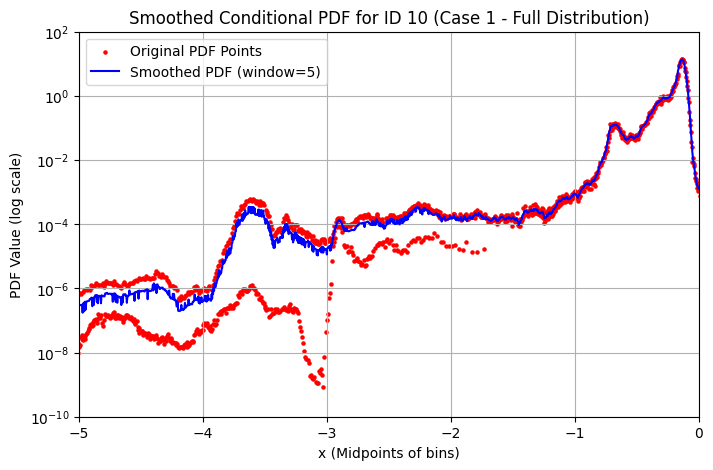

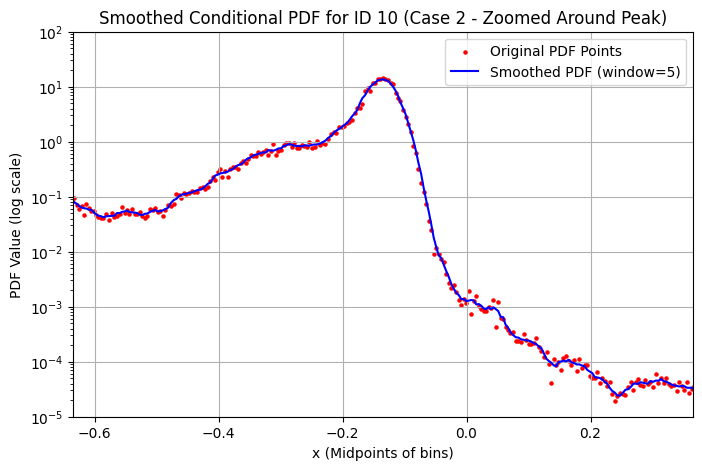

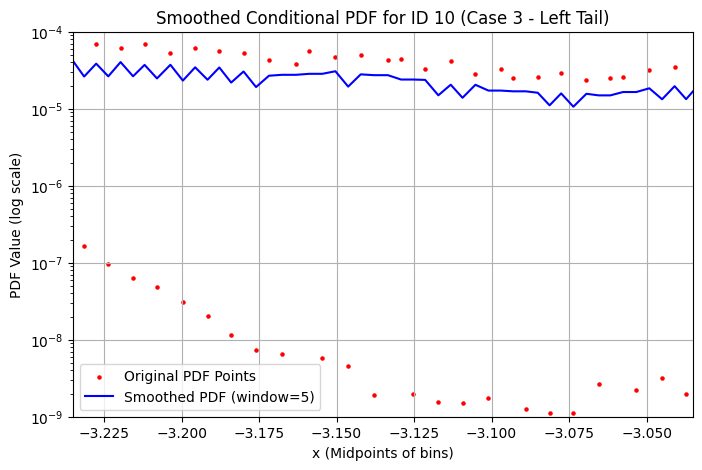

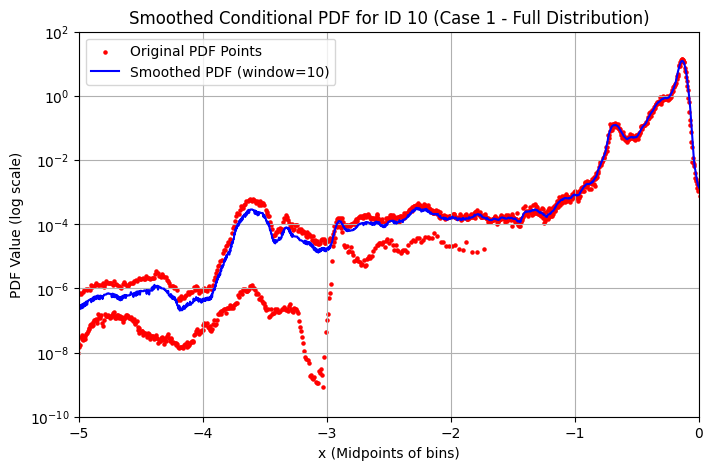

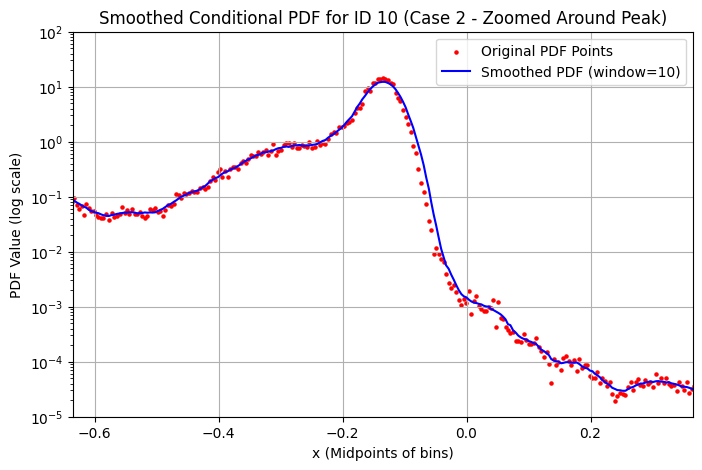

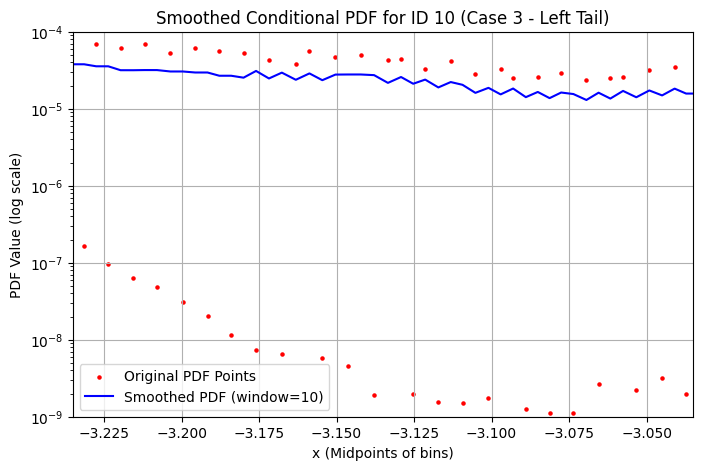

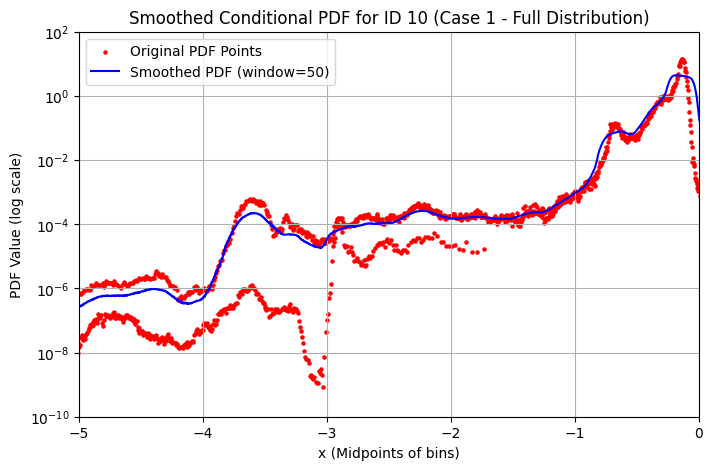

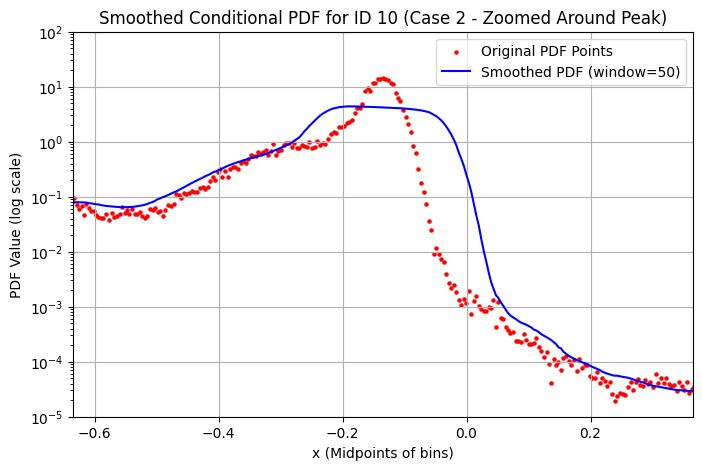

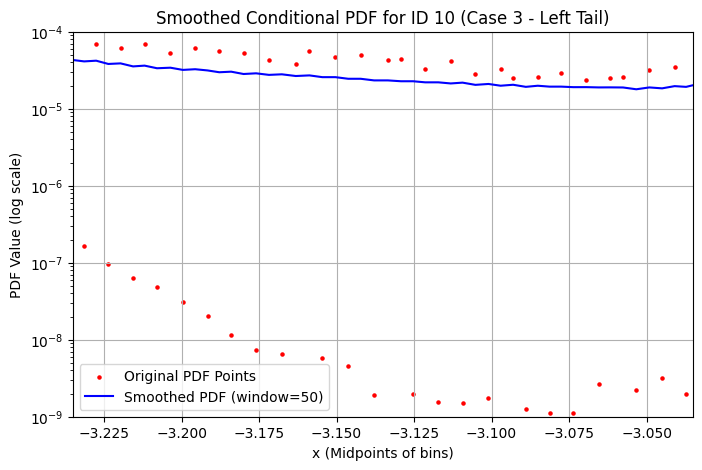

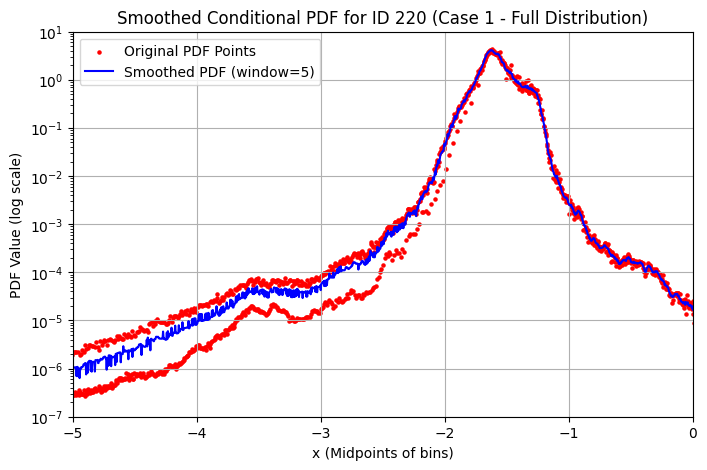

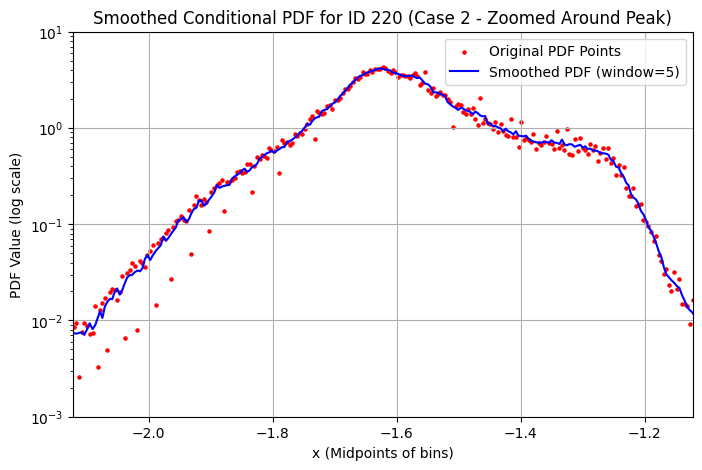

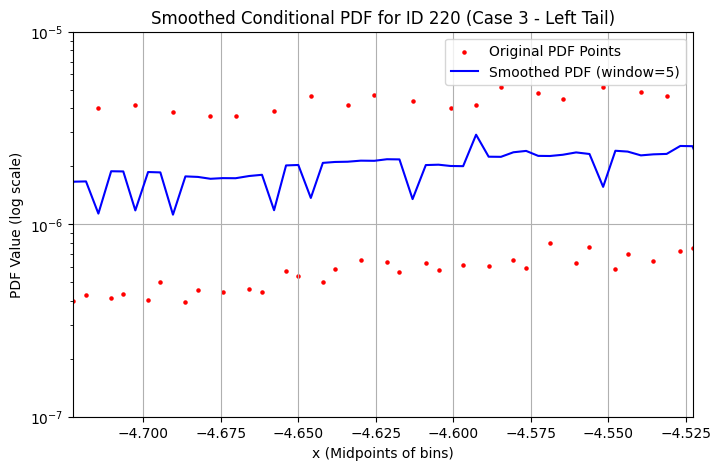

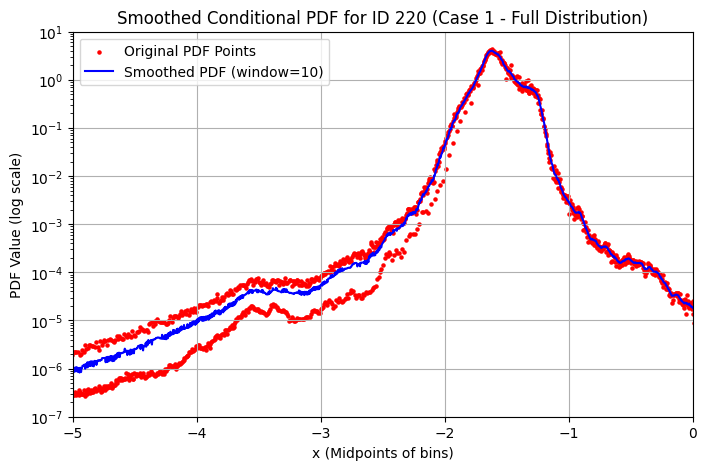

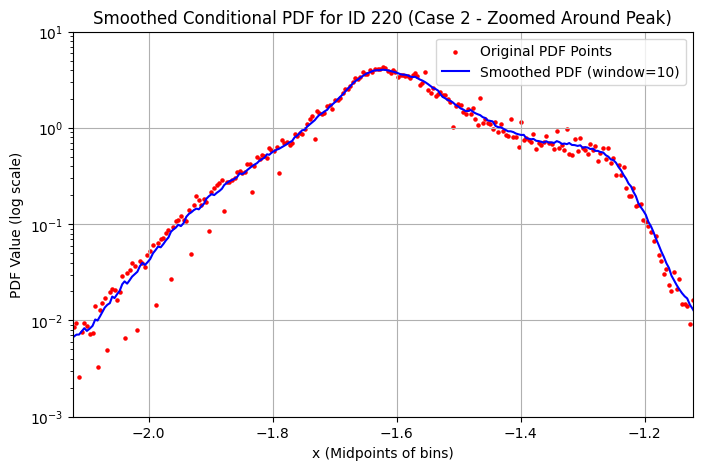

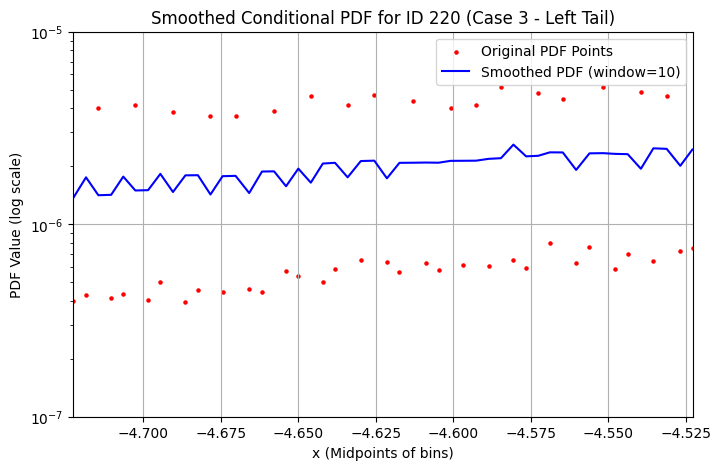

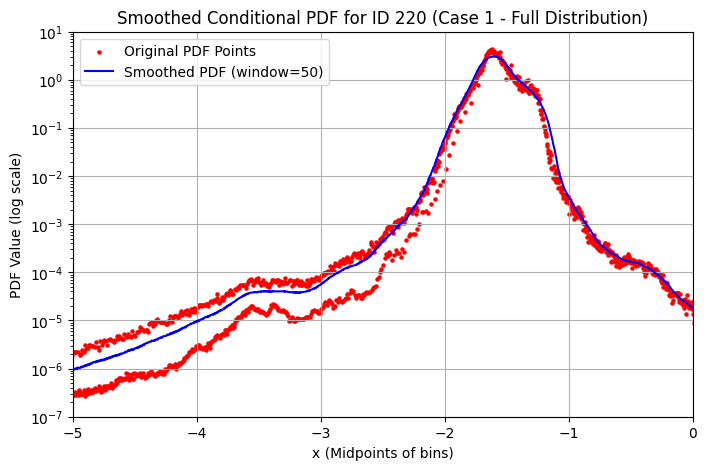

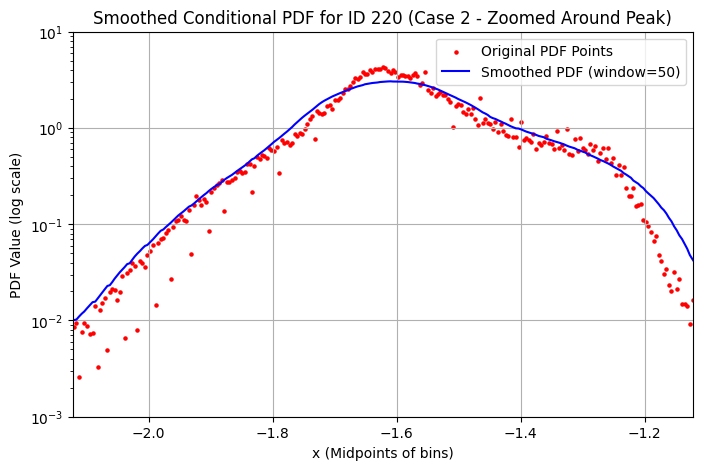

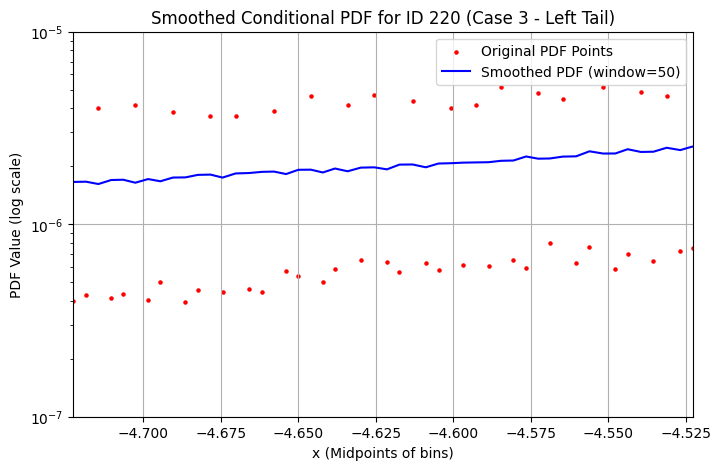

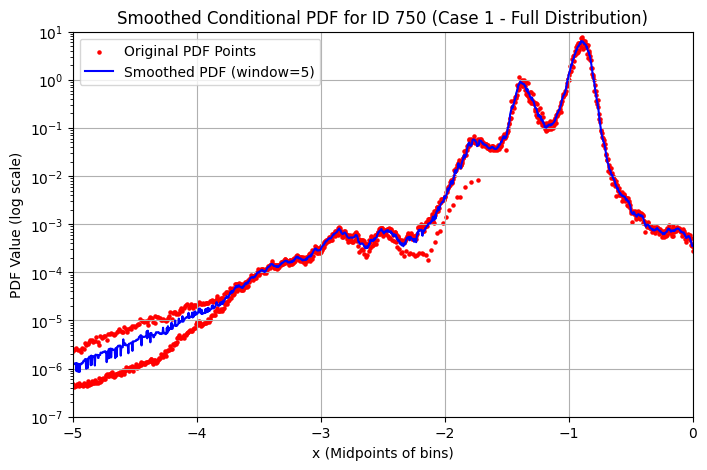

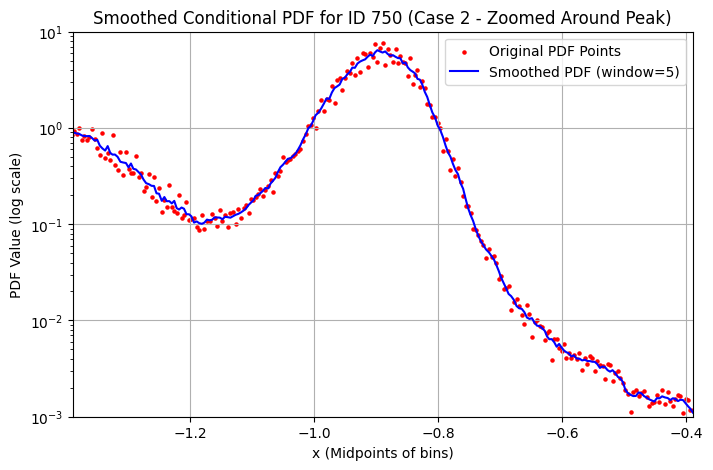

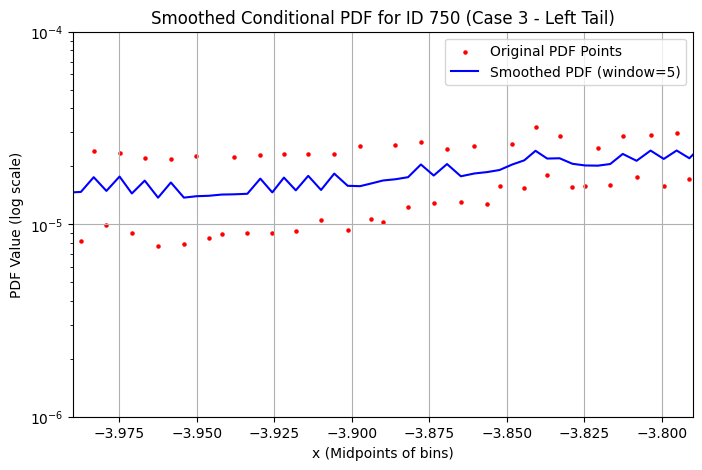

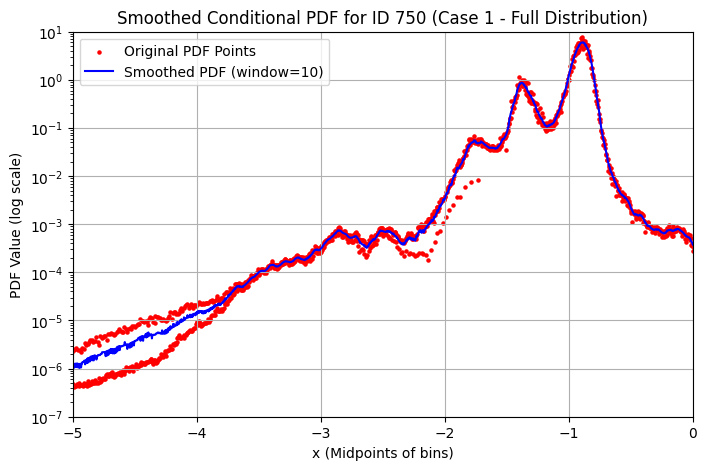

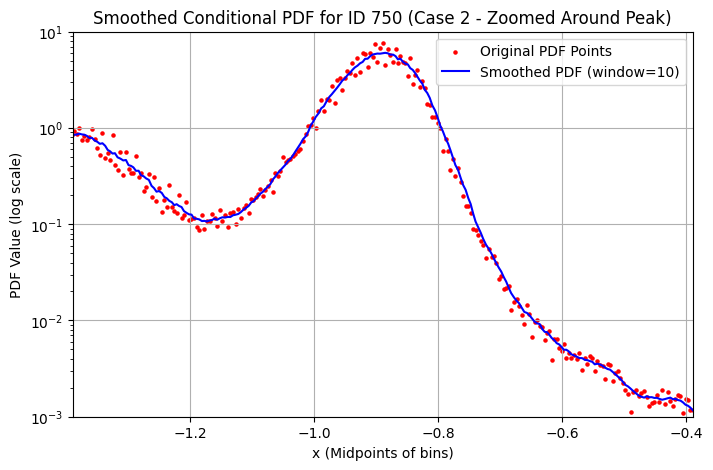

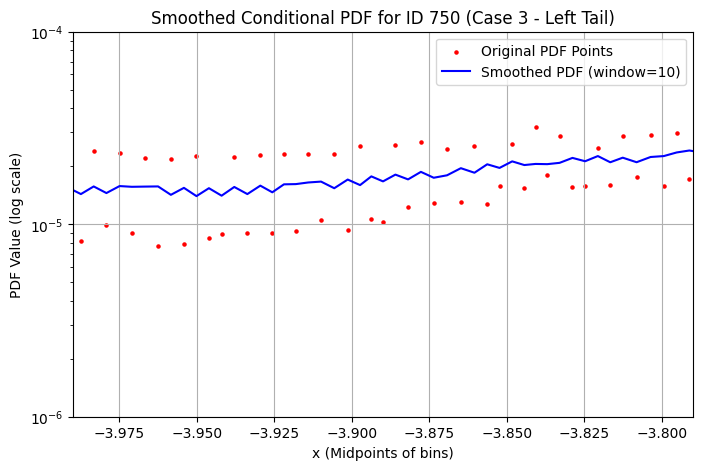

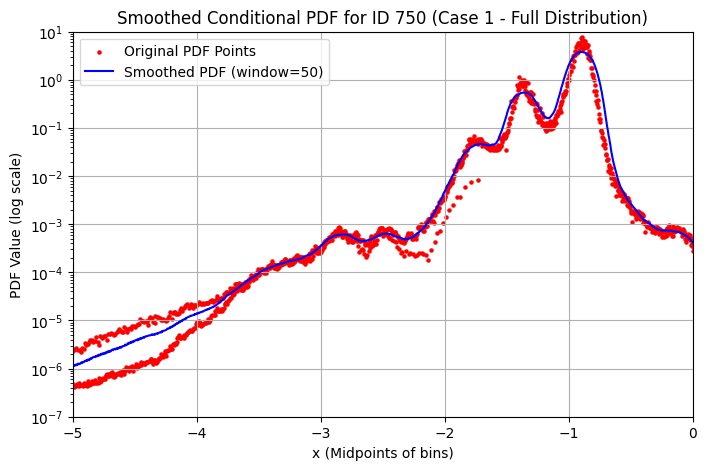

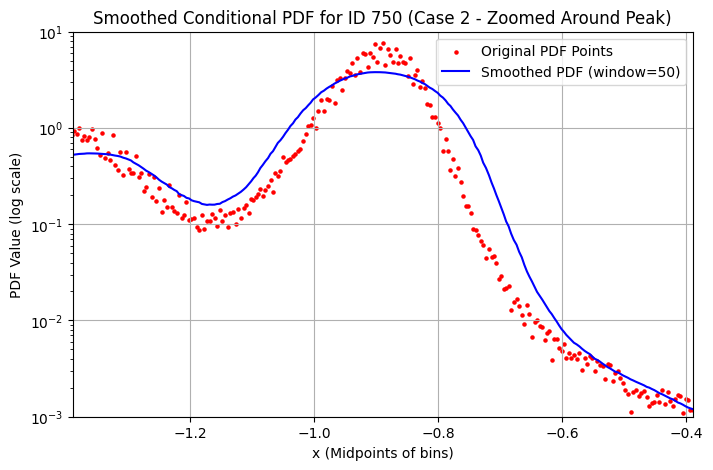

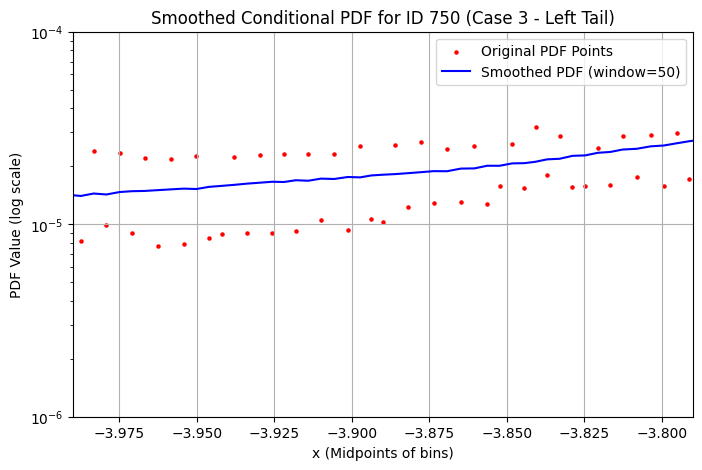

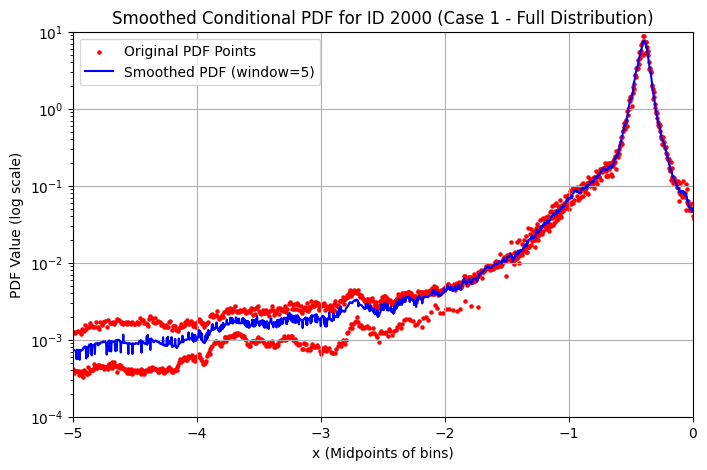

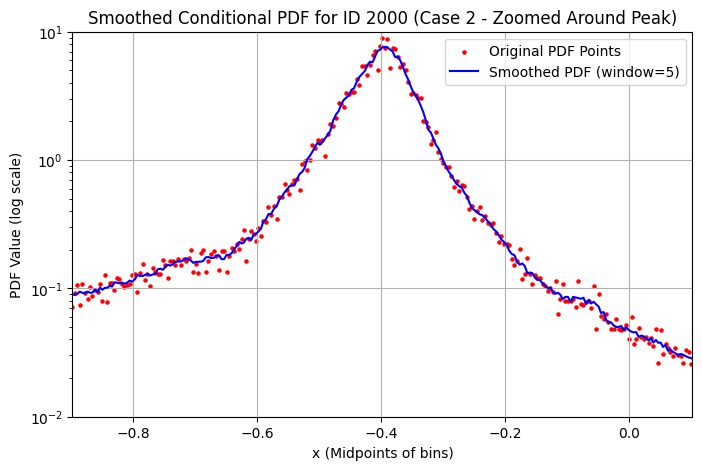

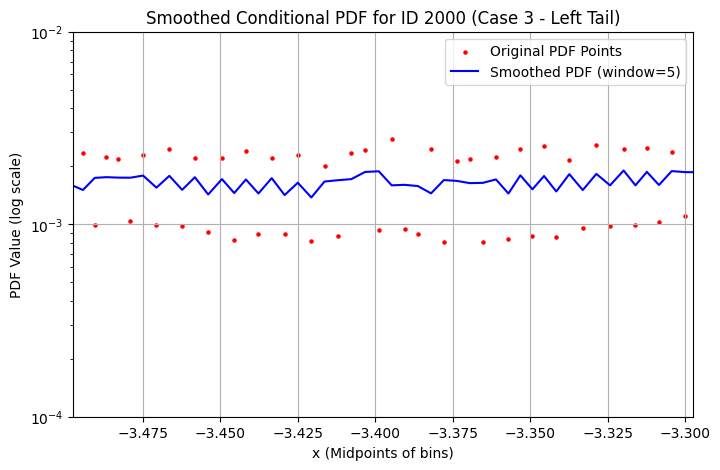

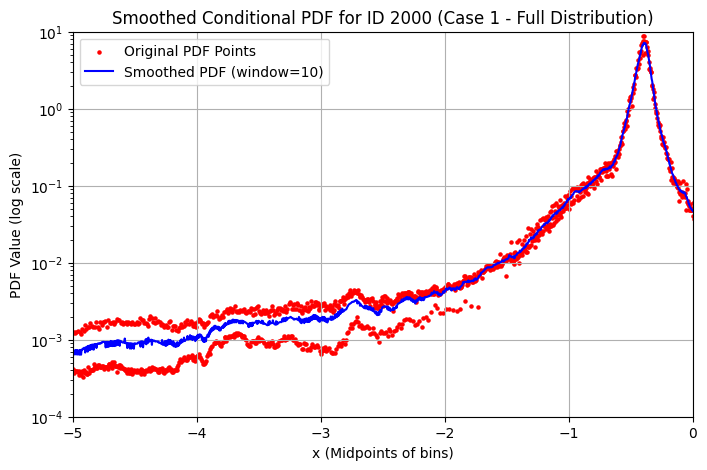

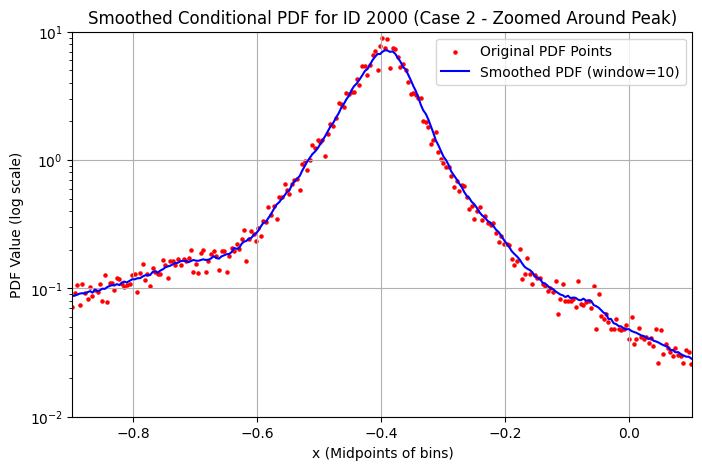

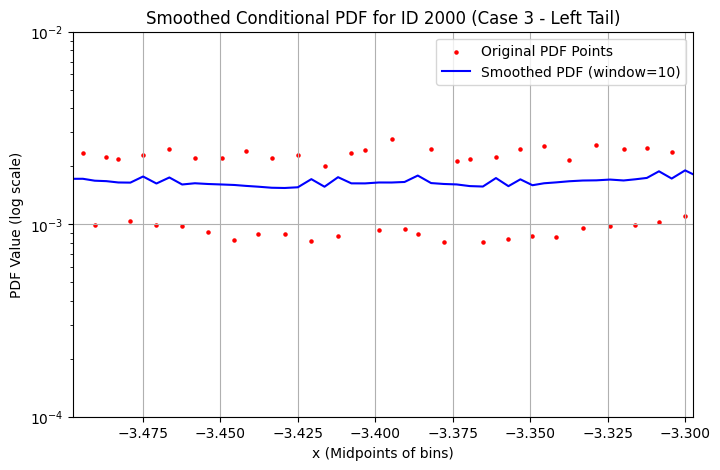

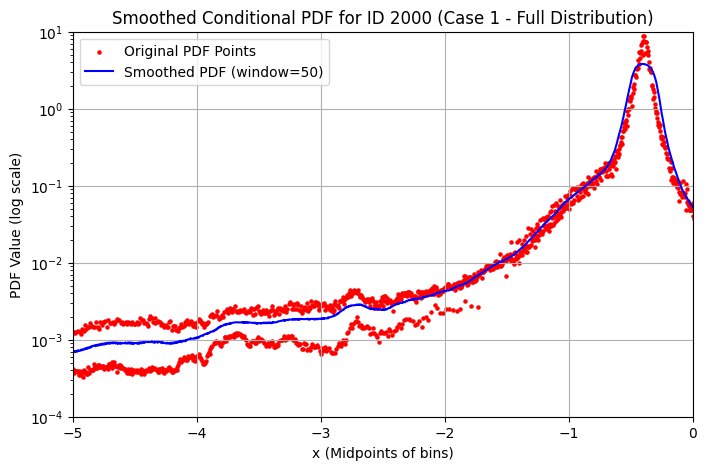

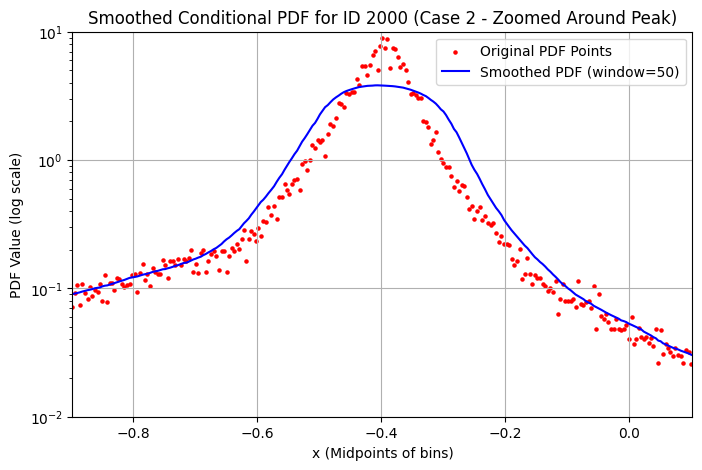

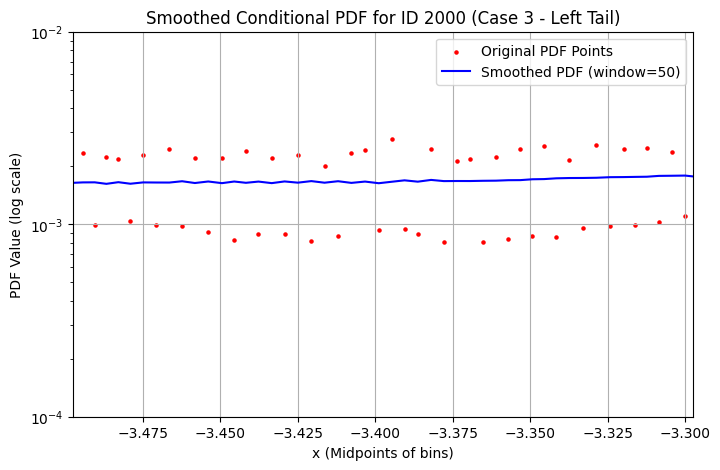

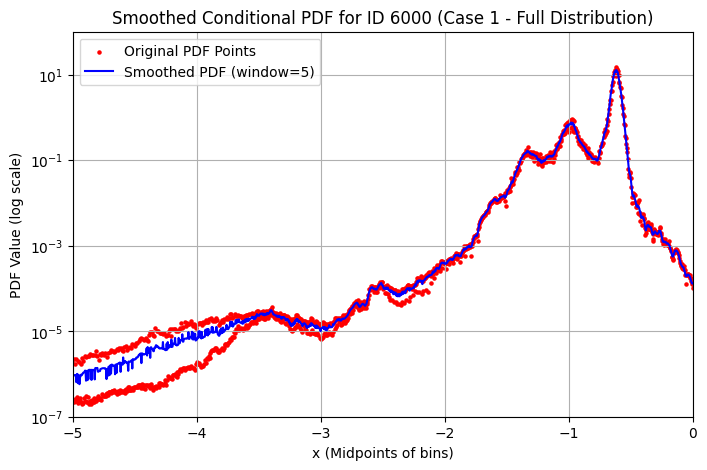

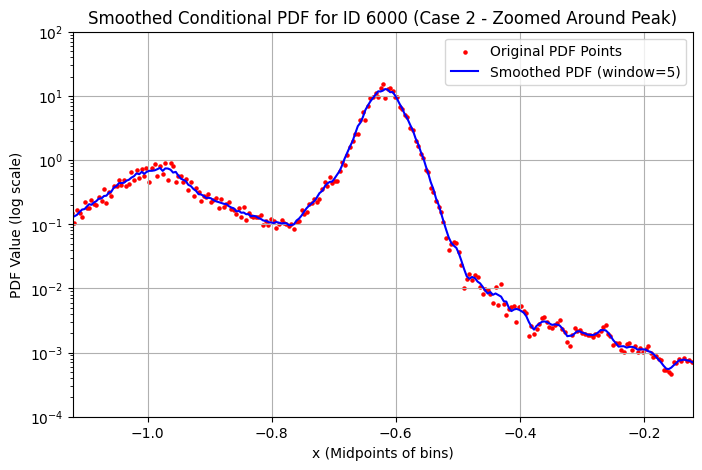

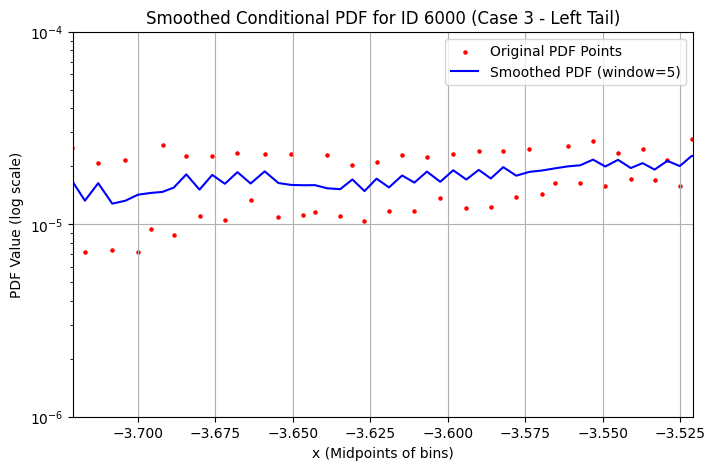

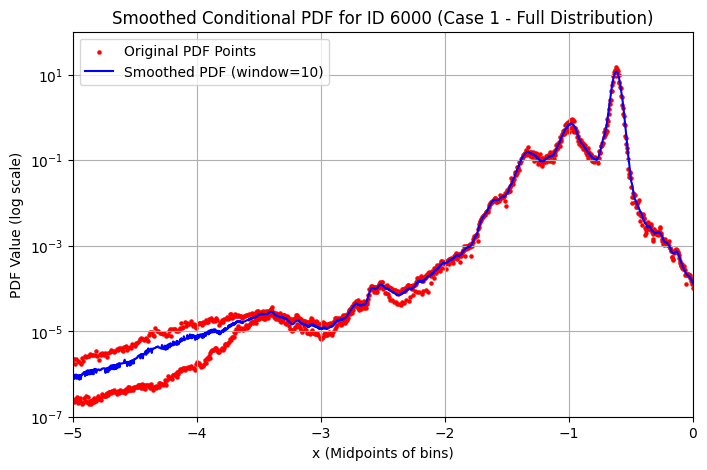

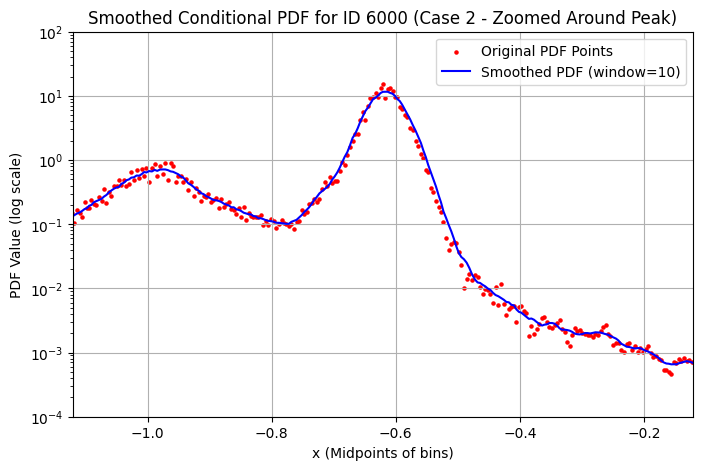

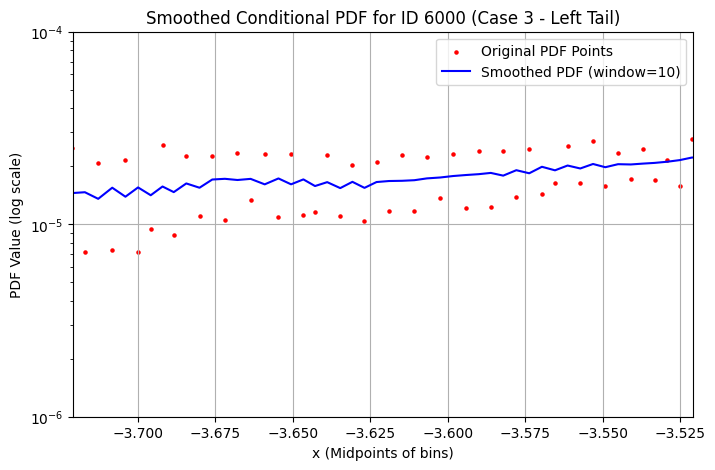

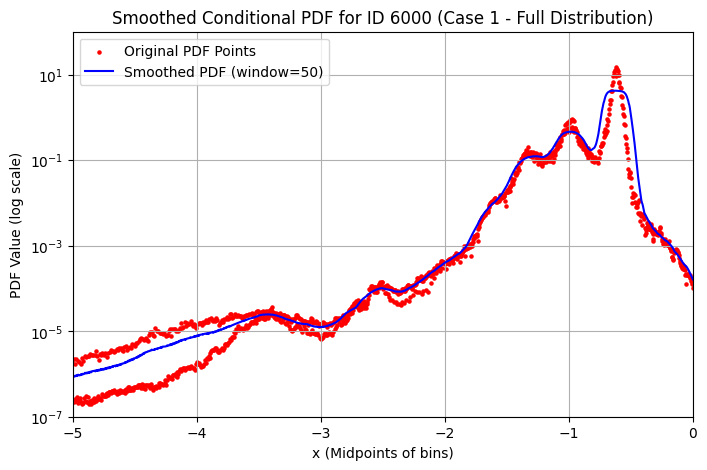

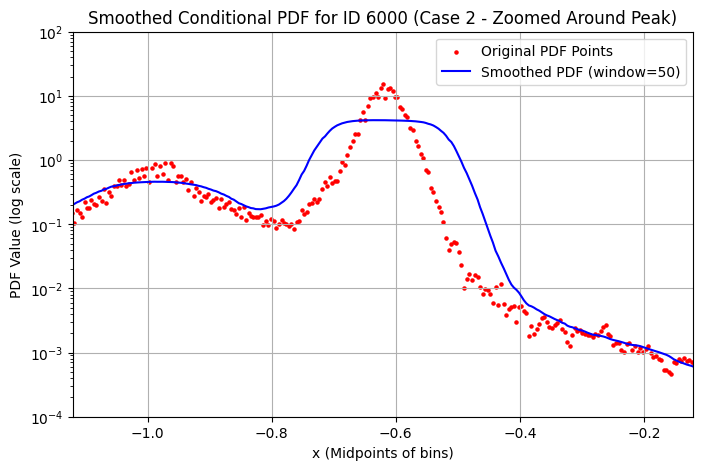

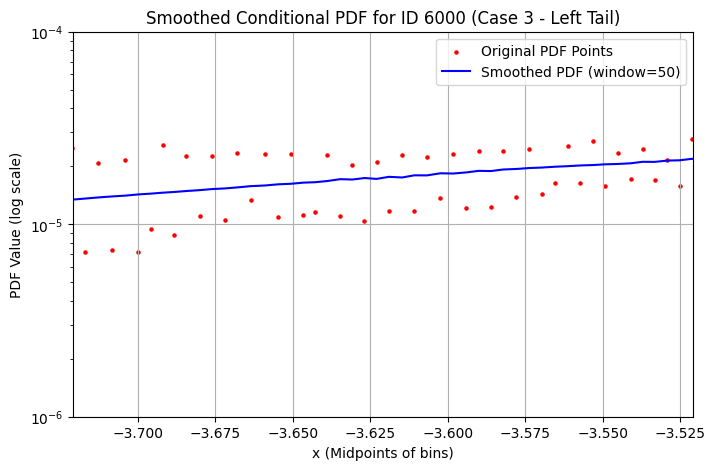

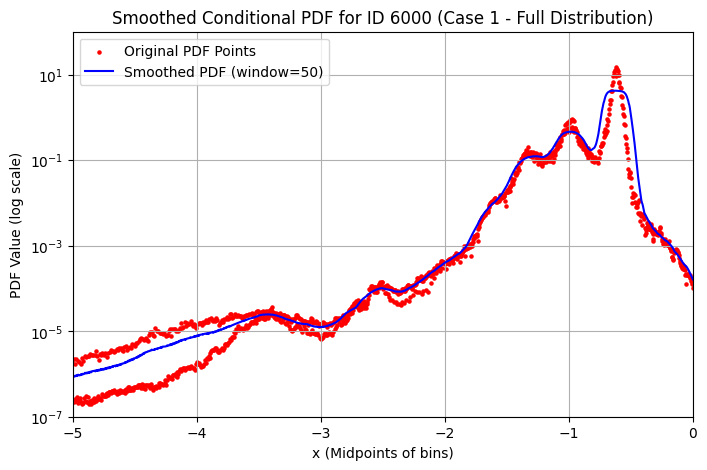

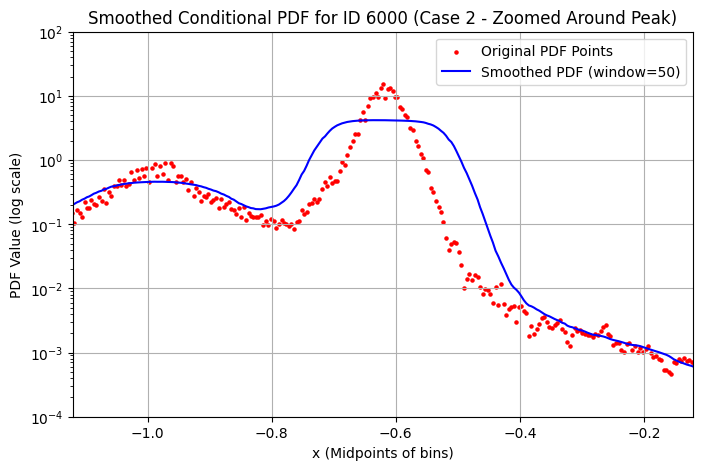

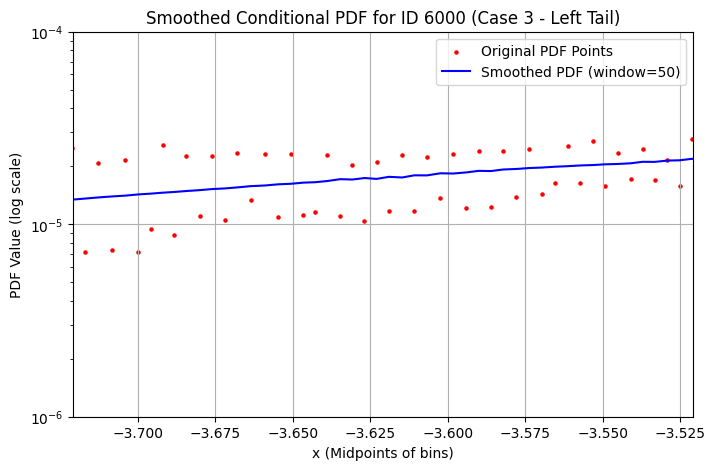

In [122]:
ids = [10, 220, 750, 2000, 6000]
window_sizes = [5, 10, 50]

visualization = Visualization(experiment)


for id in ids:
    for window_size in window_sizes:
        visualization.plot_smoothed_pdf(id=id, window_size=window_size)


visualization.plot_smoothed_pdf(id=id, window_size=window_size)

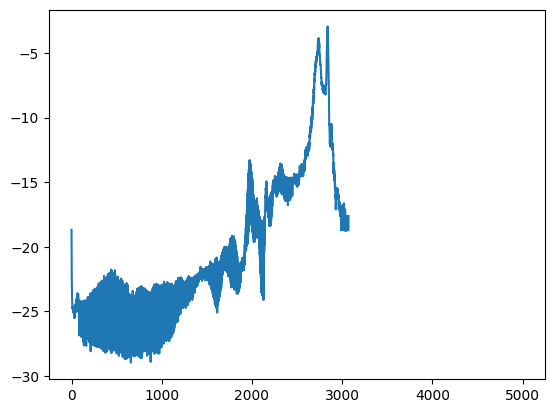

In [130]:
plt.plot(experiment.logits[20,:])

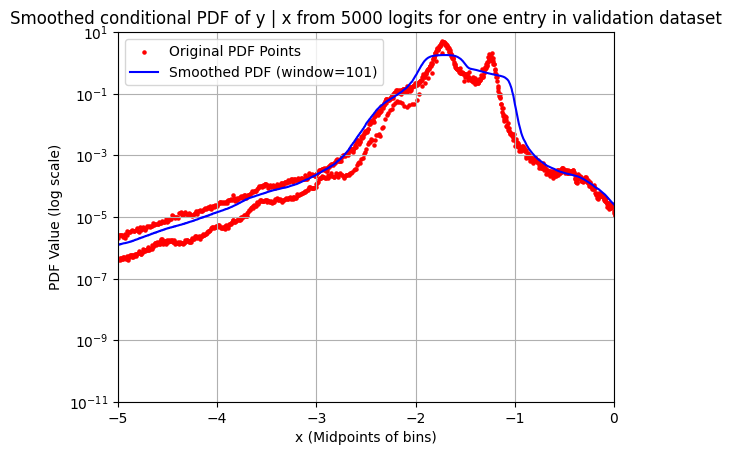

In [ ]:
from matplotlib import pyplot as plt

case = 1
id = 100
x = experiment.dists[id].bin_midpoints
pdf = experiment.dists[id].pdf(x)

window_size=101
window = np.ones(window_size) / window_size  # Box filter (uniform weights)

#smoothed_pdf = np.convolve(pdf_values, window, mode='same')
smooth_pdf=np.convolve(pdf, window, mode='same')
if case == 1:
    pdf_max = np.max(pdf)
plt.xlim(-5,0)
plt.ylim(1e-11, 1e1)
plt.yscale("log")
plt.scatter(x, pdf, color="red", s=5, label="Original PDF Points")
plt.plot(x, smooth_pdf, label="Smoothed PDF (window=101)", color="blue")

plt.xlabel("x (Midpoints of bins)")
plt.ylabel("PDF Value (log scale)")
plt.title("Smoothed conditional PDF of y | x from 5000 logits for one entry in validation dataset")
plt.legend()
plt.grid()
plt.show()

In [131]:
experiment.cdf_pdf_interpolators[0].cdf_hybrid(0.1)

AttributeError: 'CDFPDFInterpolator' object has no attribute 'cdf_hybrid'

In [21]:
window_size=101
window = np.ones(window_size) / window_size  # Box filter (uniform weights)

#smoothed_pdf = np.convolve(pdf_values, window, mode='same')
smooth_pdf=np.convolve(experiment.dists[0].pdf(experiment.dists[0].bin_midpoints), window, mode='same')
linear_interp_dist = LinearInterpolatedDist(experiment.dists[0].bin_midpoints, smooth_pdf)
linear_interp_dist.pdf(experiment.dists[0].bin_midpoints)

array([5.23916565e-10, 5.54933684e-10, 5.69278236e-10, ...,
       1.61742222e-08, 1.61742222e-08, 1.61742222e-08])

In [8]:
tracker = ExperimentTracker()
experiment = tracker.track(train_X, train_y, validation_X, validation_y)

c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This func

array([1.04289336e-03, 1.08981766e-03, 1.09056299e-03, ...,
       2.74862040e-05, 2.66379191e-05, 2.59782285e-05])

In [201]:
smooth_pdf

array([1.04289336e-03, 1.08981766e-03, 1.09056299e-03, ...,
       2.74862040e-05, 2.66379191e-05, 2.59782285e-05])

In [164]:
hists[0].pdf(np.arange(5))

array([0.11495342, 0.03288707, 0.01073616, 0.00521868, 0.00139613])

In [165]:
hists[0].bin_midpoints.shape

(5000,)

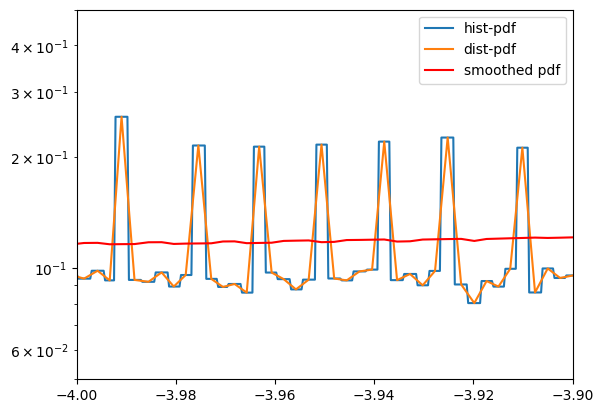

In [192]:
import matplotlib.pyplot as plt

#x = np.linspace(-100, 0, num=1000)
x = np.linspace(-20, 10, num=100000)
y = hists[0].pdf(x)
plt.plot(x, y, label='hist-pdf')
#plt.plot(x, hists[0].cdf(x), label='hist-cdf')

x = dists[0].bin_midpoints
y = dists[0].pdf(x)
plt.plot(x, y, label="dist-pdf")
plt.plot(x, smooth_pdf, label="smoothed pdf", color="red")
plt.yscale("log")
plt.xlim(-4, -3.9)
plt.ylim(5e-2, 5e-1)
plt.legend()

In [ ]:
np.convolve(experiment.probits.copy()

AttributeError: 'numpy.ndarray' object has no attribute 'convolve'

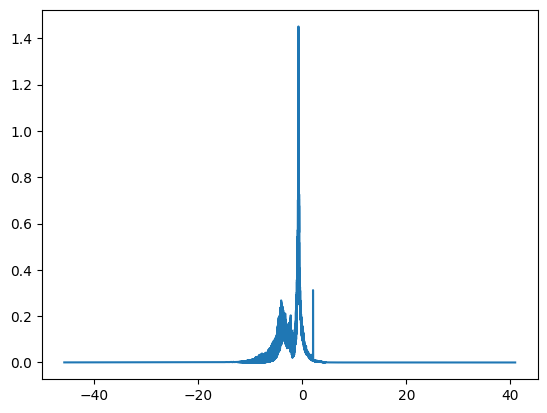

In [168]:
import matplotlib.pyplot as plt

x = dists[0].bin_midpoints
y = dists[0].pdf(x)
plt.plot(x, y)
#plt.plot(x, dists[0].cdf(x))


### enrich_tabpfn_output(nd array logits(N, 5000), 1D array borders(5001), nd array quantiles(N,9), y_validation[i])
--> returns DataFrame with N rows and columns
- 5000 columns of logits,
- 5001 columns of borders,
- 9 columns quantiles, 
- 1 column of true y,
- 5000 cdf columns,
- 5000 pdf,
- 5000 smoothed pdf

# evaluate_tabpfn(raw: DataFrame, "processed": DataFrame):
--> saves a DataFrame "scores"
    N rows, 9 columns:
        CRPS Linear, CRPS Hybrid, CRPS Normal, CRPS (5000 quantiles), NLL Linear, NLL Hybrid, NLL Normal, NLL (5000 quantiles), NLL smoothed (moving average)

In [5]:
train, validation, test = to_train_validation_test_data(entsoe, "2022-09-01", "2022-12-31", "2023-01-01", "2023-12-31")

# of training observations: 11712 | 3.71%
# of validation observations: 35040 | 11.10%
# of test observations: 35133 | 11.13%
